# Packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import datetime as dt
import shap
import numpy as np

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

In [3]:
now = dt.datetime.now()
now = now.strftime('%Y-%m-%d')
filepath = 'path/to/base/directory/'

# Load Boruta proteins

In [4]:

# load vars selected by Boruta
feature_path = ".../proteomic_age/results/boruta/pAge_UKB_3k_dart_minMax_Boruta_vars_to_keep_2023-12-23.csv"
# feature_path = "/Users/aargenti/Documents/proteomic_age/results/boruta/pAge_UKB_3k_dart_noImp_minMax_Boruta_vars_to_keep_2024-01-05.csv"
comb_proteins = pd.read_csv(feature_path, header=None)
comb_proteins = list(comb_proteins[0])

# Load top 20 proteins

In [5]:
# path = f'{filepath}results/boruta/pAge_UKB_3k_minMax_top_20_features_2023-12-28.csv'
path = f'{filepath}results/boruta/RFECV_SHAP_top_20_features_2023-12-29.csv'
top_20_features = pd.read_csv(path, header=None)
top_20_features = list(top_20_features[0])
len(top_20_features)

20

# Protein names

In [6]:
# names of olink proteins in data
list_path = f'{filepath}data/olink_names_oct_30_2023.csv'
olink_names = pd.read_csv(list_path, header=None)
olink_names = list(olink_names[0])

remove_prots = [
    # proteins in UKB but not CKB
    'HLA_A',
    'ERVV_1',
    
    # proteins in CKB but not UKB
    'CD97',
    'FGFR1OP',
    'LRMP',
    'CASC4',
    'DARS',
    'HARS',
    'WISP2',
    'FOPNL',
    'WISP1',
    
    # proteins not in FinnGen
    'EDEM2',
    'EP300',
    'CGA',
    'CDHR1',
    'CPLX2',
    'CLSTN1',
    'IFIT1',
    'FGF3',
    'TAGLN3',
    'YAP1',
    'ADIPOQ',
    'BCL2L11',
    'BMP6',
    'BID',
    'SH3GL3',
    'ARL13B',
    'ANGPTL7',
    'MGLL',
    'MPI',
    'MAGEA3',
    'KCNH2'
]

extra = [
    # proteins missing > 20%
    'GLIPR1', 
    'NPM1', 
    'PCOLCE' 
]

combined = remove_prots + extra

# remove proteins not common to both cohorts
olink_names_resnet = [prot for prot in olink_names if prot not in remove_prots]
olink_names = [prot for prot in olink_names if prot not in combined]
# olink_names = [prot for prot in olink_names if prot not in extra]

# Load pred dfs

In [7]:
# import predicted values dfs from above (if running later)

## lightgbm boruta
name = f'{filepath}results/lgbm/pAge_UKB_3k_post_Boruta_scores_UKB_dart_2023-12-28.csv'
# name = f'{filepath}results/lgbm/pAge_UKB_3k_dart_noImp_minMax_scores_UKB_2024-01-05.csv'
pred_df_ukb = pd.read_csv(name)

## lightgbm in top 20 proteins
name = '/Users/aargenti/Documents/proteomic_age/results/lgbm/pAge_UKB_3k_top_20_scores_UKB_2023-12-29.csv'
pred_df_ukb_20 = pd.read_csv(name)

# merge
pred_df_ukb_20 = pred_df_ukb_20.rename(columns={'predicted_values':'predicted_values_20'})
pred_df_ukb_20 = pred_df_ukb_20[['eid', 'predicted_values_20']]
pred_df_ukb = pd.merge(pred_df_ukb, pred_df_ukb_20, on='eid', how='inner')

# lightgbm boruta in CKB
name = '/Users/aargenti/Documents/proteomic_age/results/lgbm/pAge_CKB_3k_scores_all_dart_2023-12-28.csv'
# name = '/Users/aargenti/Documents/proteomic_age/results/lgbm/pAge_UKB_3k_dart_noImp_minMax_scores_CKB_all_2024-01-05.csv'
pred_df_ckb = pd.read_csv(name)

# Load UKB data

In [8]:
# import data
data_path2 = f'{filepath}data/olink_data_imputed_nov_18_2023.csv'
ukb_olink_data = pd.read_csv(data_path2)

exposure_path = f'{filepath}data/ukb_imputation1_jul_25_2023.feather'
exposure_data = pd.read_feather(exposure_path)
exposure_data.rename(columns={'SHBG': 'SHBG_biochem'}, inplace=True)

dx_path = f'{filepath}data/interview_dx_data.csv'
dx_data = pd.read_csv(dx_path)

disease_path = f'{filepath}data/incident_disease_data_2024-06-21.csv'
disease_data = pd.read_csv(disease_path)
disease_cols = list(disease_data.columns)

mort_path = f'{filepath}data/mortality_data_oct_18_2023.csv'
mort_data = pd.read_csv(mort_path)

cancer_path = f'{filepath}data/cancer_data_july_05_2023.csv'
cancer_data = pd.read_csv(cancer_path)

survival_data = pd.merge(pred_df_ukb, ukb_olink_data, on='eid', how='inner')
survival_data = pd.merge(survival_data, exposure_data, on='eid', how='left')
survival_data = pd.merge(survival_data, dx_data, on='eid', how='inner')
survival_data = pd.merge(survival_data, mort_data, on='eid', how='inner')
survival_data = pd.merge(survival_data, disease_data, on='eid', how='inner')
survival_data = pd.merge(survival_data, cancer_data, on='eid', how='inner')

# convert survival time in days to years
survival_data['ACM_survival_years'] = survival_data['ACM_survival_time'] / 365.25

del cancer_data
del dx_data
del disease_data

len(survival_data.index)

Columns (42,44,48,50,51,52) have mixed types. Specify dtype option on import or set low_memory=False.


45441

# Load CKB data

In [9]:
# import data

# path to data
data_path = f'{filepath}data/ckb/ckb_coded_olink_oct_17_2023.csv'
# load data
ckb_data = pd.read_csv(data_path)
# subset to those in random subset
# ckb_data = ckb_data[ckb_data['olinkexp1536_chd_b1_subcohort'] == 1]
ckb_data = ckb_data.drop('is_female', axis=1)

# path to data
data_path = f'{filepath}data/ckb/ckb_coded_data_oct_24_2023.feather'
# load data
ckb_mort_data = pd.read_feather(data_path)

ckb_data = pd.merge(ckb_data, ckb_mort_data, on='csid', how='inner')
ckb_data = pd.merge(ckb_data, pred_df_ckb, on='csid', how='left')

len(ckb_data.index)

del ckb_mort_data

# ProtAgeGap as residuals

In [8]:
import statsmodels.api as sm

# Create a formula for the linear regression
formula = f'predicted_values ~ age_granular'

# Fit the model using the formula
lm_UKB = sm.formula.ols(formula=formula, data=survival_data).fit()
lm_CKB = sm.formula.ols(formula=formula, data=ckb_data).fit()

survival_data['ProtAgeGap_resid'] = lm_UKB.resid
ckb_data['ProtAgeGap_resid'] = lm_CKB.resid


# Create a formula for the linear regression
formula = f'predicted_values_20 ~ age_granular'

# Fit the model using the formula
lm_UKB = sm.formula.ols(formula=formula, data=survival_data).fit()

survival_data['ProtAgeGap_resid_20'] = lm_UKB.resid

## Plot

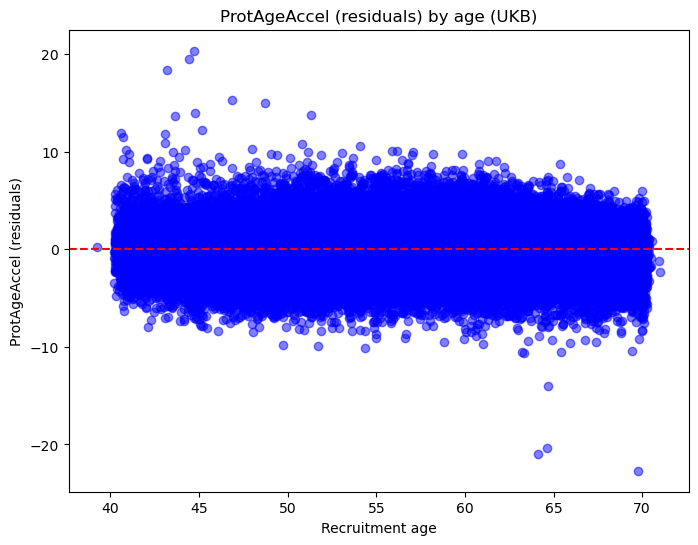

In [10]:
# Create a scatter plot of y (dependent variable) on the x-axis and residuals on the y-axis
plt.figure(figsize=(8, 6))
plt.scatter(survival_data['age_granular'], survival_data['ProtAgeGap_resid'], alpha=0.5, color='blue')
# plt.scatter(ckb_data['age_granular'], ckb_data['ProtAgeGap'], alpha=0.5, color='blue')

# Add labels and a title
# plt.title("ProtAgeGap (residuals) by age (UKB)")
plt.title("ProtAgeGap (residuals) by age (UKB)")
plt.xlabel("Recruitment age")
plt.ylabel("ProtAgeGap (residuals)")

# Add a horizontal line at y=0
plt.axhline(y=0, color='red', linestyle='--')

plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='age_cat', ylabel='ProtAgeAccel'>

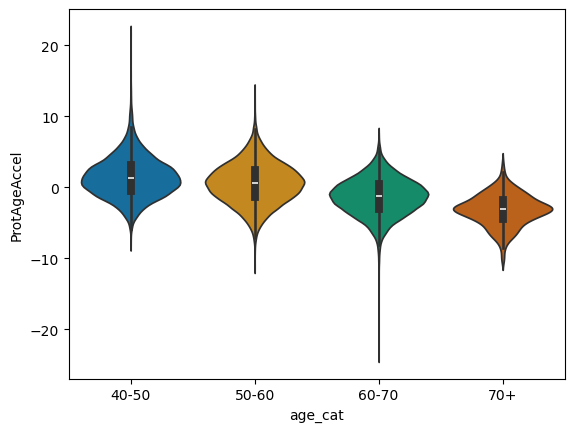

In [33]:
import seaborn as sns

# Define the age ranges
bins = [40, 50, 60, 70, float('inf')]
labels = ['40-50', '50-60', '60-70', '70+']

# Create a new categorical variable based on age ranges
survival_data['age_cat'] = pd.cut(survival_data['age_granular'], bins=bins, labels=labels, right=False)

survival_data['age_cat']

sns.violinplot(
    data=survival_data,
    y='ProtAgeGap',
    x='age_cat',
    # palette=colors,
    palette="colorblind"
)

# ProtAgeGap as difference

In [10]:
survival_data['ProtAgeGap'] = survival_data['predicted_values'] - survival_data['age_granular']
ckb_data['ProtAgeGap'] = ckb_data['predicted_values'] - ckb_data['age_granular']

survival_data['ProtAgeGap_20'] = survival_data['predicted_values_20'] - survival_data['age_granular']

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


## Plot

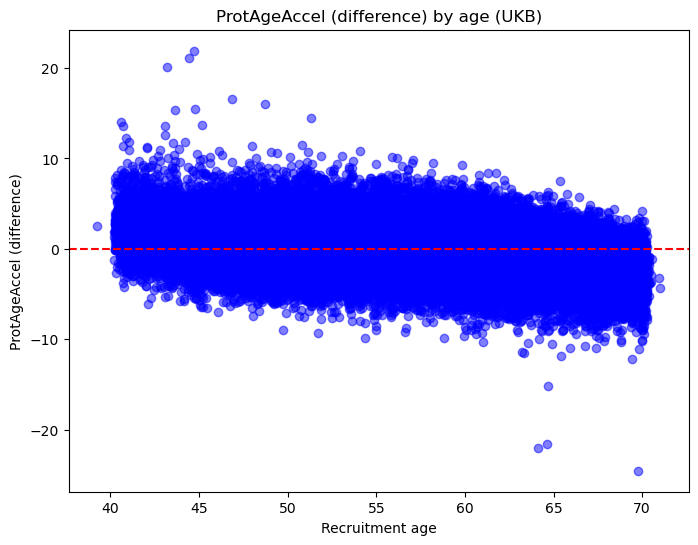

In [12]:
# Create a scatter plot of y (dependent variable) on the x-axis and residuals on the y-axis
plt.figure(figsize=(8, 6))
plt.scatter(survival_data['age_granular'], survival_data['ProtAgeGap'], alpha=0.5, color='blue')
# plt.scatter(ckb_data['age_granular'], ckb_data['ProtAgeGap'], alpha=0.5, color='blue')

# Add labels and a title
# plt.title("ProtAgeGap (residuals) by age (UKB)")
plt.title("ProtAgeGap (difference) by age (UKB)")
plt.xlabel("Recruitment age")
plt.ylabel("ProtAgeGap (difference)")

# Add a horizontal line at y=0
plt.axhline(y=0, color='red', linestyle='--')

plt.show()

# Table one

In [20]:
cols = list(ckb_data.columns)
cols2 = list(survival_data.columns)

In [27]:
from tableone import TableOne

# duplicate data
ckb_table_data = ckb_data.copy()
ukb_table_data = survival_data.copy()

# rename columns to match UKB
ckb_table_data = ckb_table_data.rename(columns={'is_female': 'sex', 'bmi_calc': 'BMI'})
ckb_table_data['sex'] = ckb_table_data['sex'].replace({'Yes': 'Female', 'No': 'Male'})

# make ethnicity for CKB
ckb_table_data['ethnicity'] = np.nan

# make empty diagnoses for CKB
ckb_table_data['incident_alzheimers'] = np.nan
ckb_table_data['incident_all_dementia'] = np.nan
ckb_table_data['incident_parkinsons'] = np.nan
ckb_table_data['incident_rheumatoid'] = np.nan
ckb_table_data['incident_macular_degen'] = np.nan
ckb_table_data['incident_osteoporosis'] = np.nan
ckb_table_data['incident_osteoarthritis'] = np.nan

# match col names
ckb_table_data['incident_emphysema_COPD'] = ckb_table_data['incident_COPD']
ckb_table_data['incident_t2diabetes'] = ckb_table_data['incident_diabetes']

# make region code for UKB
ukb_table_data['region_code'] = np.nan

# make indicator column
ckb_table_data['cohort'] = 'CKB'
ukb_table_data['cohort'] = 'UKB'

# get common cols
common_cols = ckb_table_data.columns.intersection(ukb_table_data.columns)

# subset
ckb_table_data = ckb_table_data[common_cols]
ukb_table_data = ukb_table_data[common_cols]

# concat
table_data = pd.concat([ckb_table_data, ukb_table_data], axis=0)
table_data.reset_index(inplace=True)

# set columns
columns = [
    'age_granular',
    'sex',
    'BMI',
    'incident_t2diabetes',
    'incident_IHD',
    'incident_all_stroke',
    'incident_ischemic_stroke',
    'incident_emphysema_COPD',
    'incident_liver',
    'incident_kidney',
    'incident_all_dementia',
    'incident_alzheimers',
    'incident_parkinsons',
    'incident_rheumatoid',
    'incident_macular_degen',
    'incident_osteoporosis',
    'incident_osteoarthritis',
    'ethnicity',
    'region_code'
]

categorical = [
    'sex',
    'incident_t2diabetes',
    'incident_IHD',
    'incident_all_stroke',
    'incident_ischemic_stroke',
    'incident_emphysema_COPD',
    'incident_liver',
    'incident_kidney',
    'incident_all_dementia',
    'incident_alzheimers',
    'incident_parkinsons',
    'incident_rheumatoid',
    'incident_macular_degen',
    'incident_osteoporosis',
    'incident_osteoarthritis',
    'ethnicity',
    'region_code'
]

for col in categorical:
    table_data[f'{col}'] = pd.Categorical(table_data[f'{col}'])


# make table
mytable = TableOne(
    table_data, 
    columns=columns, 
    # min_max=['age_granular'],
    categorical=categorical, 
    groupby='cohort', 
    # nonnormal=nonnormal, 
    # rename=labels, 
    pval=False,
    missing=False
)

print(mytable.tabulate(tablefmt='fancy_grid'))

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


╒═════════════════════════════════╤══════════════════╤══════════════╤═════════════╤══════════════╕
│                                 │                  │ Overall      │ CKB         │ UKB          │
╞═════════════════════════════════╪══════════════════╪══════════════╪═════════════╪══════════════╡
│ n                               │                  │ 49418        │ 3977        │ 45441        │
├─────────────────────────────────┼──────────────────┼──────────────┼─────────────┼──────────────┤
│ age_granular, mean (SD)         │                  │ 57.4 (8.5)   │ 57.3 (11.7) │ 57.4 (8.2)   │
├─────────────────────────────────┼──────────────────┼──────────────┼─────────────┼──────────────┤
│ sex, n (%)                      │ Female           │ 26716 (54.1) │ 2137 (53.7) │ 24579 (54.1) │
├─────────────────────────────────┼──────────────────┼──────────────┼─────────────┼──────────────┤
│                                 │ Male             │ 22702 (45.9) │ 1840 (46.3) │ 20862 (45.9) │
├─────────

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


# Protein correlation

## Run

In [18]:
corr_df = survival_data[olink_names].copy()
corr = corr_df.corr(method='pearson')

In [22]:
corr_sub = corr.loc[top_20_features, top_20_features]
corr_sub

,CXCL17,EDA2R,ELN,ENG,CDCP1,COL6A3,IGDCC4,GFAP,GDF15,FSHB,AGRP,ACRV1,NEFL,LECT2,SCARF2,LTBP2,PTPRR,PODXL2,KLK3,KLK7
CXCL17,1.000000,0.378711,0.405881,0.178685,0.400987,0.262283,-0.162661,0.196030,0.452857,0.153932,0.179179,0.071703,0.280381,0.260906,0.270789,0.317881,0.052336,-0.023500,0.062338,0.004555
EDA2R,0.378711,1.000000,0.569243,0.107750,0.398979,0.598503,-0.121058,0.315477,0.597548,0.194827,0.073991,0.110182,0.496060,0.409608,0.525358,0.503083,0.166813,0.106177,0.067251,-0.044711
ELN,0.405881,0.569243,1.000000,0.110169,0.336299,0.429486,-0.119881,0.319644,0.420979,0.416510,0.201433,-0.049945,0.436925,0.544628,0.536323,0.511452,0.149417,0.033298,-0.087749,-0.020356
ENG,0.178685,0.107750,0.110169,1.000000,0.177128,0.209125,0.178205,0.053325,0.172290,0.045691,0.099282,0.049036,0.078442,0.032385,0.381399,0.369643,0.074788,0.184065,0.032227,0.055385
CDCP1,0.400987,0.398979,0.336299,0.177128,1.000000,0.322653,-0.134397,0.173076,0.483176,0.100531,0.093403,0.123386,0.281970,0.289311,0.306295,0.390733,-0.020607,0.012367,0.101392,-0.053585
COL6A3,0.262283,0.598503,0.429486,0.209125,0.322653,1.000000,0.020936,0.151996,0.510942,0.031024,0.189327,0.119953,0.298330,0.347562,0.446638,0.354311,0.183404,0.149303,0.082596,0.102874
IGDCC4,-0.162661,-0.121058,-0.119881,0.178205,-0.134397,0.020936,1.000000,-0.091416,-0.185025,-0.199299,0.013565,0.096551,-0.086541,-0.165601,0.040597,0.002911,0.096657,0.107704,0.122450,0.213145
GFAP,0.196030,0.315477,0.319644,0.053325,0.173076,0.151996,-0.091416,1.000000,0.195319,0.272382,0.025293,-0.054396,0.377194,0.231715,0.316952,0.333589,0.261549,0.177297,-0.071211,-0.055901
GDF15,0.452857,0.597548,0.420979,0.172290,0.483176,0.510942,-0.185025,0.195319,1.000000,0.056896,0.143084,0.169618,0.379196,0.345409,0.384146,0.423461,0.031559,0.023644,0.148313,-0.050896
FSHB,0.153932,0.194827,0.416510,0.045691,0.100531,0.031024,-0.199299,0.272382,0.056896,1.000000,-0.082845,-0.538658,0.193432,0.283111,0.334205,0.308358,0.166029,0.069213,-0.598423,-0.058131


## Plot

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


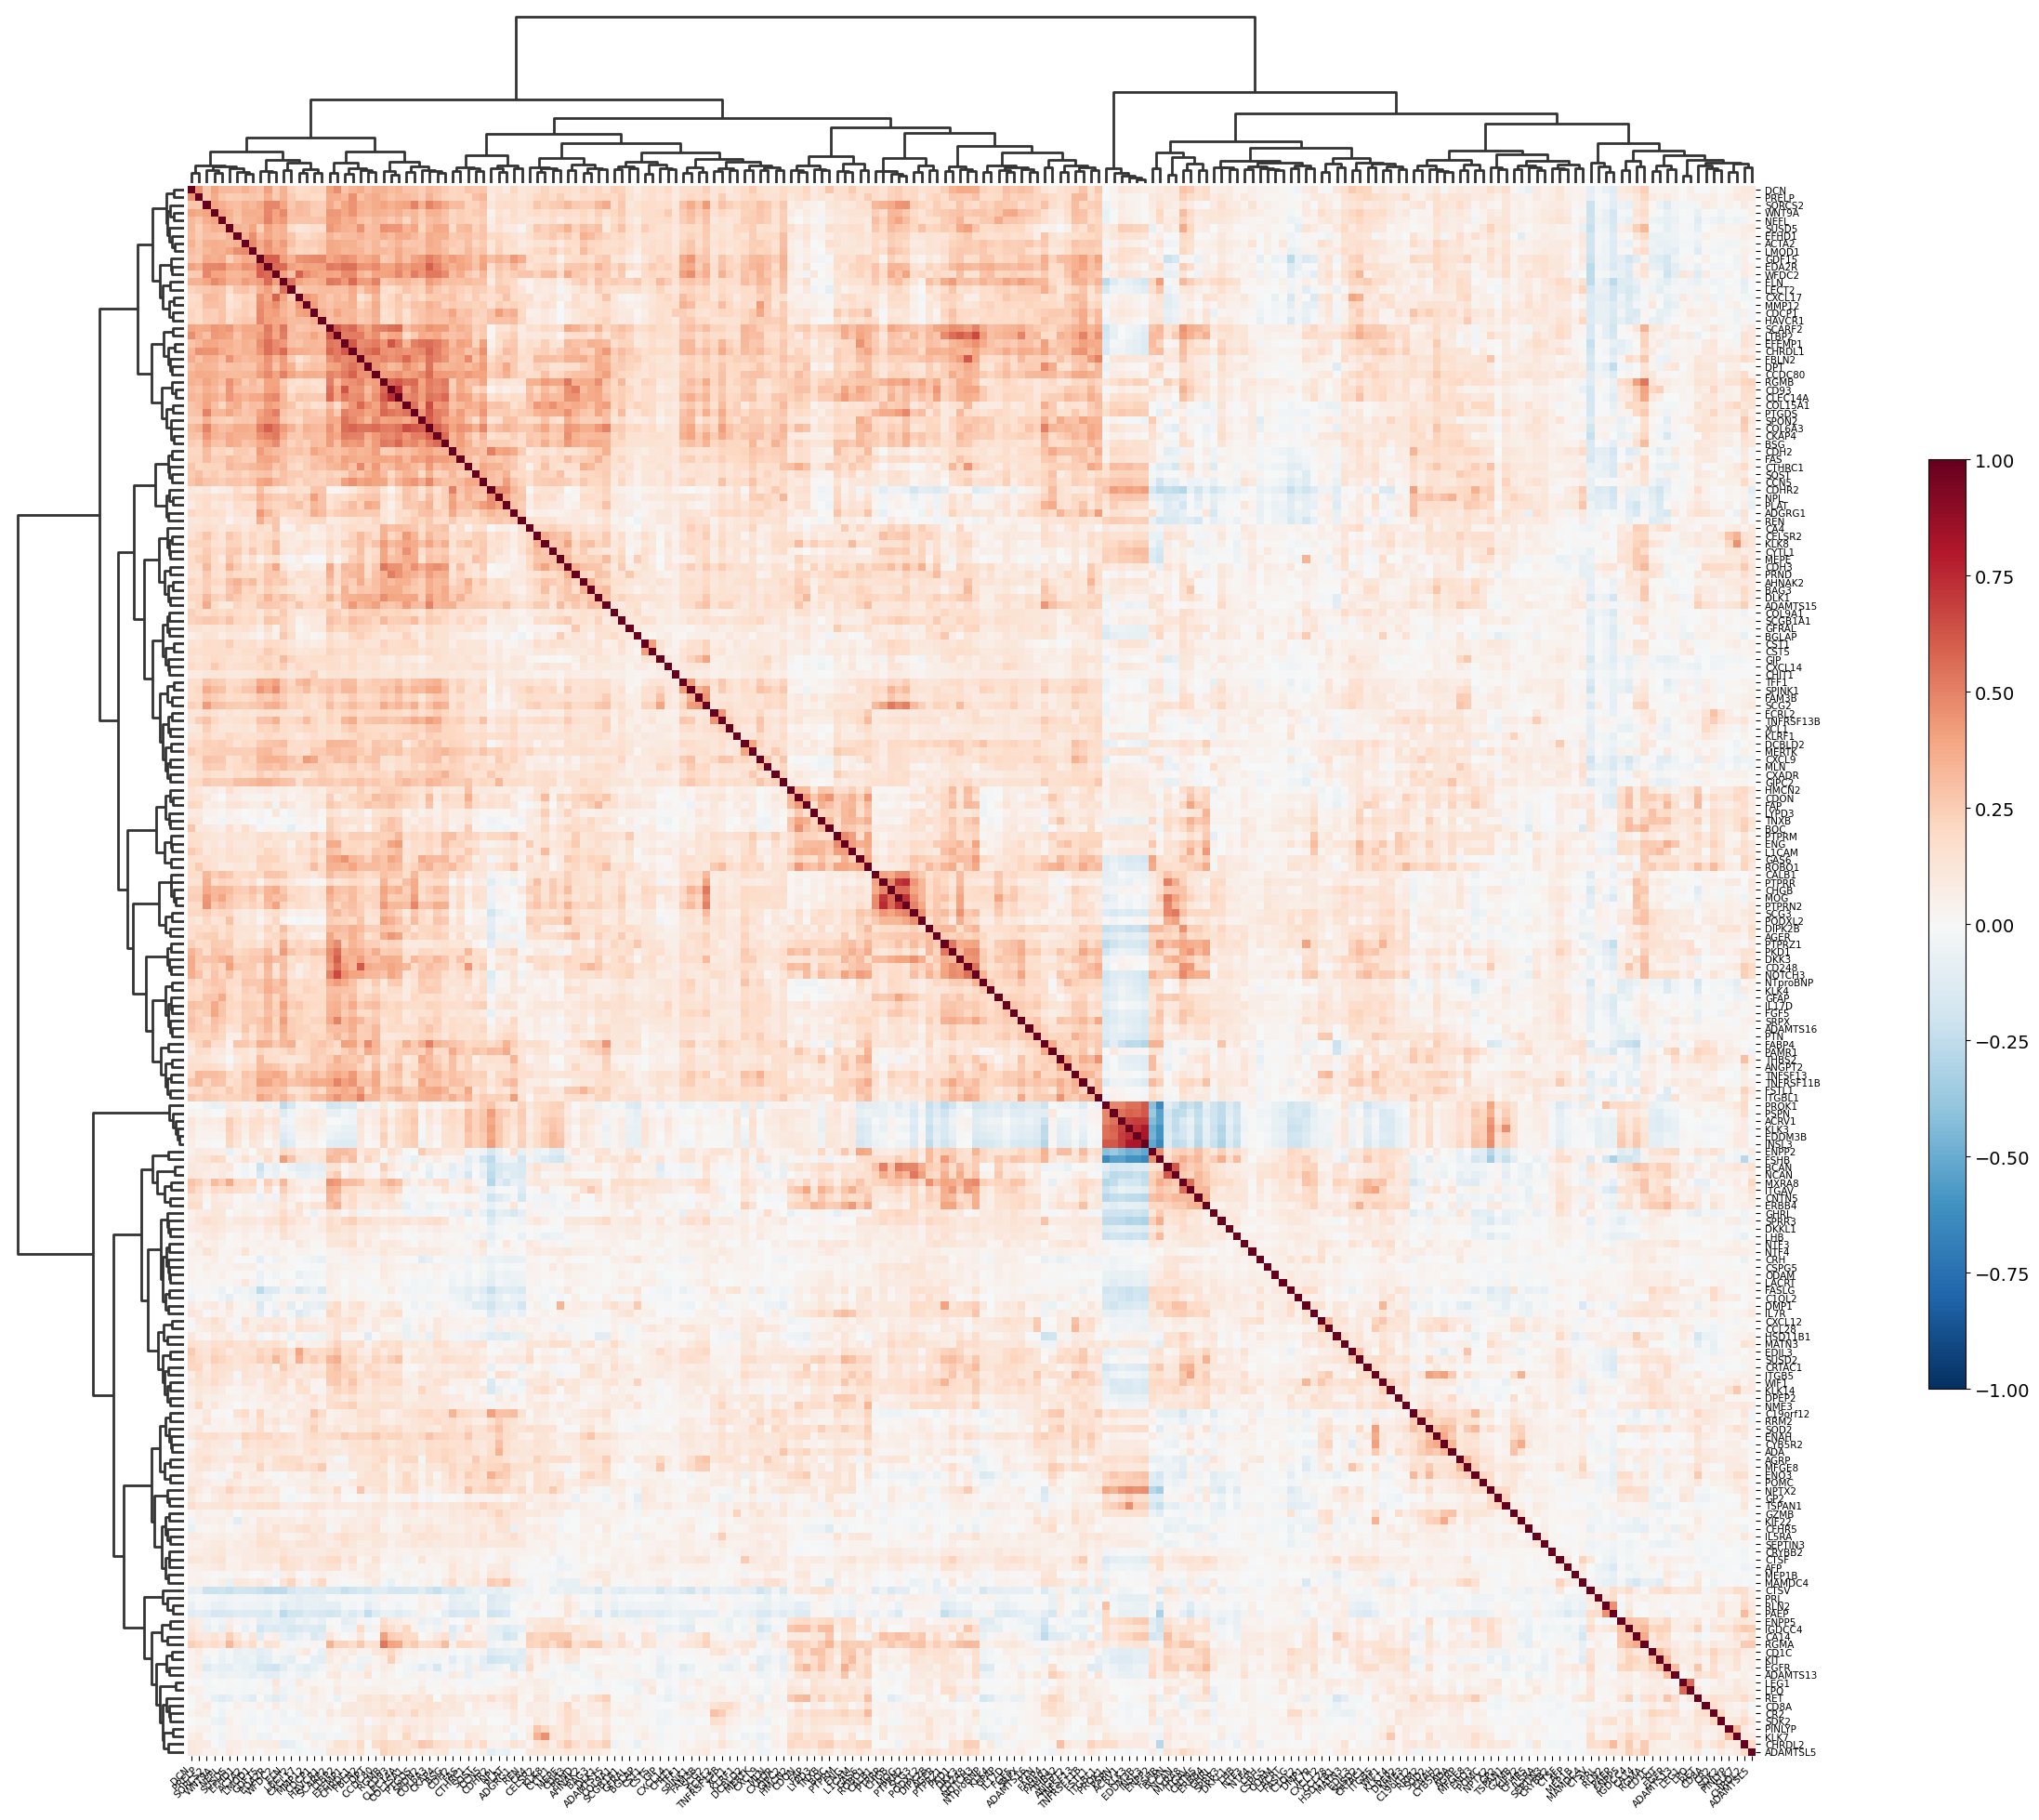

In [59]:
import seaborn as sns
from matplotlib.colors import Normalize

norm = Normalize(vmin=-1, vmax=1)
cbar_pos = [1.04, 0.25, 0.02, 0.5]

corr_boruta = corr.loc[comb_proteins, comb_proteins]

# Create a clustered heatmap after filtering
cluster_grid = sns.clustermap(
    corr_boruta, 
    cmap='RdBu_r', 
    vmin=-1,
    vmax=1,
    norm=norm,
    center=0, 
    figsize=(20, 20), 
    method='ward',
    tree_kws={'linewidths': 2},
    dendrogram_ratio=(0.1,0.1),
    cbar_pos=None,
    annot=False,
    yticklabels=True,
    xticklabels=True
    )

cluster_grid.ax_heatmap.set_yticklabels(cluster_grid.ax_heatmap.get_yticklabels(), rotation=0, fontsize=7.5)
cluster_grid.ax_heatmap.set_xticklabels(cluster_grid.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=7.5)

cbar_ax = cluster_grid.fig.add_axes(cbar_pos)
cb = ColorbarBase(cbar_ax, cmap='RdBu_r', norm=norm, orientation='vertical', label='')
cb.ax.tick_params(labelsize=14)

# sns.clustermap(
#     corr_sub, 
#     xticklabels=corr_sub.columns,
#     yticklabels=corr_sub.columns,
#     cmap='RdBu_r',
#     annot=False,
#     linewidth=0.5
# )

plt.show()

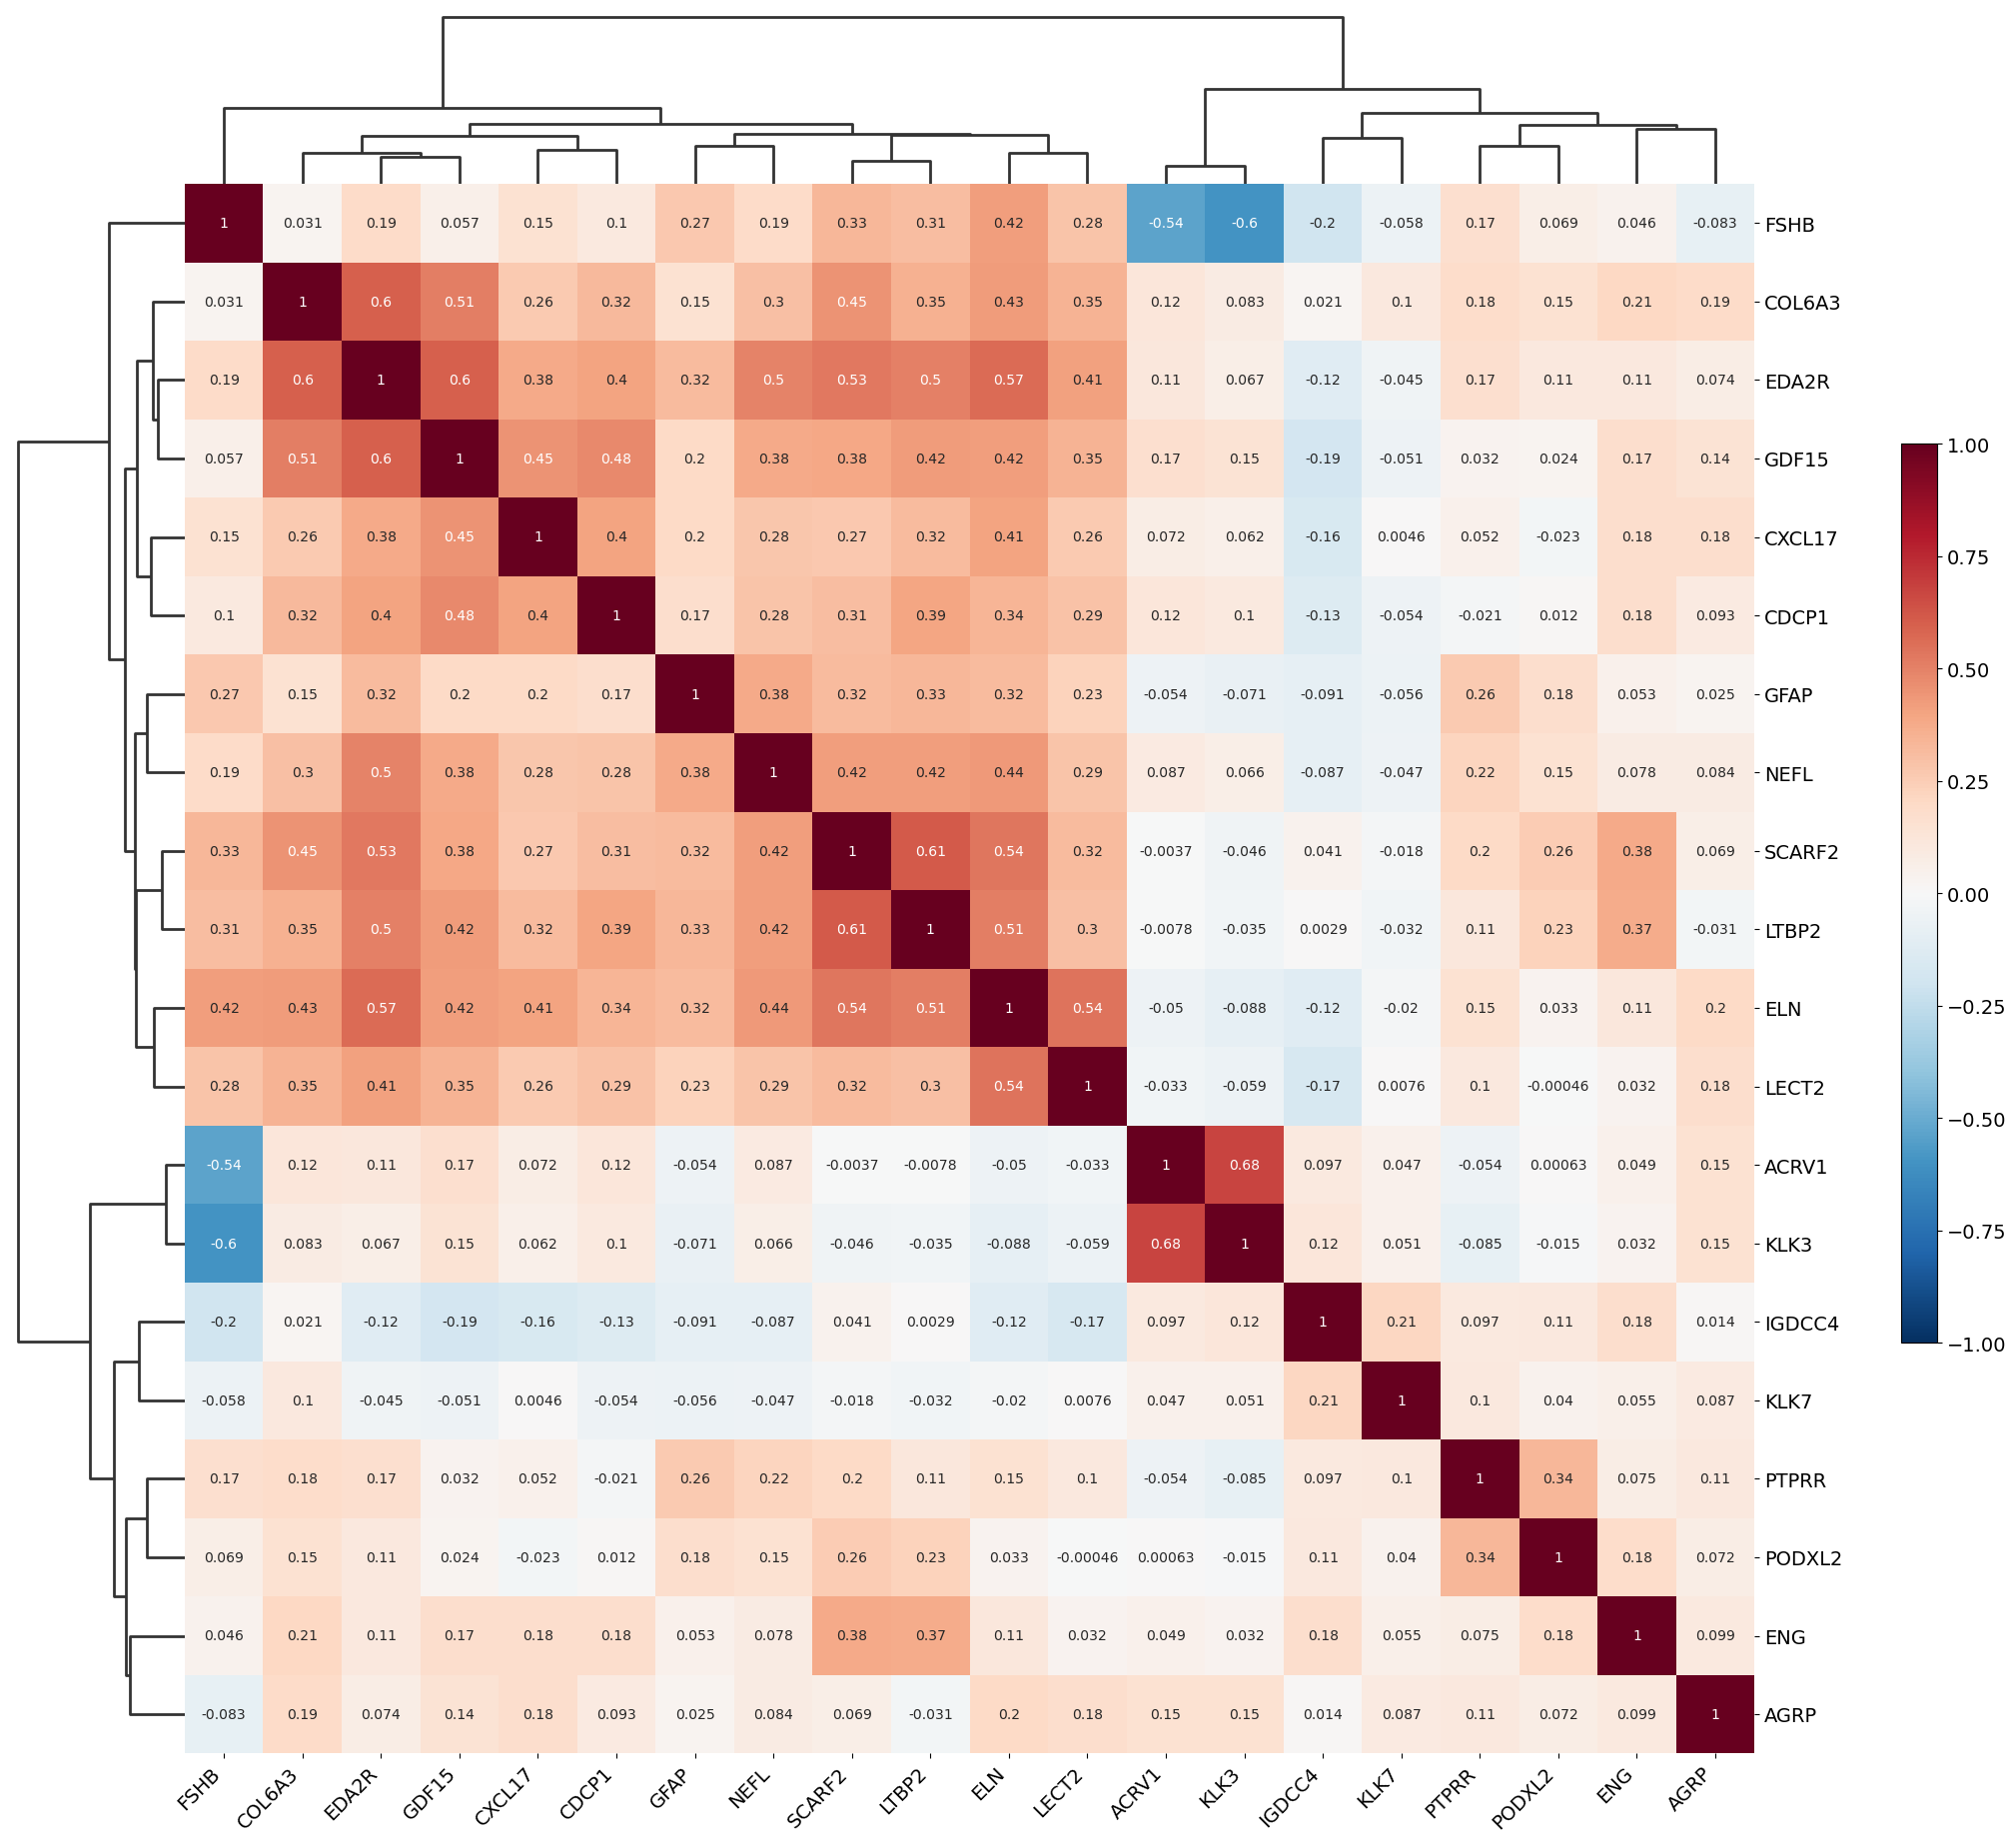

In [57]:
from matplotlib.pyplot import tick_params
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase

norm = Normalize(vmin=-1, vmax=1)
# norm = TwoSlopeNorm(vmin=-10, vcenter=0, vmax=20)

cbar_pos = [1.06, 0.25, 0.02, 0.5]
# Create a clustered heatmap after filtering
cluster_grid = sns.clustermap(
    corr_sub, 
    cmap='RdBu_r', 
    vmin=-1,
    vmax=1,
    norm=norm,
    center=0, 
    figsize=(18, 18), 
    method='ward',
    tree_kws={'linewidths': 2},
    dendrogram_ratio=(0.1,0.1),
    cbar_pos=None,
    annot=True
    )

cluster_grid.ax_heatmap.set_yticklabels(cluster_grid.ax_heatmap.get_yticklabels(), rotation=0, fontsize=14)
cluster_grid.ax_heatmap.set_xticklabels(cluster_grid.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=14)

cbar_ax = cluster_grid.fig.add_axes(cbar_pos)
cb = ColorbarBase(cbar_ax, cmap='RdBu_r', norm=norm, orientation='vertical', label='')
cb.ax.tick_params(labelsize=14)

# sns.clustermap(
#     corr_sub, 
#     xticklabels=corr_sub.columns,
#     yticklabels=corr_sub.columns,
#     cmap='RdBu_r',
#     annot=False,
#     linewidth=0.5
# )

plt.show()

# Descriptive plots

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Define the number of colors
n = 3

# Get the Viridis colormap
cmap = cm.get_cmap('viridis')

# Get the desired colors from Viridis
colors = cmap(np.linspace(0, 1, n))

# Define the disease lists
ds_list = [
    'incident_t2diabetes',
    'incident_IHD',
    'incident_all_stroke',
    'incident_ischemic_stroke',
    'incident_emphysema_COPD',
    'incident_liver',
    'incident_kidney',
    'incident_all_dementia',
    # incident_vasc_dementia,
    'incident_alzheimers',
    'incident_parkinsons',
    'incident_rheumatoid',
    'incident_macular_degen',
    'incident_osteoporosis',
    'incident_osteoarthritis'
]

prev_list = [
    'prevalent_t2diabetes',
    'prevalent_IHD',
    'prevalent_all_stroke',
    'prevalent_ischemic_stroke',
    'prevalent_emphysema_COPD',
    'prevalent_liver',
    'prevalent_kidney',
    'prevalent_all_dementia',
    # prevalent_vasc_dementia,
    'prevalent_alzheimers',
    'prevalent_parkinsons',
    'prevalent_rheumatoid',
    'prevalent_macular_degen',
    'prevalent_osteoporosis',
    'prevalent_osteoarthritis'
]

disease_list2 = [
    "Type II diabetes",
    "Ischemic heart disease",
    "All stroke",
    "Ischemic stroke",
    "Emphysema, COPD",
    "Chronic liver diseases",
    "Chronic kidney diseases",
    "All-cause dementia",
    # "Vascular dementia",
    "Alzheimer's disease",
    "Parkinson's disease",
    "Rheumatoid arthritis",
    "Macular degeneration",
    "Osteoporosis",
    "Osteoarthritis"
]

# Get the counts of prevalent and incident cases for each disease
prev_counts = [survival_data[prev].sum() for prev in prev_list]
ds_counts = [survival_data[ds].sum() for ds in ds_list]

# Combine the disease names and counts into a list of tuples
data = list(zip(disease_list2, prev_counts, ds_counts))

# Sort the data based on the sum of prevalent and incident cases
sorted_data = sorted(data, key=lambda x: sum(x[1:]), reverse=True)

# Unpack the sorted data into separate lists
sorted_diseases, sorted_prev_counts, sorted_ds_counts = zip(*sorted_data)


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


### Fig. 2

In [ ]:
# see Figure_2.ipynb


sex
Female    24579
Male      20862
Name: count, dtype: int64
is_female
Yes    2137
No     1840
Name: count, dtype: int64
ethnicity
White    42320
Black     1114
Asian     1016
Other      554
Mixed      293
Name: count, dtype: int64
region_code
Harbin (Urban)      598
Henan (Rural)       493
Hunan (Rural)       462
Qingdao (Urban)     415
Gansu (Rural)       397
Liuzhou (Urban)     379
Zhejiang (Rural)    342
Sichuan (Rural)     341
Haikou (Urban)      298
Suzhou (Urban)      252
Name: count, dtype: int64


### Lists

In [11]:
disease_list = [
    "All-cause mortality",
    "Type II diabetes",
    "Ischemic heart disease",
    "All stroke",
    # "Intracerebral hemorrhage",
    # "Subarachnoid hemorrhage",
    "Ischemic stroke",
    "Emphysema, COPD",
    "Chronic liver diseases",
    "Chronic kidney diseases",
    "All-cause dementia",
    "Alzheimer's disease",
    "Parkinson's disease",
    "Rheumatoid arthritis",
    "Macular degeneration",
    "Osteoporosis",
    "Osteoarthritis"
]

events_list = [
    'ACM_event_indicator',
    't2diabetes',
    'IHD',
    'all_stroke',
    # 'IH_stroke',
    # 'SH_stroke',
    'ischemic_stroke',
    'emphysema_COPD',
    'liver',
    'kidney',
    'all_dementia',
    'alzheimers',
    'parkinsons',
    'rheumatoid',
    'macular_degen',
    'osteoporosis',
    'osteoarthritis'
]

times_list = [
    'ACM_survival_time',
    't2diabetes_survival_time',
    'IHD_survival_time',
    'all_stroke_survival_time',
    # 'IH_stroke_survival_time',
    # 'SH_stroke_survival_time',
    'ischemic_stroke_survival_time',
    'emphysema_COPD_survival_time',
    'liver_survival_time',
    'kidney_survival_time',
    'all_dementia_survival_time',
    'alzheimers_survival_time',
    'parkinsons_survival_time',
    'rheumatoid_survival_time',
    'macular_degen_survival_time',
    'osteoporosis_survival_time',
    'osteoarthritis_survival_time'
]

cancers = [
    'breast_cancer',
    'lung_cancer',
    'prostate_cancer',
    'colorectal_cancer',
    # 'skin_cancer',
    'nh_lymphoma',
    'pancreatic_cancer',
    # 'kidney_cancer',
    # 'bladder_cancer',
    # 'oral_cancer',
    # 'uterus_cancer',
    'leukemia',
    'eso_cancer',
    'ovarian_cancer',
    'liver_cancer',
    # 'stomach_cancer',
    # 'myeloma',
    # 'secondary_cancer',
    'brain_cancer',
    # 'thyroid_cancer',
    # 'cervical_cancer',
    # 'mesothelioma',
    # 'testicular_cancer',
    'h_lymphoma'
    # 'larynx_cancer',
    # 'CUP_cancer'
]

# disease column names
comb_events = events_list + cancers
disease_columns = [f'{x}_event' for x in comb_events if x != 'ACM_event_indicator']

# Sum across the specified disease columns (axis=1) to get row sums (occurrences of 1)
survival_data['disease_count'] = survival_data[disease_columns].sum(axis=1)

# Function to recode counts into categorical values
def recode_to_categorical(count):
    if count >= 4:
        return '4+'
    else:
        return f'{count}'

# Apply the recode function to the result series
survival_data['disease_count'] = pd.Categorical(survival_data['disease_count'].apply(recode_to_categorical))


### Multimorbidity

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

from scipy.stats import pearsonr, mannwhitneyu, ttest_ind
from sklearn.metrics import r2_score
from matplotlib.ticker import FuncFormatter
from statannotations.Annotator import Annotator


sns.set_style("ticks")

# Create a new figure and specify the layout using gridspec
ccm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(19*ccm, 18*ccm), dpi=600)
gs = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[1,1], height_ratios=[2, 2], wspace=0.3, hspace=0.3)

def filter_outliers(df, column):
    mean = df[column].mean()
    std = df[column].std()
    return df[(df[column] >= mean - 2 * std) & (df[column] <= mean + 2 * std)]

def add_stat_annotation(ax, x1, x2, y, h, p_value, font_size):
    if p_value < 0.001:
        stars = '***'
    elif p_value < 0.01:
        stars = '**'
    elif p_value < 0.05:
        stars = '*'
    else:
        stars = 'n.s.'  # Not significant

    ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, color='black')
    if stars == 'n.s.':
        ax.text((x1 + x2) * .5, y + (h + 0.1), stars, ha='center', va='bottom', color='black', fontsize=font_size)
    else:
        ax.text((x1 + x2) * .5, y + h/2, stars, ha='center', va='bottom', color='black', fontsize=font_size)

# plot a: age plot in both
ax = plt.subplot(gs[0, 0], aspect='auto')  # Span the entire left column
ax.set_title('a', fontweight='bold', loc='left', fontsize=14)
ax.set_title('Multimorbidity (40-50 years)', fontsize=10)

# Calculate mean age_diff for each category of disease_count
mean_age_diff = below_50_df.groupby('disease_count')['age_diff'].mean()
std_err_age_diff = below_50_df.groupby('disease_count')['age_diff'].sem()

# remove 0 category
mean_age_diff = mean_age_diff.drop('0')
std_err_age_diff = std_err_age_diff.drop('0')

df = filter_outliers(below_50_df, 'ProtAgeGap')
print(len(df.index))
print(df['disease_count'].value_counts())

t_stat1, p_value1 = ttest_ind(df.loc[df['disease_count'] == '0', 'ProtAgeGap'], df.loc[df['disease_count'] == '1', 'ProtAgeGap'])
t_stat2, p_value2 = ttest_ind(df.loc[df['disease_count'] == '0', 'ProtAgeGap'], df.loc[df['disease_count'] == '2', 'ProtAgeGap'])
t_stat3, p_value3 = ttest_ind(df.loc[df['disease_count'] == '0', 'ProtAgeGap'], df.loc[df['disease_count'] == '3', 'ProtAgeGap'])
t_stat4, p_value4 = ttest_ind(df.loc[df['disease_count'] == '0', 'ProtAgeGap'], df.loc[df['disease_count'] == '4+', 'ProtAgeGap'])

ax = sns.violinplot(
    data=df,
    y='ProtAgeGap',
    x='disease_count',
    cut=0,
    palette="colorblind"
)

# Add annotations
font_size = 7
y, h = df['ProtAgeGap'].max() + 1, 0.5  # y location of the annotation and height of the line
add_stat_annotation(ax, 0, 1, y, h, p_value1, font_size)
add_stat_annotation(ax, 0, 2, y + 1.5, h, p_value2, font_size)
add_stat_annotation(ax, 0, 3, y + 3, h, p_value3, font_size)
add_stat_annotation(ax, 0, 4, y + 4.5, h, p_value4, font_size)

# # Adding error bars to the bar plot
# for i, category in enumerate(mean_age_diff.index, start=1):
#     if category != 0:
#         plt.errorbar(i-1, mean_age_diff.loc[category], yerr=std_err_age_diff.loc[category], color='black', capsize=2, linewidth=1)

# set y axis ticks
# ax.set_yticks(np.arange(0, 2.1, 0.4))

# # Create a horizontal line at y=0
# plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

plt.xlabel("")
plt.ylabel("ProtAgeGap (years)")


# plot b: mortality age in both
ax = plt.subplot(gs[1, 0], aspect='auto')  # Span the entire left column
ax.set_title('b', fontweight='bold', loc='left', fontsize=14)
ax.set_title('Multimorbidity (51-65 years)', fontsize=10)

# Calculate mean age_diff for each category of disease_count
mean_age_diff = above_50_df.groupby('disease_count')['age_diff'].mean()
std_err_age_diff = above_50_df.groupby('disease_count')['age_diff'].sem()

# remove 0 category
mean_age_diff = mean_age_diff.drop('0')
std_err_age_diff = std_err_age_diff.drop('0')

df = filter_outliers(above_50_df, 'ProtAgeGap')
print(len(df.index))
print(df['disease_count'].value_counts())

t_stat1, p_value1 = ttest_ind(df.loc[df['disease_count'] == '0', 'ProtAgeGap'], df.loc[df['disease_count'] == '1', 'ProtAgeGap'])
t_stat2, p_value2 = ttest_ind(df.loc[df['disease_count'] == '0', 'ProtAgeGap'], df.loc[df['disease_count'] == '2', 'ProtAgeGap'])
t_stat3, p_value3 = ttest_ind(df.loc[df['disease_count'] == '0', 'ProtAgeGap'], df.loc[df['disease_count'] == '3', 'ProtAgeGap'])
t_stat4, p_value4 = ttest_ind(df.loc[df['disease_count'] == '0', 'ProtAgeGap'], df.loc[df['disease_count'] == '4+', 'ProtAgeGap'])

ax = sns.violinplot(
    data=df,
    y='ProtAgeGap',
    x='disease_count',
    cut=0,
    palette="colorblind"
)

# Add annotations
font_size = 7
y, h = df['ProtAgeGap'].max() + 1, 0.5  # y location of the annotation and height of the line
add_stat_annotation(ax, 0, 1, y, h, p_value1, font_size)
add_stat_annotation(ax, 0, 2, y + 1.5, h, p_value2, font_size)
add_stat_annotation(ax, 0, 3, y + 3, h, p_value3, font_size)
add_stat_annotation(ax, 0, 4, y + 4.5, h, p_value4, font_size)


# # Create a horizontal line at y=0
# plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

plt.xlabel("")
plt.ylabel("ProtAgeGap (years)")

# plot c: disease counts in UKB
ax = plt.subplot(gs[0, 1], aspect='auto')
ax.set_title('c', fontweight='bold', loc='left', fontsize=14)
ax.set_title('Multimorbidity rates', fontsize=10)

# ax = sns.barplot(
#     x=mean_age_diff.index,
#     y=mean_age_diff.values,
#     linewidth=1,
#     edgecolor='black',
#     palette="colorblind"
# )

# Define the number of colors
n = 3
# Get the Viridis colormap
cmap = cm.get_cmap('viridis')
# Get the desired colors from Viridis
colors = cmap(np.linspace(0, 1, n))

# combine two age groups
above_50_df['group'] = '51-65 years'
below_50_df['group'] = '40-50 years'
comb_dat = pd.concat([above_50_df, below_50_df])
comb_dat['disease_count'] = pd.Categorical(comb_dat['disease_count'], categories=['0', '1', '2', '3', '4+'])

ax = sns.histplot(
    data=comb_dat,
    x='disease_count', 
    hue='group',
    multiple="dodge", 
    stat='density',
    shrink=0.8, 
    common_norm=False,
    linewidth=1,
    edgecolor='black',
    palette=colors[0:2]
)


# Modify y-axis labels to display percentages
ticks = ax.get_yticks()
ax.set_yticklabels(['{:.0f}'.format(x * 100) for x in ticks])

# Manually create legend handles and labels
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors[0:2]]
labels = ['51-65 years', '40-50 years']

# Add the legend to the plot with frameon=False to remove the border
legend = ax.legend(handles, labels, frameon=False)

# Set edgecolor for the legend rectangles (adding the border)
for rect in legend.legendHandles:
    rect.set_edgecolor('black')
    
plt.xlabel("")
plt.ylabel("Percent (%) of participants")


# # Adding error bars to the bar plot
# for i, category in enumerate(desired_order):
#     plt.errorbar(i, mean_age_diff[category], yerr=std_err_age_diff[category], color='black', capsize=4, linewidth=1)

# # # Create a horizontal line at y=0
# plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

# # plot d: R2 plot in UKB
ax = plt.subplot(gs[1, 1], aspect='auto')
ax.set_title('d', fontweight='bold', loc='left', fontsize=14)
ax.set_title('Self-rated health', fontsize=10)

# Calculate mean age_diff for each category of overall_health

mean_age_diff = survival_data.groupby('overall_health')['ProtAgeGap'].mean()
std_err_age_diff = survival_data.groupby('overall_health')['ProtAgeGap'].sem()

# Define the desired order of x-axis categories
desired_order = ['Excellent', 'Good', 'Fair', 'Poor']

# Reindex the mean_age_diff Series to the desired order
mean_age_diff = mean_age_diff.reindex(desired_order)

df = filter_outliers(survival_data, 'ProtAgeGap')
print(len(df.index))
print(df['overall_health'].value_counts())

t_stat1, p_value1 = ttest_ind(df.loc[df['overall_health'] == 'Poor', 'ProtAgeGap'], df.loc[df['overall_health'] == 'Fair', 'ProtAgeGap'])
t_stat2, p_value2 = ttest_ind(df.loc[df['overall_health'] == 'Poor', 'ProtAgeGap'], df.loc[df['overall_health'] == 'Good', 'ProtAgeGap'])
t_stat3, p_value3 = ttest_ind(df.loc[df['overall_health'] == 'Poor', 'ProtAgeGap'], df.loc[df['overall_health'] == 'Excellent', 'ProtAgeGap'])

ax = sns.violinplot(
    data=df,
    y='ProtAgeGap',
    x='overall_health',
    cut=0,
    palette="colorblind"
)

# Add annotations
font_size = 7
y, h = df['ProtAgeGap'].max() + 1, 0.5  # y location of the annotation and height of the line
add_stat_annotation(ax, 0, 1, y, h, p_value1, font_size)
add_stat_annotation(ax, 0, 2, y + 1.5, h, p_value2, font_size)
add_stat_annotation(ax, 0, 3, y + 3, h, p_value3, font_size)

# Adding error bars to the bar plot
# for i, category in enumerate(desired_order):
#     plt.errorbar(i, mean_age_diff[category], yerr=std_err_age_diff[category], color='black', capsize=2, linewidth=1)

# # Create a horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.ylabel("ProtAgeGap (years)")
plt.xlabel("")



### final steps
# Adjust the layout
plt.tight_layout()

# Show the plot
# plt.show()

# save
# name = f'{filepath}output/multimorbidity_descriptive_{now}.png'
name = '.../Figures/Ext_data_fig_6.jpg'
plt.savefig(
    name,
    # format='pdf',
    dpi=600,
    facecolor='white',
    transparent=False,
    bbox_inches="tight"
)
plt.close()

9809
0     6822
1     2054
2      607
3      206
4+     120
Name: disease_count, dtype: int64
24445
0     10638
1      6907
2      3753
3      1720
4+     1427
Name: disease_count, dtype: int64


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
FixedFormatter should only be used together with FixedLocator
The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.


43393
Good         24752
Fair          9355
Excellent     7004
Poor          2249
Name: overall_health, dtype: int64


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


### Venn - DNAm

In [38]:
from matplotlib_venn import venn2, venn2_circles
import matplotlib.pyplot as plt

# load list of CpGs from Levine PhenoAge
cpg_path = f'{filepath}data/Levine_PhenoAge_cpgs.csv'
PhenoAge_df = pd.read_csv(cpg_path)
# remove intercept column
PhenoAge_df = PhenoAge_df.loc[PhenoAge_df['CpG'] != "Intercept", :]

PhenoAge_genes = list(PhenoAge_df['Gene Symbol'])

# load list of CpGs from Horvath clock
cpg_path = f'{filepath}data/Horvath_clock_cpgs.csv'
HorvathAge_df = pd.read_csv(cpg_path, skiprows=2)

# remove intercept column
HorvathAge_df = HorvathAge_df.loc[HorvathAge_df['CpGmarker'] != "(Intercept)", :]
Horvath_genes = list(HorvathAge_df['Symbol'])

# load list of CpGs from DunedinPACE
cpg_path = f'{filepath}data/DunedinPACE_genes.csv'
DunedinPACE_df = pd.read_csv(cpg_path)

# select gene names
DunedinPACE_genes = list(DunedinPACE_df['UCSC_RefGene_Name'])
# remove nan
DunedinPACE_genes = [x for x in DunedinPACE_genes if str(x) != 'nan']

<Figure size 600x600 with 0 Axes>

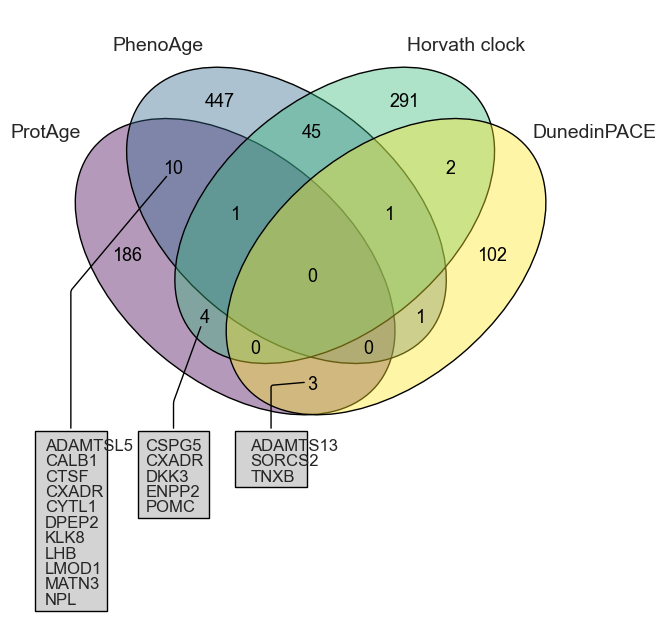

In [18]:
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted, venn3_circles
from venn import venn

list_dict = {
    'ProtAge': set(comb_proteins), 
    'PhenoAge': set(PhenoAge_genes), 
    'Horvath clock': set(Horvath_genes),
    'DunedinPACE': set(DunedinPACE_genes)
}

# Set the plot size and create a new figure
plt.figure(figsize=(6, 6))
venn_diagram = venn(list_dict)

# Remove the legend
venn_diagram.get_legend().set_visible(False)

# Add text labels outside each leaf
plt.text(-0.02, 0.65, 'ProtAge', ha='center', fontsize=14)
plt.text(0.2, 0.82, 'PhenoAge', ha='center', fontsize=14)
plt.text(0.8, 0.82, 'Horvath clock', ha='center', fontsize=14)
plt.text(1.05, 0.65, 'DunedinPACE', ha='center', fontsize=14)

# get overlapping genes
int1 = list(set(comb_proteins).intersection(set(PhenoAge_genes)))
int2 = list(set(comb_proteins).intersection(set(Horvath_genes)))
int3 = list(set(comb_proteins).intersection(set(DunedinPACE_genes)))

# sort
int1.sort()
int2.sort()
int3.sort()

### box 1

# Set the boundaries of the box for the text annotations
x_offset = 0.06
y_offset = -0.03
box_left = x_offset - 0.1
box_right = x_offset + 0.04

# Calculate the new box_top
box_top = 0.08
box_bottom = box_top - ((len(int1)) * abs(y_offset) + 0.02)

# Plot a rectangle to represent the box
plt.fill([box_left, box_right, box_right, box_left], [box_top, box_top, box_bottom, box_bottom], 'lightgrey')

# Adjust the y-axis limits to include the box
plt.ylim(box_bottom - abs(y_offset), 0.9)

# Add text annotations for set1_only
# x_offset = -0.22
x_offset = -0.02
y_offset = -0.03
for i, element in enumerate(int1):
    # plt.text(x_offset, .4 + (i + 1) * y_offset, element, ha='left', va='center')
    plt.text(x_offset, 0.08 + (i + 1) * y_offset, element, fontsize=12, ha='left', va='center')

# Draw a bent arrow from the box to a coordinate on the plot with a 45-degree angle
arrow_end_x = 0.22  # X-coordinate where the arrow should end
arrow_end_y = 0.58  # Y-coordinate where the arrow should end
arrow_start = ((box_left + (box_right - box_left)/2), box_top)
arrow_end = (arrow_end_x, arrow_end_y)

arrow = plt.annotate(
    '',
    xy=arrow_end, 
    xytext=arrow_start, 
    arrowprops=dict(
        arrowstyle='-', 
        lw=1, 
        # connectionstyle="arc3,rad=-0.3",
        connectionstyle="angle, angleA=-90, angleB=50, rad=2",
        color='black'
    )
)

### box 2

# Set the boundaries of the box for the text annotations
x_offset = 0.26
y_offset = -0.03
box_left = x_offset - 0.1
box_right = x_offset + 0.04

# Calculate the new box_top
box_top = 0.08
box_bottom = box_top - (len(int2) * abs(y_offset) + 0.02)

# Plot a rectangle to represent the box
plt.fill([box_left, box_right, box_right, box_left], [box_top, box_top, box_bottom, box_bottom], 'lightgrey')

# Add text annotations for set1_only
# x_offset = -0.22
x_offset = 0.175
y_offset = -0.03
for i, element in enumerate(int2):
    # plt.text(x_offset, .4 + (i + 1) * y_offset, element, ha='left', va='center')
    plt.text(x_offset, 0.08 + (i + 1) * y_offset, element, fontsize=12, ha='left', va='center')

# Draw a bent arrow from the box to a coordinate on the plot with a 45-degree angle
arrow_end_x = 0.285  # X-coordinate where the arrow should end
arrow_end_y = 0.288  # Y-coordinate where the arrow should end
arrow_start = ((box_left + (box_right - box_left)/2), box_top)
arrow_end = (arrow_end_x, arrow_end_y)

arrow = plt.annotate(
    '',
    xy=arrow_end, 
    xytext=arrow_start, 
    arrowprops=dict(
        arrowstyle='-', 
        lw=1, 
        # connectionstyle="arc3,rad=-0.3",
        connectionstyle="angle, angleA=-90, angleB=70, rad=2",
        color='black'
    )
)

### box 3

# Set the boundaries of the box for the text annotations
x_offset = 0.45
y_offset = -0.03
box_left = x_offset - 0.1
box_right = x_offset + 0.04

# Calculate the new box_top
box_top = 0.08
box_bottom = box_top - (len(int3) * abs(y_offset) + 0.02)

# Plot a rectangle to represent the box
plt.fill([box_left, box_right, box_right, box_left], [box_top, box_top, box_bottom, box_bottom], 'lightgrey')

# Add text annotations for set1_only
# x_offset = -0.22
x_offset = 0.38
y_offset = -0.03
for i, element in enumerate(int3):
    # plt.text(x_offset, .4 + (i + 1) * y_offset, element, ha='left', va='center')
    plt.text(x_offset, 0.08 + (i + 1) * y_offset, element, fontsize=12, ha='left', va='center')

# Draw a bent arrow from the box to a coordinate on the plot with a 45-degree angle
arrow_end_x = 0.49  # X-coordinate where the arrow should end
arrow_end_y = 0.175  # Y-coordinate where the arrow should end
arrow_start = ((box_left + (box_right - box_left)/2), box_top)
arrow_end = (arrow_end_x, arrow_end_y)

arrow = plt.annotate(
    '',
    xy=arrow_end, 
    xytext=arrow_start, 
    arrowprops=dict(
        arrowstyle='-', 
        lw=1, 
        # connectionstyle="arc3,rad=-0.3",
        connectionstyle="angle, angleA=90, angleB=5, rad=2",
        color='black'
    )
)

# Set the outline color of each leaf to black
for patch in venn_diagram.patches:
    patch.set_edgecolor('black')

# plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
int2

## Venn - proteins

In [39]:

# taken from table 2 in: https://doi.org/10.1016/j.arr.2020.101070
lehallier_review_proteins = [
    'ALB',
    'ANXA1',
    'ANXA2',
    'ATP5F1B',
    'C3',
    'C4A',
    'CAPNS1',
    'COL18A1',
    'COL1A1',
    'CTSS',
    'EGFR',
    'FGA',
    'FGG',
    'FN1',
    'GDF15',
    'GOT1',
    'GSTP1',
    'HGF',
    'HNRNPDL',
    'HP',
    'LAMC1',
    'LRP1',
    'MMP12',
    'PARK7',
    'PLAUR',
    'PTN',
    'TF',
    'TMPO',
    'TNFRSF1A',
    'TNFRSF1B',
    'TPI1',
    'VEGFA'
]
    

# load list of proteins used in clock from Johnson 2020 review paper: 
prot_path = f'{filepath}data/johnson_2020_clock_proteins.csv'
johnson_review_clock_df = pd.read_csv(prot_path)
johnson_review_clock = list(johnson_review_clock_df['Proteins'])

# load list of proteins from Lehallier 2023 paper: 
prot_path = f'{filepath}data/Lehallier_2023_aging_proteins.csv'
lehallier_AP_df = pd.read_csv(prot_path, skiprows=1)

lehallier_AP = list(lehallier_AP_df['Gene'])


lehallier_15_AP = [
    'CR2',
    'CRTAC1',
    'FMOD',
    'CCL21',
    'MSMP',
    'IGF2R',
    'PTPRD',
    'MXRA8',
    'IL22RA2',
    'WISP2',
    'CTSV',
    'ADAMTSL1',
    'PTGDS',
    'CD248',
    'ENPP7'
]




In [40]:
path = f'{filepath}data/lehallier_nature_med_2019_clock.csv'
lehallier_nat_med_clock_df = pd.read_csv(path, skiprows=2)

# subset to those significant in their model
lehallier_nat_med_clock_df = lehallier_nat_med_clock_df.loc[lehallier_nat_med_clock_df['Coefficients full model (373 proteins)'] != 0, :]

path = f'{filepath}data/lehallier_nature_med_2019_nomenclature.csv'
lehallier_nat_med_map_df = pd.read_csv(path, skiprows=2)
lehallier_nat_med_map_df

# subset to those in the clock
lehallier_nat_med_map_df = lehallier_nat_med_map_df.loc[lehallier_nat_med_map_df['ID'].isin(lehallier_nat_med_clock_df['Variable']), :]

# check (should be 373)
len(lehallier_nat_med_map_df.index)

# get gene names
lehallier_nat_med_genes = list(lehallier_nat_med_map_df['EntrezGeneSymbol'])


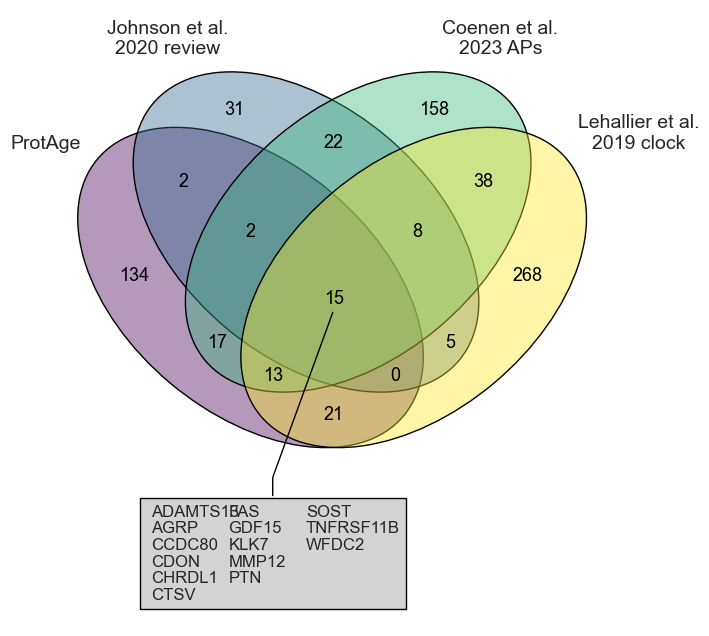

In [21]:
from venn import venn

list_dict = {
    'ProtAge': set(comb_proteins), 
    'Lehallier review': set(johnson_review_clock), 
    'Lehallier age proteins': set(lehallier_AP),
    'Lehallier age clock subset': set(lehallier_nat_med_genes)
}

# find proteins with overlap with other two papers
overlap = [x for x in comb_proteins if x in lehallier_nat_med_genes]
overlap = [x for x in overlap if x in lehallier_AP]
overlap = [x for x in overlap if x in johnson_review_clock]

# sort
overlap.sort()

# make venn diagram
venn_diagram = venn(list_dict)

# Remove the legend
venn_diagram.get_legend().set_visible(False)

# Add text labels outside each leaf
plt.text(-0.02, 0.65, 'ProtAge', ha='center', fontsize=14)
plt.text(0.2, 0.82, 'Johnson et al.\n2020 review', ha='center', fontsize=14)
plt.text(0.8, 0.82, 'Coenen et al.\n2023 APs', ha='center', fontsize=14)
plt.text(1.05, 0.65, 'Lehallier et al.\n2019 clock', ha='center', fontsize=14)

### box 1

# # Set the boundaries of the box for the text annotations
# x_offset = 0.06
# y_offset = -0.03
# box_left = x_offset - 0.1
# box_right = x_offset + 0.04

# # Calculate the new box_top
# box_top = 0.08
# box_bottom = box_top - ((len(overlap)) * abs(y_offset) + 0.02)

# # Plot a rectangle to represent the box
# plt.fill([box_left, box_right, box_right, box_left], [box_top, box_top, box_bottom, box_bottom], 'lightgrey')

# # Adjust the y-axis limits to include the box
# plt.ylim(box_bottom - abs(y_offset), 0.9)

# Divide the overlap list into three columns
column1 = overlap[0:6]
column2 = overlap[7:12]
column3 = overlap[12:16]

# Set the boundaries of the box for the text annotations
x_offset = 0.15
y_offset = -0.03

# Calculate the new box_top and box_bottom
box_top = 0.02
box_bottom = box_top - (len(column1) * abs(y_offset) + 0.02)

# Plot a rectangle to represent the box
plt.fill([x_offset, x_offset, x_offset + 0.48, x_offset + 0.48], [box_top, box_bottom, box_bottom, box_top], 'lightgrey')

# Adjust the y-axis limits to include the box
plt.ylim(box_bottom - abs(y_offset), 0.9)

# # Add text annotations for set1_only
# x_offset = -0.02
# y_offset = -0.03
# for i, element in enumerate(overlap):
#     # plt.text(x_offset, .4 + (i + 1) * y_offset, element, ha='left', va='center')
#     plt.text(x_offset, 0.08 + (i + 1) * y_offset, element, fontsize=12, ha='left', va='center')

# Add text annotations for set1_only in each column
for i, element in enumerate(column1):
    plt.text(x_offset + 0.02, (box_top - 0.01) + (i + 0.5) * y_offset, element, fontsize=12, ha='left', va='center')

start = x_offset + 0.14  # Shift to the next column
for i, element in enumerate(column2):
    plt.text(start + 0.02, (box_top - 0.01) + (i + 0.5) * y_offset, element, fontsize=12, ha='left', va='center')

start += 0.14  # Shift to the next column
for i, element in enumerate(column3):
    plt.text(start+ 0.02, (box_top - 0.01) + (i + 0.5) * y_offset, element, fontsize=12, ha='left', va='center')


# Draw a bent arrow from the box to a coordinate on the plot with a 45-degree angle
arrow_end_x = 0.5  # X-coordinate where the arrow should end
arrow_end_y = 0.36  # Y-coordinate where the arrow should end
arrow_start = (x_offset + ((x_offset + 0.48) - x_offset)/2, box_top)
arrow_end = (arrow_end_x, arrow_end_y)

arrow = plt.annotate(
    '',
    xy=arrow_end, 
    xytext=arrow_start, 
    arrowprops=dict(
        arrowstyle='-', 
        lw=1, 
        # connectionstyle="arc3,rad=-0.3",
        connectionstyle="angle, angleA=-90, angleB=70, rad=2",
        color='black'
    )
)

# Set the outline color of each leaf to black
for patch in venn_diagram.patches:
    patch.set_edgecolor('black')

## Plot Venn together

In [43]:

sns.set_style("ticks")

# set fig size
# fig = plt.figure(figsize=(30, 40))

# Create the GridSpec with a 3x3 grid
from matplotlib_venn import venn3, venn3_circles, venn3_unweighted, venn3_circles
from venn import venn
import matplotlib.gridspec as gridspec

plt.rcParams.update({'font.size': 8})

list_dict = {
    'ProtAge': set(comb_proteins), 
    'PhenoAge': set(PhenoAge_genes), 
    'Horvath clock': set(Horvath_genes),
    'DunedinPACE': set(DunedinPACE_genes)
}

# Create the subplots using GridSpec
grid = gridspec.GridSpec(
    nrows=1, 
    ncols=2
)

ccm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(24*ccm, 24*ccm), dpi=600)

# First venn
ax1 = fig.add_subplot(grid[0, 0])
ax1.set_title('a', fontweight='bold', fontsize=16, loc='left', y=1.0, pad=20)

ax1.axis('off')  # Hide the axis

venn_diagram = venn(list_dict, ax=ax1)

# Remove the legend
venn_diagram.get_legend().set_visible(False)

# Add text labels outside each leaf
ax1.text(-0.02, 0.65, 'ProtAge', ha='center', fontsize=12)
ax1.text(0.2, 0.82, 'DNAm PhenoAge', ha='center', fontsize=12)
ax1.text(0.8, 0.82, 'Horvath clock', ha='center', fontsize=12)
ax1.text(1.05, 0.69, 'DunedinPACE', ha='center', fontsize=12)

# get overlapping genes
int1 = list(set(comb_proteins).intersection(set(PhenoAge_genes)))
int2 = list(set(comb_proteins).intersection(set(Horvath_genes)))
int3 = list(set(comb_proteins).intersection(set(DunedinPACE_genes)))

# sort
int1.sort()
int2.sort()
int3.sort()

### box 1

# Set the boundaries of the box for the text annotations
x_offset = 0.14
y_offset = -0.03
box_left = x_offset - 0.1
box_right = x_offset + 0.18

# Calculate the new box_top
box_top = 0.02
box_bottom = box_top - ((len(int1)) * abs(y_offset) + 0.3)

# Plot a rectangle to represent the box
ax1.fill([box_left, box_right, box_right, box_left], [box_top, box_top, box_bottom, box_bottom], 'lightgrey')

# Adjust the y-axis limits to include the box
ax1.set_ylim(box_bottom - abs(y_offset), 0.9)
# save to match next grid
ax1_lims = ax1.get_ylim()

# Add text annotations for set1_only
x_offset = 0.06
y_offset = -0.052
for i, element in enumerate(int1):
    # plt.text(x_offset, .4 + (i + 1) * y_offset, element, ha='left', va='center')
    ax1.text(x_offset, box_top + (i + 1) * y_offset, element, fontsize=10, ha='left', va='center')

# Draw a bent arrow from the box to a coordinate on the plot with a 45-degree angle
arrow_end_x = 0.22  # X-coordinate where the arrow should end
arrow_end_y = 0.56  # Y-coordinate where the arrow should end
arrow_start = ((box_left + (box_right - box_left)/2), box_top)
arrow_end = (arrow_end_x, arrow_end_y)

arrow = ax1.annotate(
    '',
    xy=arrow_end, 
    xytext=arrow_start, 
    arrowprops=dict(
        arrowstyle='-', 
        lw=1, 
        connectionstyle="arc3, rad=0",
        color='black'
    )
)

### box 2

# Set the boundaries of the box for the text annotations
x_offset = 0.36
y_offset = -0.03
box_left = x_offset - 0.0
box_right = x_offset + 0.2

# x_offset = 0.06
# y_offset = -0.03
# box_left = x_offset - 0.1
# box_right = x_offset + 0.16

# Calculate the new box_top
box_top = 0.02
box_bottom = box_top - (len(int2) * abs(y_offset) + 0.16)

# Plot a rectangle to represent the box
ax1.fill([box_left, box_right, box_right, box_left], [box_top, box_top, box_bottom, box_bottom], 'lightgrey')

# Add text annotations for set1_only
# x_offset = -0.22
x_offset = 0.38
y_offset = -0.052
for i, element in enumerate(int2):
    # plt.text(x_offset, .4 + (i + 1) * y_offset, element, ha='left', va='center')
    ax1.text(x_offset, box_top + (i + 1) * y_offset, element, fontsize=10, ha='left', va='center')

# Draw a bent arrow from the box to a coordinate on the plot with a 45-degree angle
arrow_end_x = 0.29  # X-coordinate where the arrow should end
arrow_end_y = 0.28  # Y-coordinate where the arrow should end
arrow_start = ((box_left + (box_right - box_left)/2), box_top)
arrow_end = (arrow_end_x, arrow_end_y)

arrow = ax1.annotate(
    '',
    xy=arrow_end, 
    xytext=arrow_start, 
    arrowprops=dict(
        arrowstyle='-', 
        lw=1, 
        connectionstyle="arc3, rad=0",
        color='black'
    )
)

### box 3

# Set the boundaries of the box for the text annotations
x_offset = 0.7
y_offset = -0.03
box_left = x_offset - 0.1
box_right = x_offset + 0.18

# Calculate the new box_top
box_top = 0.02
box_bottom = box_top - (len(int3) * abs(y_offset) + 0.12)

# Plot a rectangle to represent the box
ax1.fill([box_left, box_right, box_right, box_left], [box_top, box_top, box_bottom, box_bottom], 'lightgrey')

# Add text annotations for set1_only
# x_offset = -0.22
x_offset = 0.62
y_offset = -0.052
for i, element in enumerate(int3):
    # plt.text(x_offset, .4 + (i + 1) * y_offset, element, ha='left', va='center')
    ax1.text(x_offset, box_top + (i + 1) * y_offset, element, fontsize=10, ha='left', va='center')

# Draw a bent arrow from the box to a coordinate on the plot with a 45-degree angle
arrow_end_x = 0.51  # X-coordinate where the arrow should end
arrow_end_y = 0.15  # Y-coordinate where the arrow should end
arrow_start = ((box_left + (box_right - box_left)/2), box_top)
arrow_end = (arrow_end_x, arrow_end_y)

arrow = ax1.annotate(
    '',
    xy=arrow_end, 
    xytext=arrow_start, 
    arrowprops=dict(
        arrowstyle='-', 
        lw=1, 
        connectionstyle="arc3, rad=0",
        color='black'
    )
)

# Set the outline color of each leaf to black
for patch in venn_diagram.patches:
    patch.set_edgecolor('black')


# plt.show()

#####

# second venn
ax2 = fig.add_subplot(grid[0, 1])
ax2.set_title('b', fontweight='bold', fontsize=16, loc='left', y=1.0, pad=20)

ax2.axis('off')  # Hide the axis

list_dict = {
    'ProtAge': set(comb_proteins), 
    'Lehallier review': set(johnson_review_clock), 
    'Lehallier age proteins': set(lehallier_AP),
    'Lehallier age clock subset': set(lehallier_nat_med_genes)
}

# find proteins with overlap with other two papers
overlap = [x for x in comb_proteins if x in lehallier_nat_med_genes]
overlap = [x for x in overlap if x in lehallier_AP]
overlap = [x for x in overlap if x in johnson_review_clock]

# sort
overlap.sort()

# make venn diagram
venn_diagram = venn(list_dict, ax=ax2)

# Remove the legend
venn_diagram.get_legend().set_visible(False)

# Add text labels outside each leaf
ax2.text(-0.06, 0.6, 'ProtAge', ha='center', fontsize=12)
ax2.text(0.2, 0.82, 'Johnson et al.\n2020 review', ha='center', fontsize=12)
ax2.text(0.8, 0.82, 'Coenen et al.\n2023 APs', ha='center', fontsize=12)
ax2.text(1.05, 0.65, 'Lehallier et al.\n2019 clock', ha='center', fontsize=12)

### box 1

# Divide the overlap list into three columns
column1 = overlap[0:6]
column2 = overlap[6:12]
column3 = overlap[12:16]

# Set the boundaries of the box for the text annotations
x_offset = 0.2
y_offset = -0.052

# Calculate the new box_top and box_bottom
box_top = 0.02
box_bottom = box_top - (len(column1) * abs(y_offset) + 0.04)

# Plot a rectangle to represent the box
margin = 0.76
ax2.fill([x_offset, x_offset, x_offset + margin, x_offset + margin], [box_top, box_bottom, box_bottom, box_top], 'lightgrey')

# Adjust the y-axis limits to include the box
ax2.set_ylim(ax1_lims)

# # Add text annotations for set1_only
# x_offset = -0.02
# y_offset = -0.03
# for i, element in enumerate(overlap):
#     # plt.text(x_offset, .4 + (i + 1) * y_offset, element, ha='left', va='center')
#     plt.text(x_offset, 0.08 + (i + 1) * y_offset, element, fontsize=12, ha='left', va='center')

# Add text annotations for set1_only in each column
for i, element in enumerate(column1):
    ax2.text(x_offset + 0.02, (box_top - 0.02) + (i + 0.5) * y_offset, element, fontsize=10, ha='left', va='center')

start = x_offset + 0.25  # Shift to the next column
for i, element in enumerate(column2):
    ax2.text(start + 0.04, (box_top - 0.02) + (i + 0.5) * y_offset, element, fontsize=10, ha='left', va='center')

start += 0.18  # Shift to the next column
for i, element in enumerate(column3):
    ax2.text(start + 0.04, (box_top - 0.02) + (i + 0.5) * y_offset, element, fontsize=10, ha='left', va='center')


# Draw a bent arrow from the box to a coordinate on the plot with a 45-degree angle
arrow_end_x = 0.51  # X-coordinate where the arrow should end
arrow_end_y = 0.36  # Y-coordinate where the arrow should end
arrow_start = (x_offset + ((x_offset + margin) - x_offset)/2, box_top)
arrow_end = (arrow_end_x, arrow_end_y)

arrow = ax2.annotate(
    '',
    xy=arrow_end, 
    xytext=arrow_start, 
    arrowprops=dict(
        arrowstyle='-', 
        lw=1, 
        # connectionstyle="arc3,rad=-0.3",
        connectionstyle="angle, angleA=-90, angleB=-65, rad=2",
        color='black'
    )
)

# Set the outline color of each leaf to black
for patch in venn_diagram.patches:
    patch.set_edgecolor('black')

# save
# name = f'{filepath}/output/venn_overlap_{now}.png'
name = '.../Figures/Ext_data_fig_9.jpg'
plt.savefig(
    name,
    # format='pdf',
    dpi=600,
    facecolor='white',
    transparent=False,
    bbox_inches="tight"
)
plt.close()

## Protein overlap table

In [70]:
# find proteins with overlap with other two papers
overlap = [x for x in comb_proteins if x in lehallier_nat_med_genes]
overlap = [x for x in overlap if x in lehallier_AP]
overlap = [x for x in overlap if x in johnson_review_clock]

len(overlap)

15

In [71]:
## proteins matched to uniprotIDs from onlink insight (some gave multiple matches, need to find)
path = '.../ProtAge_proteins_2023-12-29.csv'
uniprot_df = pd.read_csv(path)
uniprot_list = list(uniprot_df["Gene_name"])
len(uniprot_df.index)

204

In [72]:
# make df with protein info for overlap
overlap_df = uniprot_df.loc[uniprot_df['Gene_name'].isin(overlap), :].copy()
overlap_df = overlap_df.drop('mean_SHAP_value', axis=1)

# sort by gene name
overlap_df = overlap_df.sort_values('Gene_name')

# save to file
name = f'{filepath}output/tables/pAge_literature_overlap_{now}.csv'
overlap_df.to_csv(name, index=False)

,Gene_name,Protein_name,UniProt ID
3,ADAMTS13,A disintegrin and metalloproteinase with throm...,Q76LX8
10,AGRP,Agouti-related protein,O00253
23,CCDC80,Coiled-coil domain-containing protein 80,Q76M96
34,CDON,Cell adhesion molecule-related/down-regulated ...,Q4KMG0
39,CHRDL1,Chordin-like protein 1,Q9BU40
56,CTSV,Cathepsin L2,O60911
78,EGFR,Epidermal growth factor receptor,P00533
89,FAS,Tumor necrosis factor receptor superfamily mem...,P25445
97,GDF15,Growth/differentiation factor 15,Q99988
121,KLK7,Kallikrein-7,P49862


In [36]:
# make list of overlap genes
overlap_genes = list(overlap_df['Gene_name'])
overlap_genes

['ADAMTS13',
 'AGRP',
 'CCDC80',
 'CDON',
 'CHRDL1',
 'CTSV',
 'EGFR',
 'FAS',
 'GDF15',
 'KLK7',
 'MMP12',
 'PTN',
 'SOST',
 'TNFRSF11B',
 'WFDC2']

## Full 204 protein overlap sheet

In [74]:
# copy df with uniprot IDs
full_df = uniprot_df.copy()
full_df = full_df.drop('mean_SHAP_value', axis=1)

# Create new columns using lambda functions
full_df['Horvath_overlap'] = full_df['Gene_name'].apply(lambda x: 1 if x in Horvath_genes else 0)
full_df['PhenoAge_overlap'] = full_df['Gene_name'].apply(lambda x: 1 if x in PhenoAge_genes else 0)
full_df['DunedinPACE_overlap'] = full_df['Gene_name'].apply(lambda x: 1 if x in DunedinPACE_genes else 0)
full_df['Johnson_2020_review_overlap'] = full_df['Gene_name'].apply(lambda x: 1 if x in johnson_review_clock else 0)
full_df['Coenen_2023_AP_overlap'] = full_df['Gene_name'].apply(lambda x: 1 if x in lehallier_AP else 0)
full_df['Lehallier_2019_clock_overlap'] = full_df['Gene_name'].apply(lambda x: 1 if x in lehallier_nat_med_genes else 0)

full_df['Coenen_2023_AP_overlap'].value_counts()

# save to file
name = f'{filepath}output/tables/pAge_supplementary_table_1_{now}.csv'
full_df.to_csv(name, index=False)

## Top 20 protein sheet

In [75]:
# Create new columns using lambda functions
top_20_df = full_df[full_df['Gene_name'].isin(top_20_features)]

# save to file
name = f'{filepath}output/tables/pAge_supplementary_table_2_{now}.csv'
top_20_df.to_csv(name, index=False)

In [109]:
# get names of overlapping genes with DNAm clocks
horvath_overlap = [x for x in comb_proteins if x in Horvath_genes]
PhenoAge_overlap = [x for x in comb_proteins if x in PhenoAge_genes]
DunedinPage_overlap = [x for x in comb_proteins if x in DunedinPACE_genes]

In [110]:
# check whether these overlap with genes from all protein clock papers
ho = [x for x in horvath_overlap if x in overlap]
po = [x for x in PhenoAge_overlap if x in overlap]
do = [x for x in DunedinPage_overlap if x in overlap]

print(f'Horvath: {ho}; PhenoAge: {po}; DunedinPACE: {do}')

Horvath: []; PhenoAge: []; DunedinPACE: []


# Protein-age associations across timepoints

## Load

In [44]:
# load longitudinal Olink data
name = ".../olink_all_timepoints_october_17_2023.csv"
olink_long = pd.read_csv(name)


# split to instance 2, 3
olink_ins0_long = olink_long.loc[olink_long['ins_index'] == 0, :].copy()
olink_ins2_long = olink_long.loc[olink_long['ins_index'] == 2, :].copy()
olink_ins3_long = olink_long.loc[olink_long['ins_index'] == 3, :].copy()

# pivot to wide
olink_ins0 = pd.pivot_table(
    olink_ins0_long,
    index='eid',
    columns='protein_name',
    values='result',
    aggfunc='first'
)

olink_ins2 = pd.pivot_table(
    olink_ins2_long,
    index='eid',
    columns='protein_name',
    values='result',
    aggfunc='first'
)

olink_ins3 = pd.pivot_table(
    olink_ins3_long,
    index='eid',
    columns='protein_name',
    values='result',
    aggfunc='first'
)

# Merge 'age' column with the pivoted DataFrame
age_dat = olink_ins0_long[['eid', 'age']].drop_duplicates(subset='eid', keep='first')
olink_ins0 = pd.merge(olink_ins0, age_dat, how='inner', on='eid')

age_dat = olink_ins2_long[['eid', 'age']].drop_duplicates(subset='eid', keep='first')
olink_ins2 = pd.merge(olink_ins2, age_dat[['eid', 'age']], how='inner', on='eid')

age_dat = olink_ins3_long[['eid', 'age']].drop_duplicates(subset='eid', keep='first')
olink_ins3 = pd.merge(olink_ins3, age_dat[['eid', 'age']], how='inner', on='eid')
olink_ins3 = olink_ins3.drop_duplicates(subset='eid', keep='first')

# Reset the index if needed
olink_ins0.reset_index(inplace=True)
olink_ins2.reset_index(inplace=True)
olink_ins3.reset_index(inplace=True)


In [46]:
# get ids common across all 3 timepoints
common_eids = [eid for eid in list(olink_ins0['eid']) if eid in list(olink_ins3['eid']) and eid in list(olink_ins3['eid'])]
len(common_eids)
# 1085 ids

1085

In [47]:
# get ids used in UKB data for clock (random set)
clock_ids = [eid for eid in common_eids if eid in list(pred_df_ukb['eid'])]
len(clock_ids)
# only 106

108

In [48]:
# make new datasets for associations
cols = ['eid', 'sex']
# olink_ins0_full = pd.merge(olink_ins0, survival_data[cols], how='inner', on='eid')
# olink_ins2_full = pd.merge(olink_ins2, survival_data[cols], how='inner', on='eid')
# olink_ins3_full = pd.merge(olink_ins3, survival_data[cols], how='inner', on='eid')

# merge with exposure data to get sex
olink_ins0_full = pd.merge(olink_ins0, exposure_data[cols], how='inner', on='eid')
olink_ins2_full = pd.merge(olink_ins2, exposure_data[cols], how='inner', on='eid')
olink_ins3_full = pd.merge(olink_ins3, exposure_data[cols], how='inner', on='eid')

# subset to eids common to all 3 time points
olink_ins0_full = olink_ins0_full[olink_ins0_full['eid'].isin(common_eids)]
olink_ins2_full = olink_ins2_full[olink_ins2_full['eid'].isin(common_eids)]
olink_ins3_full = olink_ins3_full[olink_ins3_full['eid'].isin(common_eids)]

len(olink_ins2_full.index)
len(olink_ins3_full.index)

# del olink_long

1085

In [57]:
subset_proteins = [prot for prot in comb_proteins if prot in list(olink_ins2_full.columns)]
len(subset_proteins)

149

## Models

In [58]:
import statsmodels.api as sm
from scipy.stats import pearsonr
import numpy as np

# empty list for models
betas_ins0 = {}

for i, protein in enumerate(subset_proteins):

    plot_data = olink_ins0_full
    plot_data = plot_data.dropna(subset=[protein])

    # Create a formula for the linear regression
    formula = f'age ~ {protein} + sex'

    # Fit the model using the formula
    model = sm.formula.ols(formula=formula, data=plot_data).fit()
    beta = model.params[f'{protein}']
    
    # betas_ins0.append(beta)
    betas_ins0.update({f'{protein}': beta})
    
    del model

    print(f'completed: {i+1}/{len(subset_proteins)}', end='\r')

# sort
betas_ins0 = dict(sorted(betas_ins0.items()))

# get just betas
betas_ins0 = list(betas_ins0.values())

In [59]:
import statsmodels.api as sm
from scipy.stats import pearsonr
import numpy as np

# empty list for models
betas_ins2 = {}

for i, protein in enumerate(subset_proteins):

    plot_data = olink_ins2_full
    plot_data = plot_data.dropna(subset=[protein])

    # Create a formula for the linear regression
    formula = f'age ~ {protein} + sex'

    # Fit the model using the formula
    model = sm.formula.ols(formula=formula, data=plot_data).fit()
    beta = model.params[f'{protein}']
    
    # betas_ins2.append(beta)
    betas_ins2.update({f'{protein}': beta})
    
    del model

    print(f'completed: {i+1}/{len(subset_proteins)}', end='\r')

# sort
betas_ins2 = dict(sorted(betas_ins2.items()))

# get just betas
betas_ins2 = list(betas_ins2.values())

In [60]:
import statsmodels.api as sm
from scipy.stats import pearsonr
import numpy as np

# empty list for models
betas_ins3 = {}

for i, protein in enumerate(subset_proteins):

    plot_data = olink_ins3_full
    plot_data = plot_data.dropna(subset=[protein])


    # Create a formula for the linear regression
    formula = f'age ~ {protein} + sex'

    # Fit the model using the formula
    model = sm.formula.ols(formula=formula, data=plot_data).fit()
    beta = model.params[f'{protein}']
    
    betas_ins3.update({f'{protein}': beta})

    del model

    print(f'completed: {i+1}/{len(subset_proteins)}', end='\r')

betas_ins3 = dict(sorted(betas_ins3.items()))
betas_ins3 = list(betas_ins3.values())

## Plot

In [61]:

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

from scipy.stats import pearsonr, linregress
from sklearn.metrics import r2_score
from matplotlib.ticker import FuncFormatter

sns.set_style("ticks")

# Set global font size
plt.rcParams.update({'font.size': 10})

cm = 1/2.54  # centimeters in inches

# Create a new figure and specify the layout using gridspec
# fig = plt.figure(figsize=(9, 8.5), dpi=600)
fig = plt.figure(figsize=(19*cm, 18*cm), dpi=600)
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, width_ratios=[1, 1], height_ratios=[1,1], wspace=0.3, hspace=0.3)

# plot d: R2 plot in UKB
ax = plt.subplot(gs[0, 0], aspect='auto')
ax.set_title('a', fontweight='bold', loc='left', fontsize=16)

r, pvalue = pearsonr(betas_ins0, betas_ins2)

# plot predicted age against age
regplot = sns.regplot(
    x=betas_ins0, 
    y=betas_ins2,
    scatter_kws=dict(color='midnightblue', s=10, alpha=0.8),
    line_kws=dict(color='red'),
    ci=None
)

# Set plot box linewidth
linewidth = 1
for spine in ax.spines.values():
    spine.set_linewidth(linewidth)

# # Set the x and y limits to be the same
ax.set_xlim(-7, 12)
ax.set_ylim(-7, 12)

# Set x and y axis ticks
regplot.set_xticks(range(-5, 12, 5))  
regplot.set_yticks(range(-5, 12, 5))

# get slope from regression line
slope, intercept, r_value, p_value, std_err = linregress(
    x=regplot.get_lines()[0].get_xdata(),
    y=regplot.get_lines()[0].get_ydata()
)

# add annotation
annotation_text = f'r = {r:.2f}\np = {pvalue:.2e}\nλ = {slope:.2f}'
plt.text(.05, .95, annotation_text, ha='left', va='top', transform=regplot.transAxes)

# p-value = {pvalue:.2e} 
regplot.set(xlabel='Baseline (2006-10)', ylabel='Imaging visit (2014+)')


# plot e: R2 plot in CKB
ax = plt.subplot(gs[1, 0], aspect='auto')  # Span the entire left column
ax.set_title('b', fontweight='bold', loc='left', fontsize=16)

r, pvalue = pearsonr(betas_ins0, betas_ins3)

# plot predicted age against age
regplot = sns.regplot(
    x=betas_ins0, 
    y=betas_ins3,
    scatter_kws=dict(color='darkred', s=10, alpha=0.8),
    line_kws=dict(color='red'),
    ci=None
)

# Set plot box linewidth
linewidth = 1
for spine in ax.spines.values():
    spine.set_linewidth(linewidth)

# # Set the x and y limits to be the same
ax.set_xlim(-7, 12)
ax.set_ylim(-7, 12)

# Set x and y axis ticks
regplot.set_xticks(range(-5, 12, 5))  
regplot.set_yticks(range(-5, 12, 5))

# get slope from regression line
slope, intercept, r_value, p_value, std_err = linregress(
    x=regplot.get_lines()[0].get_xdata(),
    y=regplot.get_lines()[0].get_ydata()
)

# add annotation
annotation_text = f'r = {r:.2f}\np = {pvalue:.2e}\nλ = {slope:.2f}'
plt.text(.05, .95, annotation_text, ha='left', va='top', transform=regplot.transAxes)

# p-value = {pvalue:.2e} 
regplot.set(xlabel='Baseline (2006-10)', ylabel='Repeat imaging visit (2019+)')


# plot f: R2 plot in all
ax = plt.subplot(gs[0, 1], aspect='auto')  # Span the entire left column
ax.set_title('c', fontweight='bold', loc='left', fontsize=16)

r, pvalue = pearsonr(betas_ins2, betas_ins3)

# plot predicted age against age
regplot = sns.regplot(
    x=betas_ins2, 
    y=betas_ins3,
    scatter_kws=dict(color='orange', s=10, alpha=0.8),
    line_kws=dict(color='red'),
    ci=None
)

# Set plot box linewidth
linewidth = 1
for spine in ax.spines.values():
    spine.set_linewidth(linewidth)

# # Set the x and y limits to be the same
ax.set_xlim(-8, 12)
ax.set_ylim(-8, 12)

# Set x and y axis ticks
regplot.set_xticks(range(-5, 12, 5))  
regplot.set_yticks(range(-5, 12, 5))

# get slope from regression line
slope, intercept, r_value, p_value, std_err = linregress(
    x=regplot.get_lines()[0].get_xdata(),
    y=regplot.get_lines()[0].get_ydata()
)

# add annotation
annotation_text = f'r = {r:.2f}\np = {pvalue:.2e}\nλ = {slope:.2f}'
plt.text(.05, .95, annotation_text, ha='left', va='top', transform=regplot.transAxes)

# p-value = {pvalue:.2e} 
regplot.set(xlabel='Imaging visit (2014+)', ylabel='Repeat imaging visit (2019+)')

plt.tight_layout()

# plt.show()

# save
# name = f'{filepath}output/APs_across_time_corr_{now}.png'
name = f'.../Figures/Ext_data_fig_1.jpg'

plt.savefig(
    name,
    # format='pdf',
    dpi=600,
    facecolor='white',
    transparent=False,
    bbox_inches="tight"
)
plt.close()



This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


# Cumulative density plots

### Percentiles - 10%

In [11]:
labels = ['Bottom 10%', 'Median 10%', 'Top 10%', 'Other']

### get top, middle, bottom 10% per 5-year age groups
def cut_by_thresholds(series):
    top_10_threshold = series.quantile(0.9)
    bottom_10_threshold = series.quantile(0.1)
    median_10_top = series.quantile(0.55)
    median_10_bottom = series.quantile(0.45)
    
    categories = pd.Series(['Other'] * len(series), index=series.index)
    categories[series > top_10_threshold] = 'Top 10%'
    categories[(series <= median_10_top) & (series >= median_10_bottom)] = 'Median 10%'
    categories[series < bottom_10_threshold] = 'Bottom 10%'

    return categories

survival_data['ProtScore_top10_all'] = survival_data['ProtAgeGap'].transform(cut_by_thresholds)
survival_data['ProtScore_top10_all'] = pd.Categorical(survival_data['ProtScore_top10_all'], categories=labels)
survival_data.groupby('ProtScore_top10_all')['ProtAgeGap'].describe()

,count,mean,std,min,25%,50%,75%,max
ProtScore_top10_all,,,,,,,,
Bottom 10%,4544.0,-5.067714,1.344269,-23.582530,-5.611998,-4.723213,-4.132767,-3.683968
Median 10%,4545.0,-0.106145,0.202671,-0.454351,-0.282537,-0.105830,0.069759,0.244910
Top 10%,4544.0,5.210173,1.585746,3.608988,4.105096,4.753316,5.816317,21.805876
Other,31808.0,-0.085411,1.993816,-3.683928,-1.765622,-0.104749,1.590988,3.608744


### Percentiles - 5%

In [12]:
labels = ['Bottom 5%', 'Median 5%', 'Top 5%', 'Other']

### get top, middle, bottom 10% per 5-year age groups
def cut_by_thresholds_5percent(series):
    
    top_10_threshold = series.quantile(0.95)
    bottom_10_threshold = series.quantile(0.05)
    median_10_top = series.quantile(0.525)
    median_10_bottom = series.quantile(0.475)

    categories = pd.Series(['Other'] * len(series), index=series.index)

    categories[series > top_10_threshold] = 'Top 5%'
    categories[(series <= median_10_top) & (series >= median_10_bottom)] = 'Median 5%'
    categories[series < bottom_10_threshold] = 'Bottom 5%'

    return categories

survival_data['ProtScore_top5_all'] = survival_data['ProtAgeGap'].transform(cut_by_thresholds_5percent)
survival_data['ProtScore_top5_all'] = pd.Categorical(survival_data['ProtScore_top5_all'], categories=labels)
survival_data.groupby('ProtScore_top5_all')['ProtAgeGap'].describe()

,count,mean,std,min,25%,50%,75%,max
ProtScore_top5_all,,,,,,,,
Bottom 5%,2272.0,-5.983673,1.358902,-23.582530,-6.445442,-5.612027,-5.105527,-4.723684
Median 5%,2273.0,-0.106935,0.100593,-0.282537,-0.192186,-0.105830,-0.024115,0.069759
Top 5%,2272.0,6.287062,1.612649,4.753443,5.196611,5.817011,6.821553,21.805876
Other,38624.0,-0.077623,2.304184,-4.722742,-1.871543,-0.106305,1.696258,4.753189


In [13]:
labels = ['Bottom 5%', 'Median 5%', 'Top 5%', 'Other']

### get top, middle, bottom 10% per 5-year age groups
def cut_by_thresholds_5percent(series):
    
    top_10_threshold = series.quantile(0.95)
    bottom_10_threshold = series.quantile(0.05)
    median_10_top = series.quantile(0.525)
    median_10_bottom = series.quantile(0.475)

    categories = pd.Series(['Other'] * len(series), index=series.index)

    categories[series > top_10_threshold] = 'Top 5%'
    categories[(series <= median_10_top) & (series >= median_10_bottom)] = 'Median 5%'
    categories[series < bottom_10_threshold] = 'Bottom 5%'

    return categories

survival_data['ProtScore20_top5_all'] = survival_data['ProtAgeGap_20'].transform(cut_by_thresholds_5percent)
survival_data['ProtScore20_top5_all'] = pd.Categorical(survival_data['ProtScore20_top5_all'], categories=labels)
survival_data.groupby('ProtScore20_top5_all')['ProtAgeGap_20'].describe()

,count,mean,std,min,25%,50%,75%,max
ProtScore20_top5_all,,,,,,,,
Bottom 5%,2272.0,-7.779943,1.610804,-23.229110,-8.447554,-7.287517,-6.618547,-6.149375
Median 5%,2273.0,-0.173181,0.136176,-0.407419,-0.288997,-0.171681,-0.057267,0.063717
Top 5%,2272.0,8.236218,1.954466,6.280608,6.843976,7.662114,9.053831,23.920168
Other,38624.0,-0.112248,3.012705,-6.149187,-2.464104,-0.171896,2.204371,6.279480


### CKB

In [14]:
labels = ['Bottom 10%', 'Median 10%', 'Top 10%', 'Other']
# labels = ['Bottom 5%', 'Median 5%', 'Top 5%', 'Other']

### get top, middle, bottom 10%
ckb_data['ProtScore_top10_all'] = ckb_data['ProtAgeGap'].transform(cut_by_thresholds)
ckb_data['ProtScore_top10_all'] = pd.Categorical(ckb_data['ProtScore_top10_all'], categories=labels)
ckb_data.groupby('ProtScore_top10_all')['ProtAgeGap'].describe()


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


,count,mean,std,min,25%,50%,75%,max
ProtScore_top10_all,,,,,,,,
Bottom 10%,398.0,-10.305131,2.409861,-26.282331,-11.243164,-9.731832,-8.440960,-7.667137
Median 10%,397.0,-1.494019,0.359374,-2.132257,-1.804543,-1.499136,-1.179342,-0.891629
Top 10%,398.0,6.750495,2.423712,4.550386,5.216202,6.158287,7.672665,36.648645
Other,2784.0,-1.457236,3.399228,-7.650307,-4.359476,-1.512706,1.416019,4.545840


### Cancers

#### Cancer list

In [66]:
# list of all cancers coded
cancers = [
    'breast_cancer',
    'lung_cancer',
    'prostate_cancer',
    'colorectal_cancer',
    # 'skin_cancer',
    'nh_lymphoma',
    'pancreatic_cancer',
    # 'kidney_cancer',
    # 'bladder_cancer',
    # 'oral_cancer',
    # 'uterus_cancer',
    'leukemia',
    'eso_cancer',
    'ovarian_cancer',
    'liver_cancer',
    # 'stomach_cancer',
    # 'myeloma',
    # 'secondary_cancer',
    'brain_cancer',
    # 'thyroid_cancer',
    # 'cervical_cancer',
    # 'mesothelioma',
    # 'testicular_cancer',
    'h_lymphoma'
    # 'larynx_cancer',
    # 'CUP_cancer'
]

cancer_list = [
    'Breast cancer',
    'Lung cancer',
    'Prostate cancer',
    'Colorectal cancer',
    'Non-Hodgkin lymphoma',
    'Pancreatic cancer',
    'Leukemia',
    'Esophageal cancer',
    'Ovarian cancer',
    'Liver cancer',
    'Brain cancer',
    'Hodgkin lymphoma'
]

#### Plot

In [67]:
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# drop NA
pl_data = survival_data.dropna(subset=['ProtScore_top10_all'])
# remove 'other' to get total events in just three quantiles
pl_data = pl_data[pl_data['ProtScore_top10_all'] != 'Other']

# Get unique responses
unique_responses = ['Top 10%', 'Median 10%', 'Bottom 10%']

# Define the number of plots per row and column
num_rows = 3
num_cols = 4

# Set global font size
font_size = 14

cm = 1/2.54  # centimeters in inches

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(21*cm, 18*cm), dpi=600)

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Get the default color cycle
color_cycle = plt.rcParams['axes.prop_cycle']

# Extract the colors from the color cycle
default_colors = [color['color'] for color in color_cycle]
colors = default_colors[0:3]

# Define the ages of interest for summary table
ages_of_interest = [50, 55, 60, 65]

# Initialize a DataFrame to store the event percentages results
results = pd.DataFrame(columns=['Outcome', 'Quantile'] + ages_of_interest)

# Iterate over each outcome and plot the survival curve
for i, event in enumerate(cancers):

    # incident event col name
    event_col = f'incident_{event}'
    # prevalent event col name
    prev_col = f'prevalent_{event}'
    # Subset the data to remove prevalent cases
    plot_data = pl_data[pl_data[prev_col] == 0]
    
    # remove men for women only cancers
    if event in ['breast_cancer', 'ovarian_cancer']:
        plot_data = plot_data[plot_data['sex'] == 'Female']
        
    # remove women for men only cancers
    if event == 'prostate_cancer':
        plot_data = plot_data[plot_data['sex'] == 'Male']

    # Initialize kaplan meier fitter
    kmf = KaplanMeierFitter()

    # Select the current axis
    ax = axes[i]

    # Plot the survival curves for each category
    for k, response in enumerate(unique_responses):
        mask = plot_data['ProtScore_top10_all'] == response
        # age
        kmf.fit(durations=plot_data.loc[mask, 'age_granular'], event_observed=plot_data.loc[mask, event_col])
        kmf.plot_cumulative_density(
            ax=ax, 
            loc=slice(40.,65.),
            label=response,
            color=colors[k],
            linewidth=3
        )
        
        # Calculate event percentages at specific ages for the current event and response
        event_percentages = []
        for age in ages_of_interest:
            # Interpolate the survival curve at the specific age``
            survival_prob = kmf.predict([age])
            event_percentage = (1 - survival_prob) * 100
            event_percentages.append(event_percentage)
            
        # Add a row to the results DataFrame for the current event and response
        results.loc[len(results)] = [cancer_list[i], response] + event_percentages
        
        
    # Set the plot title
    count = plot_data[event_col].value_counts()[1]
    formatted_count = "{:,}".format(count)
    ax.set_title(f'{cancer_list[i]}\n(n={formatted_count})')
    ax.title.set_size((font_size-2))

    # Set the axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # change linewidth of axis box
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)
    
    # Set axis ticks
    # ax.set_xticks([0, 5, 10, 15])
    ax.tick_params(axis='both', which='major', labelsize=(font_size-4))
    # Set the y-axis tick locator
    locator = ticker.MaxNLocator(nbins=5, steps=[1, 2, 5, 10])
    ax.yaxis.set_major_locator(locator)
    # Modify y-axis labels to display percentages
    ticks = ax.get_yticks()
    ax.set_yticklabels(['{:.0f}'.format(x * 100) for x in ticks])

    # Remove the legend
    ax.legend().set_visible(False)

# hide empty axes
else:
    [ax.set_visible(False) for ax in axes.flatten()[i+1:]]

# Add a common y-label on the left side
fig.text(-0.03, 0.5, 'Cumulative incidence (%)', va='center', rotation='vertical', fontsize=font_size)

# Add a common x-label at the bottom
fig.text(0.5, -0.03, 'Age at recruitment (years)', ha='center', fontsize=font_size)

# Add a title at the top
# fig.text(0.5, 1.02, 'Proteomic age acceleration quantiles', ha='center', fontsize=26)

# Adjust the spacing between subplots
fig.tight_layout()

# Add single legend to bottom
handles = [plt.Line2D([], [], color=color, marker='None', linestyle='-', linewidth=(font_size-6)) for color in colors]
fig.legend(
    handles,
    unique_responses, 
    loc='lower center', 
    bbox_to_anchor=(0.87, 0.44), 
    # bbox_to_anchor=(0.5, -0.09), 
    fontsize=(font_size-4), 
    frameon=False, 
    ncol=1,
    # ncol=len(unique_responses),
    handlelength=1
)

fig.text(0.85, 0.55, 'ProtAgeGap', ha='center', fontsize=(font_size-4))


# Display the plot
# plt.show()

# # save
# name = f'{filepath}output/cancer_survival_plots_{now}.png'
name = f'.../Figures/Ext_data_fig_2.jpg'

plt.savefig(
    name,
    # format='pdf',
    dpi=600,
    facecolor='white',
    transparent=False,
    bbox_inches="tight"
)
plt.close()

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
FixedFormatter should only be used together with FixedLocator
The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
FixedFormatter should only be used together with FixedLocator
The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
FixedFormatter should only be used together with FixedLocator
The 

### Males

In [68]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.ticker as ticker

# drop NA
pl_data = survival_data.dropna(subset=['ProtScore_top10_all'])
# remove 'other' to get total events in just three quantiles
pl_data = pl_data[pl_data['ProtScore_top10_all'] != 'Other']

# subset to only men
pl_data = pl_data[pl_data['sex'] == 'Male']


# Get unique responses
unique_responses = ['Top 10%', 'Median 10%', 'Bottom 10%']

# Define the number of plots per row and column
num_rows = 4
num_cols = 4

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(22, 22))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Get the default color cycle
color_cycle = plt.rcParams['axes.prop_cycle']

# Extract the colors from the color cycle
default_colors = [color['color'] for color in color_cycle]
colors = default_colors[0:3]

# Define the ages of interest for summary table
ages_of_interest = [50, 55, 60, 65]

# Initialize a DataFrame to store the event percentages results
results = pd.DataFrame(columns=['Outcome', 'Quantile'] + ages_of_interest)

# Iterate over each outcome and plot the survival curve
for i, (event, time) in enumerate(zip(events_list, times_list)):
    
    # copy data
    plot_data = pl_data

    if event != 'ACM_event_indicator':
        # incident event col name
        event_col = f'incident_{event}'
        # prevalent event col name
        prev_col = f'prevalent_{event}'
        # Subset the data to remove prevalent cases
        plot_data = plot_data[plot_data[prev_col] == 0]
    
    else:
        event_col = event

    # Initialize kaplan meier fitter
    kmf = KaplanMeierFitter()

    # Select the current axis
    ax = axes[i]

    # Plot the survival curves for each category
    for k, response in enumerate(unique_responses):
        mask = plot_data['ProtScore_top10_all'] == response
        # age
        kmf.fit(durations=plot_data.loc[mask, 'age_granular'], event_observed=plot_data.loc[mask, event_col])
        kmf.plot_cumulative_density(
            ax=ax, 
            loc=slice(40.,65.),
            label=response,
            color=colors[k],
            linewidth=3.5
        )
        
        # Calculate event percentages at specific ages for the current event and response
        event_percentages = []
        for age in ages_of_interest:
            # Interpolate the survival curve at the specific age``
            survival_prob = kmf.predict([age])
            event_percentage = (1 - survival_prob) * 100
            event_percentages.append(event_percentage)
            
        # Add a row to the results DataFrame for the current event and response
        results.loc[len(results)] = [disease_list[i], response] + event_percentages
        
        
    # Set the plot title
    count = plot_data[event_col].value_counts()[1]
    formatted_count = "{:,}".format(count)
    ax.set_title(f'{disease_list[i]}\n(n={formatted_count})')
    ax.title.set_size(24)
    
    # change linewidth of axis box
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)

    # Set the axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Set axis ticks
    # ax.set_xticks([0, 5, 10, 15])
    ax.tick_params(axis='both', which='major', labelsize=16)
    # Set the y-axis tick locator
    locator = ticker.MaxNLocator(nbins=5, steps=[1, 2, 5, 10])
    ax.yaxis.set_major_locator(locator)
    # Modify y-axis labels to display percentages
    ticks = ax.get_yticks()
    ax.set_yticklabels(['{:.0f}'.format(x * 100) for x in ticks])

    # Remove the legend
    ax.legend().set_visible(False)

# hide empty axes
else:
    [ax.set_visible(False) for ax in axes.flatten()[i+1:]]

# Add a common y-label on the left side
fig.text(-0.03, 0.5, 'Cumulative incidence (%)', va='center', rotation='vertical', fontsize=26)

# Add a common x-label at the bottom
fig.text(0.5, -0.03, 'Age at recruitment (years)', ha='center', fontsize=26)

# Add a title at the top
# fig.text(0.5, 1.02, 'Proteomic age acceleration quantiles', ha='center', fontsize=26)

# Adjust the spacing between subplots
fig.tight_layout()

# Add single legend to bottom
handles = [plt.Line2D([], [], color=color, marker='None', linestyle='-', linewidth=15) for color in colors]
fig.legend(
    handles,
    unique_responses, 
    loc='lower center', 
    bbox_to_anchor=(0.87, 0.1), 
    # bbox_to_anchor=(0.5, -0.09), 
    fontsize=20, 
    frameon=False, 
    ncol=1,
    # ncol=len(unique_responses),
    handlelength=1
)

# Display the plot
# plt.show()

# save
name = f'{filepath}output/Proteomic_age_disease_survival_plots_males_{now}.png'
plt.savefig(
    name,
    dpi=600,
    facecolor='white',
    transparent=False,
    bbox_inches="tight"
)
plt.close()

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
FixedFormatter should only be used together with FixedLocator
The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
FixedFormatter should only be used together with FixedLocator
The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
FixedFormatter should only be used together with FixedLocator
The 

### Females

In [ ]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.ticker as ticker

# drop NA
pl_data = survival_data.dropna(subset=['ProtScore_top10_all'])
# remove 'other' to get total events in just three quantiles
pl_data = pl_data[pl_data['ProtScore_top10_all'] != 'Other']

# subset to only women
pl_data = pl_data[pl_data['sex'] == 'Female']


# Get unique responses
unique_responses = ['Top 10%', 'Median 10%', 'Bottom 10%']

# Define the number of plots per row and column
num_rows = 4
num_cols = 4

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(22, 22))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Get the default color cycle
color_cycle = plt.rcParams['axes.prop_cycle']

# Extract the colors from the color cycle
default_colors = [color['color'] for color in color_cycle]
colors = default_colors[0:3]

# Define the ages of interest for summary table
ages_of_interest = [50, 55, 60, 65]

# Initialize a DataFrame to store the event percentages results
results = pd.DataFrame(columns=['Outcome', 'Quantile'] + ages_of_interest)

# Iterate over each outcome and plot the survival curve
for i, (event, time) in enumerate(zip(events_list, times_list)):
    
    # copy data
    plot_data = pl_data

    if event != 'ACM_event_indicator':
        # incident event col name
        event_col = f'incident_{event}'
        # prevalent event col name
        prev_col = f'prevalent_{event}'
        # Subset the data to remove prevalent cases
        plot_data = plot_data[plot_data[prev_col] == 0]
    
    else:
        event_col = event

    # Initialize kaplan meier fitter
    kmf = KaplanMeierFitter()

    # Select the current axis
    ax = axes[i]

    # Plot the survival curves for each category
    for k, response in enumerate(unique_responses):
        mask = plot_data['ProtScore_top10_all'] == response
        # age
        kmf.fit(durations=plot_data.loc[mask, 'age_granular'], event_observed=plot_data.loc[mask, event_col])
        kmf.plot_cumulative_density(
            ax=ax, 
            loc=slice(40.,65.),
            label=response,
            color=colors[k],
            linewidth=3.5
        )
        
        # Calculate event percentages at specific ages for the current event and response
        event_percentages = []
        for age in ages_of_interest:
            # Interpolate the survival curve at the specific age``
            survival_prob = kmf.predict([age])
            event_percentage = (1 - survival_prob) * 100
            event_percentages.append(event_percentage)
            
        # Add a row to the results DataFrame for the current event and response
        results.loc[len(results)] = [disease_list[i], response] + event_percentages
        
        
    # Set the plot title
    count = plot_data[event_col].value_counts()[1]
    formatted_count = "{:,}".format(count)
    ax.set_title(f'{disease_list[i]}\n(n={formatted_count})')
    ax.title.set_size(24)
    
    # change linewidth of axis box
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)

    # Set the axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Set axis ticks
    # ax.set_xticks([0, 5, 10, 15])
    ax.tick_params(axis='both', which='major', labelsize=16)
    # Set the y-axis tick locator
    locator = ticker.MaxNLocator(nbins=5, steps=[1, 2, 5, 10])
    ax.yaxis.set_major_locator(locator)
    # Modify y-axis labels to display percentages
    ticks = ax.get_yticks()
    ax.set_yticklabels(['{:.0f}'.format(x * 100) for x in ticks])

    # Remove the legend
    ax.legend().set_visible(False)

# hide empty axes
else:
    [ax.set_visible(False) for ax in axes.flatten()[i+1:]]

# Add a common y-label on the left side
fig.text(-0.03, 0.5, 'Cumulative incidence (%)', va='center', rotation='vertical', fontsize=26)

# Add a common x-label at the bottom
fig.text(0.5, -0.03, 'Age at recruitment (years)', ha='center', fontsize=26)

# Add a title at the top
# fig.text(0.5, 1.02, 'Proteomic age acceleration quantiles', ha='center', fontsize=26)

# Adjust the spacing between subplots
fig.tight_layout()

# Add single legend to bottom
handles = [plt.Line2D([], [], color=color, marker='None', linestyle='-', linewidth=15) for color in colors]
fig.legend(
    handles,
    unique_responses, 
    loc='lower center', 
    bbox_to_anchor=(0.87, 0.1), 
    # bbox_to_anchor=(0.5, -0.09), 
    fontsize=20, 
    frameon=False, 
    ncol=1,
    # ncol=len(unique_responses),
    handlelength=1
)

# Display the plot
# plt.show()

# save
name = f'{filepath}output/Proteomic_age_disease_survival_plots_females_{now}.png'
plt.savefig(
    name,
    dpi=600,
    facecolor='white',
    transparent=False,
    bbox_inches="tight"
)
plt.close()

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
FixedFormatter should only be used together with FixedLocator
The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
FixedFormatter should only be used together with FixedLocator
The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
FixedFormatter should only be used together with FixedLocator
The 

## UKB + CKB

In [17]:
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

import seaborn as sns

sns.set_style("ticks")


# drop NA
pl_data = survival_data.dropna(subset=['ProtScore_top10_all'])
# remove 'other' to get total events in just three quantiles
pl_data = pl_data[pl_data['ProtScore_top10_all'] != 'Other']

# Get unique responses
unique_responses = ['Top 10%', 'Median 10%', 'Bottom 10%']
# unique_responses = ['Top 5%', 'Median 5%', 'Bottom 5%']

# Define the number of plots per row and column
# num_rows = 5
num_rows = 6
num_cols = 5

# Define custom height ratios for each row (1:1:2:1 means the 3rd row is twice as tall)
# height_ratios = [1, 1, 1, 0.2, 1]
height_ratios = [1, 1, 1, 0.2, 1, 1]

# Create a figure and subplots
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(22, 22))
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(22, 22), gridspec_kw={'height_ratios': height_ratios})
# fig = plt.figure(figsize=(23, 22), dpi=600)

# Set global font size
font_size = 14

cm = 1/2.54  # centimeters in inches

# Create a figure and subplots
fig = plt.figure(figsize=(20*cm, 24*cm), dpi=600)
# fig = plt.figure(figsize=(24, 28), dpi=600)
grid = fig.add_gridspec(nrows=num_rows, ncols=num_cols, height_ratios=height_ratios)

# Flatten the axes array to simplify indexing
axes = grid.subplots()

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Get the default color cycle
color_cycle = plt.rcParams['axes.prop_cycle']

# Extract the colors from the color cycle
default_colors = [color['color'] for color in color_cycle]
colors = default_colors[0:3]

# Define the ages of interest for summary table
ages_of_interest = [50, 55, 60, 65]

# Initialize a DataFrame to store the event percentages results
results = pd.DataFrame(columns=['Outcome', 'Quantile'] + ages_of_interest)

# Iterate over each outcome and plot the survival curve
for i, (event, time) in enumerate(zip(events_list, times_list)):
    
    # copy data
    plot_data = pl_data

    if event != 'ACM_event_indicator':
        # incident event col name
        event_col = f'incident_{event}'
        # prevalent event col name
        prev_col = f'prevalent_{event}'
        # Subset the data to remove prevalent cases
        plot_data = plot_data[plot_data[prev_col] == 0]
        # survival time
        time_col = f'{event}_survival_time'
    
    else:
        event_col = event
        time_col = 'ACM_survival_time'

    # get age at censoring
    # plot_data['time'] = plot_data[time_col] / 365.25
    # plot_data['censor_age'] = plot_data['age_granular'] + plot_data['time']
    
    # Initialize kaplan meier fitter
    kmf = KaplanMeierFitter()

    # Select the current axis
    ax = axes[i]

    # Plot the survival curves for each category
    for k, response in enumerate(unique_responses):
        mask = plot_data['ProtScore_top10_all'] == response
        # recruitment age
        kmf.fit(durations=plot_data.loc[mask, 'age_granular'], event_observed=plot_data.loc[mask, event_col])
        # censor age
        # kmf.fit(durations=plot_data.loc[mask, 'censor_age'], event_observed=plot_data.loc[mask, event_col])
        # survival time
        # kmf.fit(durations=plot_data.loc[mask, 'time'], event_observed=plot_data.loc[mask, event_col])
        kmf.plot_cumulative_density(
            ax=ax, 
            loc=slice(40.,65.),
            # loc=slice(45.,75.),
            # loc=slice(0.,10.),
            label=response,
            color=colors[k],
            linewidth=2.5
        )
        
        # Calculate event percentages at specific ages for the current event and response
        event_percentages = []
        for age in ages_of_interest:
            # Interpolate the survival curve at the specific age``
            survival_prob = kmf.predict([age])
            event_percentage = (1 - survival_prob) * 100
            event_percentages.append(event_percentage)
            
        # Add a row to the results DataFrame for the current event and response
        results.loc[len(results)] = [disease_list[i], response] + event_percentages
        
        
    # Set the plot title
    count = plot_data[event_col].value_counts()[1]
    formatted_count = "{:,}".format(count)
    ax.set_title(f'{disease_list[i]}\n(n={formatted_count})')
    ax.title.set_size((font_size-4))
    
    # change linewidth of axis box
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)

    # Set the axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Set axis ticks
    ax.set_xticks([40, 50, 60])
    ax.tick_params(axis='both', which='major', labelsize=(font_size-4))
    # Set the y-axis tick locator
    locator = ticker.MaxNLocator(nbins=5, steps=[1, 2, 5, 10])
    ax.yaxis.set_major_locator(locator)
    # Modify y-axis labels to display percentages
    ticks = ax.get_yticks()
    ax.set_yticklabels(['{:.0f}'.format(x * 100) for x in ticks])

    # Remove the legend
    ax.legend().set_visible(False)

# hide empty axes
for ax in axes[15:20]:
    ax.set_visible(False)
    
# Add a common y-label on the left side
fig.text(-0.03, 0.5, 'Cumulative incidence (%)', va='center', rotation='vertical', fontsize=font_size)

  
##### CKB

import numpy as np
import matplotlib.ticker as ticker

# subset to categories of proteomics age acceleration
pl_data = ckb_data.dropna(subset=['ProtScore_top10_all'])
pl_data = pl_data[pl_data['ProtScore_top10_all'] != 'Other']

# Get unique responses in a column named 'category'
unique_responses = ['Top 10%', 'Median 10%', 'Bottom 10%']


# Get the default color cycle
color_cycle = plt.rcParams['axes.prop_cycle']

# Extract the colors from the color cycle
default_colors = [color['color'] for color in color_cycle]
colors = default_colors[0:3]
# Define custom colors for the plot
# colors = ['blue', 'red', 'green']

# Define the ages of interest
ages_of_interest = [35, 40, 45, 50, 55, 60, 65]

# Initialize a DataFrame to store the event percentages results
ckb_results = pd.DataFrame(columns=['Outcome', 'Quantile'] + ages_of_interest)

# Iterate over each outcome and plot the survival curve
for i, event in enumerate(ckb_events):
    
    plot_data = pl_data

    # set event col name
    if event != 'ACM_event_indicator':
        event_col = f'incident_{event}'
        # Select function to subset df by removing prevalent cases
        prev_col = f'prevalent_{event}'
        # Subset the data to remove prevalent cases
        plot_data = plot_data[plot_data[prev_col] == 0]
    
    else:
        event_col = event

    # Initialize kaplan meier fitter
    kmf = KaplanMeierFitter()

    # Select the current axis
    ax = axes[i + 20]
        # Set the current axis for the combined subplot with a smaller height for the gap
    # ax = fig.add_subplot(grid[4, i])

    # Plot the survival curves for each category
    for k, response in enumerate(unique_responses):
        mask = plot_data['ProtScore_top10_all'] == response

        kmf.fit(durations=plot_data.loc[mask, 'age_granular'], event_observed=plot_data.loc[mask, event_col])
        kmf.plot_cumulative_density(
            ax=ax, 
            loc=slice(35.,60.),
            label=response,
            color=colors[k],
            linewidth=2.5
        )
        
        # Calculate event percentages at specific ages for the current event and response
        event_percentages = []
        for age in ages_of_interest:
            # Interpolate the survival curve at the specific age``
            survival_prob = kmf.predict([age])
            event_percentage = (1 - survival_prob) * 100
            event_percentages.append(event_percentage)
            
        # Add a row to the results DataFrame for the current event and response
        ckb_results.loc[len(ckb_results)] = [ckb_diseases[i], response] + event_percentages
        
        
    # Set the plot title
    count = plot_data[event_col].value_counts()[1]
    formatted_count = "{:,}".format(count)
    ax.set_title(f'{ckb_diseases[i]}\n(n={formatted_count})')
    ax.title.set_size((font_size-4))
    
    # change linewidth of axis box
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1)

    # Set the axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Set axis ticks
    ax.set_xticks([40, 50, 60])
    ax.tick_params(axis='both', which='major', labelsize=(font_size-4))
    # Set the y-axis tick locator
    locator = ticker.MaxNLocator(nbins=5, steps=[1, 2, 5, 10])
    ax.yaxis.set_major_locator(locator)
    # Modify y-axis labels to display percentages
    ticks = ax.get_yticks()
    ax.set_yticklabels(['{:.0f}'.format(x * 100) for x in ticks])

    # Remove the legend
    ax.legend().set_visible(False)

# hide empty axes
# for ax in axes[24:25]:
#     ax.set_visible(False)

for ax in axes[len(axes)-2:len(axes)]:
    ax.set_visible(False)

    
# Add a common x-label at the bottom
fig.text(0.5, -0.03, 'Age at recruitment (years)', ha='center', fontsize=font_size)

# Add a title at the top
fig.text(0.01, 1.02, 'a', ha='center', fontsize=16, fontweight='bold')
fig.text(0.5, 1.02, 'UK Biobank', ha='center', fontsize=(font_size-2), fontweight='bold')
fig.text(0.01, .40, 'b', ha='center', fontsize=16, fontweight='bold')
# fig.text(0.5, .26, 'China Kadoorie Biobank', ha='center', fontsize=26, fontweight='bold')
fig.text(0.5, .40, 'China Kadoorie Biobank', ha='center', fontsize=(font_size-2), fontweight='bold')
fig.text(0.68, .124, 'ProtAgeGap', ha='center', fontsize=(font_size-4))

# Add single legend to bottom
handles = [plt.Line2D([], [], color=color, marker='None', linestyle='-', linewidth=(font_size-6)) for color in colors]
fig.legend(
    handles,
    unique_responses, 
    loc='lower center', 
    # bbox_to_anchor=(0.9, 0.09), 
    bbox_to_anchor=(0.7, 0.04), 
    fontsize=(font_size-4), 
    frameon=False, 
    ncol=1,
    handlelength=1
)

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plot
# plt.show()

# save
# name = f'{filepath}output/Proteomic_age_disease_survival_plots_combined_difference_all_CKB_{now}.png'
name = f'.../Figures/Figure_4.pdf'
plt.savefig(
    name,
    format='pdf',
    dpi=600,
    facecolor='white',
    transparent=False,
    bbox_inches="tight"
)
plt.close()

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFor

In [61]:
len(survival_data[survival_data['sex'] == 'Male'].index)

20862

## Survival tables

In [73]:
name = f'{filepath}output/tables/UKB_survival_tables_{now}.csv'
results.to_csv(name, index=False)

name = f'{filepath}output/tables/CKB_survival_tables_{now}.csv'
ckb_results.to_csv(name, index=False)

# Frailty regressions

## eGFR

In [18]:
def calculate_egfr_cr_cys(serum_creatinine, serum_cystatin_c, age, sex):
    # Constants
    kappa_values = {'Female': 0.7, 'Male': 0.9}
    alpha_values = {'Female': -0.219, 'Male': -0.144}
    factor_values = {'Female': 0.963, 'Male': 1.0}


    # Calculate kappa and alpha using list comprehension
    kappa = [kappa_values[gender] for gender in sex]
    alpha = [alpha_values[gender] for gender in sex]
    gender_factor = [factor_values[gender] for gender in sex]
    
    # convert creatinine to mg/dL
    creatinine_mg_per_dL = serum_creatinine * 0.0113
    
    # Calculate eGFR
    egfr = 135 * (np.minimum(creatinine_mg_per_dL / kappa, 1) ** alpha) * (np.maximum(creatinine_mg_per_dL / kappa, 1) ** -0.544) * \
           (np.minimum(serum_cystatin_c / 0.8, 1) ** -0.323) * (np.maximum(serum_cystatin_c / 0.8, 1) ** -0.778) * \
           (0.9961 ** age) * gender_factor

    return egfr

survival_data['eGFR'] = calculate_egfr_cr_cys(survival_data['creatinine'], survival_data['cystatin_C'], survival_data['age_granular'], list(survival_data['sex']))
# print(f"The estimated eGFR is: {survival_data['eGFR'][1]:.2f} mL/min/1.73m²")
survival_data['eGFR'].describe()

count    45441.000000
mean        94.204704
std         14.891325
min          4.908667
25%         85.148563
50%         95.500522
75%        105.021375
max        147.841795
Name: eGFR, dtype: float64

## Frailty index

In [19]:
## get from verbal interview dx:

codes = [
    # glaucoma
    '1277',
    # cataract
    '1278',
    # migraine
    '1265',
    # anxiety/panic attacks
    '1287',
    # diabetes
    '1220',
    # MI
    '1075',
    # angina
    '1074',
    # stroke
    '1081',
    # hypertension
    '1065',
    # hypothyroidism
    '1226',
    # DVT
    '1094',
    # high cholesterol
    '1473',
    # pneumonia
    '1398',
    # emphysema/chronic bronchitis
    '1113',
    # asthma
    '1111',
    # rhematoid arthritis
    '1464',
    # osteoarthritis
    '1465',
    # gout
    '1466',
    # osteoporosis
    '1309',
    # psoriasis
    '1453',
    # sciatica
    '1476',
    # gastric reflux
    '1138',
    # hiatus hernia
    '1474',
    # gall stones
    '1162',
    # diverticulitis
    '1458'
]

# list of columns with clinical dx diangosis codes
illness_cols = [f'f.20002.0.{i}' for i in range(0,33+1)]

for col in illness_cols:
    survival_data[col] = survival_data[col].astype(str)
    survival_data[col] = survival_data[col].replace('\.0', '', regex=True)

for i,code in enumerate(codes):

    # set column name
    col_name = f'F{i+1}'

    # initialize column as 0
    survival_data[col_name] = 0
    # code indicator
    for col in illness_cols:
        survival_data.loc[survival_data[col] == code, col_name] = 1


survey_cols = [
    "hearing_difficulty",
    "nervous",
    "loneliness",
    "miserableness",
    "chronic_illness",
    "fracture_last_5yrs",
    "chest_weeze_last_1yr",
    "chest_pain",
    "back_pain_1month",
    "stomach_pain_1month",
    "hip_pain_1month",
    "knee_pain_1month",
    "whole_body_pain_1month",
    "cancer_diagnosis"
]

for i in range(len(codes)+1, (len(survey_cols)+1)+len(codes)):
    # set column name
    col_name = f'F{i}'

    # reset count index to 0
    count = i-(len(codes)+1)

    # column to use for coding
    col = survey_cols[count]

    # initialize column as 0
    survival_data[col_name] = 0
    # code indicator
    survival_data.loc[survival_data[col] == 'Yes', col_name] = 1


# hayfever/allergic rhinitis or eczema
survival_data['F40'] = 0
for col in illness_cols:
        survival_data.loc[(survival_data[col] == '1387') |
                          (survival_data[col] == '1452'), 'F40'] = 1

survival_data['F41'] = 0
survival_data.loc[survival_data['number_cancers'] > 1, 'F41'] = 1

survival_data['F42'] = 0
survival_data.loc[(survival_data['bleeding_gums'] == 'Yes') |
                  (survival_data['dentures'] == 'Yes') |
                  (survival_data['toothache'] == 'Yes') |
                  (survival_data['mouth_ulcers'] == 'Yes') |
                  (survival_data['painful_gums'] == 'Yes') |
                  (survival_data['loose_teeth'] == 'Yes'), 'F42'] = 1

survival_data['F43'] = 0
survival_data.loc[survival_data['overall_health'] == 'Excellent', 'F43'] = 0
survival_data.loc[survival_data['overall_health'] == 'Good', 'F43'] = 0.25
survival_data.loc[survival_data['overall_health'] == 'Fair', 'F43'] = 0.75
survival_data.loc[survival_data['overall_health'] == 'Poor', 'F43'] = 1

survival_data['F44'] = 0
survival_data.loc[survival_data['tiredness_freq'] == 'Not at all', 'F44'] = 0
survival_data.loc[survival_data['tiredness_freq'] == 'Several days', 'F44'] = 0.25
survival_data.loc[survival_data['tiredness_freq'] == 'More than half the days', 'F44'] = 0.75
survival_data.loc[survival_data['tiredness_freq'] == 'Nearly every day', 'F44'] = 1

survival_data['F45'] = 0
survival_data.loc[survival_data['sleep_difficulty'] == 'Never/rarely', 'F45'] = 0
survival_data.loc[survival_data['sleep_difficulty'] == 'Sometimes', 'F45'] = 0.5
survival_data.loc[survival_data['sleep_difficulty'] == 'Usually', 'F45'] = 1

survival_data['F46'] = 0
survival_data.loc[survival_data['depressed_mood_freq'] == 'Not at all', 'F46'] = 0
survival_data.loc[survival_data['depressed_mood_freq'] == 'Several days', 'F46'] = 0.5
survival_data.loc[survival_data['depressed_mood_freq'] == 'More than half the days', 'F46'] = 0.75
survival_data.loc[survival_data['depressed_mood_freq'] == 'Nearly every day', 'F46'] = 1


survival_data['F47'] = 0
survival_data.loc[survival_data['falls_last_1yr'] == 'No falls', 'F47'] = 0
survival_data.loc[survival_data['falls_last_1yr'] == 'Only one fall', 'F47'] = 0.5
survival_data.loc[survival_data['falls_last_1yr'] == 'More than one fall', 'F47'] = 1


survival_data['F48'] = 0
survival_data.loc[(survival_data['facial_pain_1month'] == 'Yes') |
                  (survival_data['neck_pain_1month'] == 'Yes'), 'F48'] = 1


survival_data['F49'] = 0
survival_data.loc[survival_data['number_cancers'] > 1, 'F49'] = 1



# sum together and divide by total number of measures
frailty_cols = [f'F{num}' for num in range(1,49+1)]
survival_data['frailty_index'] = survival_data[frailty_cols].sum(axis=1) / len(survival_data[frailty_cols].columns)


## Recode

In [20]:
# recode binary slow walking pace
survival_data['slow_walking'] = 0
survival_data.loc[survival_data['usual_walking_pace'] == 'Slow pace', 'slow_walking'] = 1

# recode poor health
survival_data['poor_health'] = 0
survival_data.loc[survival_data['overall_health'] == 'Poor', 'poor_health'] = 1

# recode old facial aging
survival_data['old_face'] = 0
survival_data.loc[survival_data['facial_aging'] == 'Older than you are', 'old_face'] = 1

# recode tiredness
survival_data['tired_num'] = 0
survival_data.loc[survival_data['tiredness_freq'] == 'Not at all', 'tired_num'] = 0
survival_data.loc[survival_data['tiredness_freq'] == 'Several days', 'tired_num'] = 1
survival_data.loc[survival_data['tiredness_freq'] == 'More than half the days', 'tired_num'] = 2
survival_data.loc[survival_data['tiredness_freq'] == 'Nearly every day', 'tired_num'] = 3

# recode tiredness
survival_data['tired_daily'] = 0
survival_data.loc[survival_data['tiredness_freq'] == 'Nearly every day', 'tired_daily'] = 1

# recode insomnia
survival_data['insomnia'] = 0
survival_data.loc[survival_data['sleep_difficulty'] == 'Usually', 'insomnia'] = 1

# recode sleep hours
survival_data['sleep_10'] = 0
survival_data.loc[survival_data['sleep_hours'] >= 10, 'sleep_10'] = 1


## Lists

In [21]:
import numpy as np
from sklearn.preprocessing import StandardScaler

cont_phenotypes = [
    "hand_grip_strength_right_normalized",
    "hand_grip_strength_left_normalized",
    "BMI",
    "FEV1_standardized",
    "heel_bone_mineral_density",
    "pulse_wave_arterial_stiffness_index",
    "diastolic_bp",
    "systolic_bp",
    "identify_matches_mean_time",
    "fluid_intelligence",
    "LTL_zadj",
    "albumin",
    "IGF1",
    "creatinine",
    "C_reactive_protein",
    "frailty_index",
    "cystatin_C",
    "alanine_aminotransferase",
    "aspartate_aminotransferase",
    "total_bilirubin",
    "gamma_glutamyltransferase"
]

for col in cont_phenotypes:
    if col != 'LTL_zadj':
        new_col = f'{col}_scaled'

        # survival_data[new_col] = np.log(survival_data[col] + 1)
        # Create an instance of StandardScaler
        scaler = StandardScaler()

        scaled = scaler.fit_transform(survival_data[col].values.reshape(-1, 1))
        survival_data[new_col] = scaled

cont_phenotypes = [col if col == 'LTL_zadj' else f'{col}_scaled' for col in cont_phenotypes]

bin_phenotypes = [
    "poor_health",
    "slow_walking",
    "old_face",
    "tired_daily",
    "insomnia",
    "sleep_10"
]

pheno_names = [
    'Hand grip strength (right)',
    'Hand grip strength (left)',
    'BMI',
    'Lung function (FEV1)',
    'Heel bone mineral density',
    'Arterial stiffness index',
    "Systolic blood pressure",
    "Diastolic blood pressure",
    "Reaction time",
    "Fluid intelligence",
    "Telomere length",
    "Albumin",
    "IGF-1",
    "Creatinine",
    "C-reactive protein",
    "Frailty index (continuous)",
    "Cystatin C",
    'ALT',
    'AST',
    'Total bilirubin',
    'GGT',
    'Poor self-rated health',
    'Slow walking pace',
    'Self-rated facial aging',
    'Tired/lethargic every day',
    "Frequent insomnia",
    'Sleep 10+ hours / day'
]

## Recode covariates

In [22]:
survival_data['recruitment_centre'] = pd.Categorical(survival_data['recruitment_centre'])
survival_data['ethnicity'] = pd.Categorical(survival_data['ethnicity'])
survival_data['IPAQ_activity_group'] = pd.Categorical(survival_data['IPAQ_activity_group'])
survival_data['smoking_status'] = pd.Categorical(survival_data['smoking_status'])
survival_data['alcohol_freq'] = pd.Categorical(survival_data['alcohol_freq'])

## Linear regressions

In [79]:
import statsmodels.api as sm
from scipy.stats import pearsonr
import numpy as np

# List to store model results
coefficients_cont = []
pval_cont = []
clow_cont = []
chigh_cont = []

for i, outcome in enumerate(cont_phenotypes):

    plot_data = survival_data
    plot_data = plot_data.dropna(subset=[outcome])


    # Create a formula for the linear regression
    formula = f'{outcome} ~ ProtAgeGap + recruitment_age + sex + townsend_deprivation_index + recruitment_centre + ethnicity + IPAQ_activity_group + smoking_status'

    # Fit the model using the formula
    model = sm.formula.ols(formula=formula, data=plot_data).fit()

    # add results to list
    coefficient = model.params['ProtAgeGap']
    pval = model.pvalues['ProtAgeGap']
    clow = model.conf_int().loc['ProtAgeGap', 0]
    chigh = model.conf_int().loc['ProtAgeGap', 1]
    
    coefficients_cont.append(coefficient)
    pval_cont.append(pval)
    clow_cont.append(clow)
    chigh_cont.append(chigh)

    print(len(plot_data.index), end='\r')
    del model

    print(f'completed: {i+1}/{len(cont_phenotypes)}', end='\r')

In [80]:
import statsmodels.api as sm
from scipy.stats import pearsonr
import numpy as np

# List to store model results
coefficients_cont_top_20 = []
pval_cont_top_20 = []
clow_cont_top_20 = []
chigh_cont_top_20 = []

for i, outcome in enumerate(cont_phenotypes):

    plot_data = survival_data
    plot_data = plot_data.dropna(subset=[outcome])


    # Create a formula for the linear regression
    formula = f'{outcome} ~ ProtAgeGap_20 + recruitment_age + sex + townsend_deprivation_index + recruitment_centre + ethnicity + IPAQ_activity_group + smoking_status'

    # Fit the model using the formula
    model = sm.formula.ols(formula=formula, data=plot_data).fit()

    # add results to list
    coefficient = model.params['ProtAgeGap_20']
    pval = model.pvalues['ProtAgeGap_20']
    clow = model.conf_int().loc['ProtAgeGap_20', 0]
    chigh = model.conf_int().loc['ProtAgeGap_20', 1]
    
    coefficients_cont_top_20.append(coefficient)
    pval_cont_top_20.append(pval)
    clow_cont_top_20.append(clow)
    chigh_cont_top_20.append(chigh)

    print(len(plot_data.index), end='\r')
    del model

    print(f'completed: {i+1}/{len(cont_phenotypes)}', end='\r')

## Linear - no disease

In [81]:
import statsmodels.api as sm
from scipy.stats import pearsonr
import numpy as np

# List to store model results
coefficients_cont_no_dis = []
pval_cont_no_dis = []
clow_cont_no_dis = []
chigh_cont_no_dis = []

for i, outcome in enumerate(cont_phenotypes):

    plot_data = survival_data
    plot_data = plot_data.dropna(subset=[outcome])
    
    # remove those with disease
    plot_data = plot_data[plot_data['disease_count'] == '0']

    # Create a formula for the linear regression
    formula = f'{outcome} ~ ProtAgeGap + recruitment_age + sex + townsend_deprivation_index + recruitment_centre + ethnicity + IPAQ_activity_group + smoking_status'

    # Fit the model using the formula
    model = sm.formula.ols(formula=formula, data=plot_data).fit()

    # add results to list
    coefficient = model.params['ProtAgeGap']
    pval = model.pvalues['ProtAgeGap']
    clow = model.conf_int().loc['ProtAgeGap', 0]
    chigh = model.conf_int().loc['ProtAgeGap', 1]
    
    coefficients_cont_no_dis.append(coefficient)
    pval_cont_no_dis.append(pval)
    clow_cont_no_dis.append(clow)
    chigh_cont_no_dis.append(chigh)

    del model

    print(f'completed: {i+1}/{len(cont_phenotypes)}', end='\r')

In [83]:
import statsmodels.api as sm
from scipy.stats import pearsonr
import numpy as np

# List to store model results
coefficients_cont_no_dis_t20 = []
pval_cont_no_dis_t20 = []
clow_cont_no_dis_t20 = []
chigh_cont_no_dis_t20 = []

for i, outcome in enumerate(cont_phenotypes):

    plot_data = survival_data
    plot_data = plot_data.dropna(subset=[outcome])
    
    # remove those with disease
    plot_data = plot_data[plot_data['disease_count'] == '0']

    # Create a formula for the linear regression
    formula = f'{outcome} ~ ProtAgeGap_20 + recruitment_age + sex + townsend_deprivation_index + recruitment_centre + ethnicity + IPAQ_activity_group + smoking_status'

    # Fit the model using the formula
    model = sm.formula.ols(formula=formula, data=plot_data).fit()

    # add results to list
    coefficient = model.params['ProtAgeGap_20']
    pval = model.pvalues['ProtAgeGap_20']
    clow = model.conf_int().loc['ProtAgeGap_20', 0]
    chigh = model.conf_int().loc['ProtAgeGap_20', 1]
    
    coefficients_cont_no_dis_t20.append(coefficient)
    pval_cont_no_dis_t20.append(pval)
    clow_cont_no_dis_t20.append(clow)
    chigh_cont_no_dis_t20.append(chigh)

    del model

    print(f'completed: {i+1}/{len(cont_phenotypes)}', end='\r')

## Logistic regressions

In [84]:
import statsmodels.api as sm
from scipy.stats import pointbiserialr
import numpy as np

# empty list for models
coefficients_bin = []
pval_bin = []
clow_bin = []
chigh_bin = []

for i, outcome in enumerate(bin_phenotypes):

    plot_data = survival_data
    plot_data = plot_data.dropna(subset=[outcome])

    # Create a formula for the linear regression
    formula = f'{outcome} ~ ProtAgeGap + recruitment_age + sex + townsend_deprivation_index + recruitment_centre + ethnicity + IPAQ_activity_group + smoking_status'

    # Fit the model using the formula
    model = sm.formula.glm(formula=formula, data=plot_data, family=sm.families.Binomial()).fit()

    # add results to list
    coefficient = model.params['ProtAgeGap']
    pval = model.pvalues['ProtAgeGap']
    clow = model.conf_int().loc['ProtAgeGap', 0]
    chigh = model.conf_int().loc['ProtAgeGap', 1]
    
    coefficients_bin.append(coefficient)
    pval_bin.append(pval)
    clow_bin.append(clow)
    chigh_bin.append(chigh)
    
    del model

    print(f'completed: {i+1}/{len(bin_phenotypes)}', end='\r')

In [85]:
import statsmodels.api as sm
from scipy.stats import pointbiserialr
import numpy as np

# empty list for models
coefficients_bin_top_20 = []
pval_bin_top_20 = []
clow_bin_top_20 = []
chigh_bin_top_20 = []

for i, outcome in enumerate(bin_phenotypes):

    plot_data = survival_data
    plot_data = plot_data.dropna(subset=[outcome])

    # Create a formula for the linear regression
    formula = f'{outcome} ~ ProtAgeGap_20 + recruitment_age + sex + townsend_deprivation_index + recruitment_centre + ethnicity + IPAQ_activity_group + smoking_status'

    # Fit the model using the formula
    model = sm.formula.glm(formula=formula, data=plot_data, family=sm.families.Binomial()).fit()

    # add results to list
    coefficient = model.params['ProtAgeGap_20']
    pval = model.pvalues['ProtAgeGap_20']
    clow = model.conf_int().loc['ProtAgeGap_20', 0]
    chigh = model.conf_int().loc['ProtAgeGap_20', 1]
    
    coefficients_bin_top_20.append(coefficient)
    pval_bin_top_20.append(pval)
    clow_bin_top_20.append(clow)
    chigh_bin_top_20.append(chigh)
    
    del model

    print(f'completed: {i+1}/{len(bin_phenotypes)}', end='\r')

## Logistic - no disease

In [86]:
import statsmodels.api as sm
from scipy.stats import pointbiserialr
import numpy as np

# empty list for models
coefficients_bin_no_dis = []
pval_bin_no_dis = []
clow_bin_no_dis = []
chigh_bin_no_dis = []

for i, outcome in enumerate(bin_phenotypes):

    plot_data = survival_data
    plot_data = plot_data.dropna(subset=[outcome])
    
    # remove those with disease
    plot_data = plot_data[plot_data['disease_count'] == '0']

    # Create a formula for the linear regression
    formula = f'{outcome} ~ ProtAgeGap + recruitment_age + sex + townsend_deprivation_index + recruitment_centre + ethnicity + IPAQ_activity_group + smoking_status'

    # Fit the model using the formula
    model = sm.formula.glm(formula=formula, data=plot_data, family=sm.families.Binomial()).fit()

    # add results to list
    coefficient = model.params['ProtAgeGap']
    pval = model.pvalues['ProtAgeGap']
    clow = model.conf_int().loc['ProtAgeGap', 0]
    chigh = model.conf_int().loc['ProtAgeGap', 1]
    
    coefficients_bin_no_dis.append(coefficient)
    pval_bin_no_dis.append(pval)
    clow_bin_no_dis.append(clow)
    chigh_bin_no_dis.append(chigh)
    
    del model

    print(f'completed: {i+1}/{len(bin_phenotypes)}', end='\r')

In [87]:
import statsmodels.api as sm
from scipy.stats import pointbiserialr
import numpy as np

# empty list for models
coefficients_bin_no_dis_t20 = []
pval_bin_no_dis_t20 = []
clow_bin_no_dis_t20 = []
chigh_bin_no_dis_t20 = []

for i, outcome in enumerate(bin_phenotypes):

    plot_data = survival_data
    plot_data = plot_data.dropna(subset=[outcome])
    
    # remove those with disease
    plot_data = plot_data[plot_data['disease_count'] == '0']

    # Create a formula for the linear regression
    formula = f'{outcome} ~ ProtAgeGap_20 + recruitment_age + sex + townsend_deprivation_index + recruitment_centre + ethnicity + IPAQ_activity_group + smoking_status'

    # Fit the model using the formula
    model = sm.formula.glm(formula=formula, data=plot_data, family=sm.families.Binomial()).fit()

    # add results to list
    coefficient = model.params['ProtAgeGap_20']
    pval = model.pvalues['ProtAgeGap_20']
    clow = model.conf_int().loc['ProtAgeGap_20', 0]
    chigh = model.conf_int().loc['ProtAgeGap_20', 1]
    
    coefficients_bin_no_dis_t20.append(coefficient)
    pval_bin_no_dis_t20.append(pval)
    clow_bin_no_dis_t20.append(clow)
    chigh_bin_no_dis_t20.append(chigh)
    
    del model

    print(f'completed: {i+1}/{len(bin_phenotypes)}', end='\r')

## Lists

In [88]:
bio_pheno = [
    'Telomere length',
    'Albumin',
    'IGF-1',
    'Creatinine',
    'C-reactive protein',
    'Cystatin C',
    'ALT',
    'AST',
    'Total bilirubin',
    'GGT'
]


phys_pheno = [
    'Hand grip strength (right)',
    'Hand grip strength (left)',
    'BMI',
    'Lung function (FEV1)',
    'Heel bone mineral density',
    'Arterial stiffness index',
    'Systolic blood pressure',
    'Diastolic blood pressure',
    'Reaction time',
    'Fluid intelligence',
    'Frailty index (continuous)',
    'Poor self-rated health',
    'Slow walking pace',
    'Self-rated facial aging',
    'Tired/lethargic every day',
    'Frequent insomnia',
    'Sleep 10+ hours / day'
]


## Forest plot all

In [89]:
from inspect import FrameInfo
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
from sympy import I

sns.set_style("ticks")

# list of all outcome names
variables = pheno_names

# List to store hazard ratios and p-values
hazard_ratios = coefficients_cont + coefficients_bin
p_values = pval_cont + pval_bin
ci_low_values = clow_cont + clow_bin
ci_high_values = chigh_cont + chigh_bin

hazard_ratios_t20 = coefficients_cont_top_20 + coefficients_bin_top_20
p_values_t20 = pval_cont_top_20 + pval_bin_top_20
ci_low_values_t20 = clow_cont_top_20 + clow_bin_top_20
ci_high_values_t20 = chigh_cont_top_20 + chigh_bin_top_20

# sort by coefficient size
sorted_indices = np.argsort(hazard_ratios)
sorted_hr_values = np.array(hazard_ratios)[sorted_indices]
sorted_ci_low = np.array(ci_low_values)[sorted_indices]
sorted_ci_high = np.array(ci_high_values)[sorted_indices]
sorted_disease_list = np.array(variables)[sorted_indices]
sorted_pvals = np.array(p_values)[sorted_indices]

# top 20 protein models
sorted_hr_values_t20 = np.array(hazard_ratios_t20)[sorted_indices]
sorted_ci_low_t20 = np.array(ci_low_values_t20)[sorted_indices]
sorted_ci_high_t20 = np.array(ci_high_values_t20)[sorted_indices]
sorted_pvals_t20 = np.array(p_values_t20)[sorted_indices]

# calculate FDR
rejected, fdr = fdrcorrection(sorted_pvals)
rejected_t20, fdr_t20 = fdrcorrection(sorted_pvals_t20)
sorted_pvals = fdr.copy()
sorted_pvals_t20 = fdr_t20.copy()

# Create a DataFrame
df = pd.DataFrame({
    'Outcome': sorted_disease_list,
    'Coefficient': sorted_hr_values,
    'Low_95%_CI': sorted_ci_low,
    'High_95%_CI': sorted_ci_high,
    'FDR P-value': sorted_pvals
})

df2 = pd.DataFrame({
    'Outcome': sorted_disease_list,
    'Coefficient': sorted_hr_values_t20,
    'Low_95%_CI': sorted_ci_low_t20,
    'High_95%_CI': sorted_ci_high_t20,
    'FDR P-value': sorted_pvals_t20
})

# save the DataFrame
name = f'{filepath}output/tables/frailty_regressions_{now}.csv'
df.to_csv(name, index=False)

name = f'{filepath}output/tables/frailty_regressions_top_20_proteins_{now}.csv'
df2.to_csv(name, index=False)
    
bio_index = [list(sorted_disease_list).index(x) for x in list(sorted_disease_list) if x in bio_pheno]
phys_index = [list(sorted_disease_list).index(x) for x in list(sorted_disease_list) if x in phys_pheno]


# Set global font size
font_size = 14

cm = 1/2.54  # centimeters in inches

# Create a new figure and specify the layout using gridspec
fig = plt.figure(figsize=(18*cm, 21*cm), dpi=600)
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, width_ratios=[1,1], height_ratios=[1.5, 3])


#### full sample

# plot a: age plot in both
ax = plt.subplot(gs[0, 0], aspect='auto')  # Span the entire left column
ax.set_title('a', fontweight='bold', loc='left', fontsize=14)
sample_size = len(survival_data.index)
ax.set_title(f'Full sample (n={sample_size:,})', fontsize=10, loc='center')

# Create a horizontal line at y=0
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

# Define colors based on p-values
colors = np.where(fdr < 0.05, 'darkred', 'black')
markerfacecolor = np.where(fdr < 0.05, 'darkred', 'white')

colors_t20 = np.where(fdr_t20 < 0.05, 'darkblue', 'black')
markerfacecolor_t20 = np.where(fdr_t20 < 0.05, 'darkblue', 'white')

marker_sizes = np.select(
    [fdr > 0.05, (fdr <= 0.05) & (fdr > 0.01), (fdr <= 0.01) & (fdr > 0.001), (fdr < 0.001) & (fdr > 0.0001), fdr <= 0.0001],
    [4, 5, 6, 7, 8],
    default=4
)

marker_sizes_t20 = np.select(
    [fdr_t20 > 0.05, (fdr_t20 <= 0.05) & (fdr_t20 > 0.01), (fdr_t20 <= 0.01) & (fdr_t20 > 0.001), (fdr_t20 < 0.001) & (fdr_t20 > 0.0001), fdr_t20 <= 0.0001],
    [4, 5, 6, 7, 8],
    default=4
)

# Plot the hazard ratios and confidence intervals with colored dots
for i, index in enumerate(bio_index):
    plt.errorbar(
        sorted_hr_values[index], 
        i - 0.20, 
        xerr=[[sorted_hr_values[index] - sorted_ci_low[index]], [sorted_ci_high[index] - sorted_hr_values[index]]],
        fmt='o', 
        markersize=marker_sizes[bio_index][i], 
        mfc=markerfacecolor[bio_index][i],
        capsize=0, 
        color='darkred'
    )

for i, index in enumerate(bio_index):
    plt.errorbar(
        sorted_hr_values_t20[index], 
        i + 0.20, 
        xerr=[[sorted_hr_values_t20[index] - sorted_ci_low_t20[index]], [sorted_ci_high_t20[index] - sorted_hr_values_t20[index]]],
        fmt='o', 
        markersize=marker_sizes_t20[bio_index][i], 
        mfc=markerfacecolor_t20[bio_index][i],
        capsize=0, 
        color='midnightblue'
    )

# Annotate the p-values to the right of the plot
limit = ax.get_xlim()[1]
# plt.text(limit + 0.002, len(fdr[bio_index]) + 0, 'FDR', ha='left', va='center', fontweight='bold')
# for i, count in enumerate(fdr[bio_index]):
#     plt.text(limit + 0.002, i, f'{count:.2e}', ha='left', va='center', fontsize=9)

# Adjust the y-axis limits and add some padding at the top and bottom
plt.ylim(-0.5, len(bio_index) - 0.5)

plt.xlabel('Beta')
plt.yticks(range(len(sorted_hr_values[bio_index])), sorted_disease_list[bio_index])
# plt.title(f'Biological aging mechanisms', fontweight='bold')

# Set plot box linewidth
linewidth = 1
for spine in ax.spines.values():
    spine.set_linewidth(linewidth)


# plot a: mortality age in both
ax = plt.subplot(gs[1, 0], aspect='auto')  # Span the entire left column
ax.set_title('b', fontweight='bold', loc='left', fontsize=14)


# Create a horizontal line at y=0
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

# Plot the hazard ratios and confidence intervals with colored dots
for i, index in enumerate(phys_index):
    plt.errorbar(
        sorted_hr_values[index], 
        i - 0.20, 
        xerr=[[sorted_hr_values[index] - sorted_ci_low[index]], [sorted_ci_high[index] - sorted_hr_values[index]]],
        fmt='o', 
        markersize=marker_sizes[phys_index][i], 
        mfc=markerfacecolor[phys_index][i],
        capsize=0, 
        color='darkred'
    )

for i, index in enumerate(phys_index):
    plt.errorbar(
        sorted_hr_values_t20[index], 
        i + 0.20, 
        xerr=[[sorted_hr_values_t20[index] - sorted_ci_low_t20[index]], [sorted_ci_high_t20[index] - sorted_hr_values_t20[index]]],
        fmt='o', 
        markersize=marker_sizes_t20[phys_index][i], 
        mfc=markerfacecolor_t20[phys_index][i],
        capsize=0, 
        color='midnightblue'
    )
    
# Annotate the p-values to the right of the plot
limit = ax.get_xlim()[1]
# plt.text(limit + 0.004, len(fdr[phys_index]) + 0.2, 'FDR', ha='left', va='center', fontweight='bold')
# for i, count in enumerate(fdr[phys_index]):
#     plt.text(limit + 0.004, i, f'{count:.2e}', ha='left', va='center', fontsize=9)

plt.xlabel('Beta')
plt.yticks(range(len(sorted_hr_values[phys_index])), sorted_disease_list[phys_index])
# plt.title(f'Age-related physical and cognitive decline', fontweight='bold')

# round x axis to 2 digits
ax.xaxis.set_major_formatter('{x:0.2f}')

# Set plot box linewidth
linewidth = 1
for spine in ax.spines.values():
    spine.set_linewidth(linewidth)


###### no disease

# list of all outcome names
variables = pheno_names

# List to store hazard ratios and p-values
hazard_ratios = coefficients_cont_no_dis + coefficients_bin_no_dis
p_values = pval_cont_no_dis + pval_bin_no_dis
ci_low_values = clow_cont_no_dis + clow_bin_no_dis
ci_high_values = chigh_cont_no_dis + chigh_bin_no_dis

hazard_ratios_t20 = coefficients_cont_no_dis_t20 + coefficients_bin_no_dis_t20
p_values_t20 = pval_cont_no_dis_t20 + pval_bin_no_dis_t20
ci_low_values_t20 = clow_cont_no_dis_t20 + clow_bin_no_dis_t20
ci_high_values_t20 = chigh_cont_no_dis_t20 + chigh_bin_no_dis_t20

# sort but use old index from above
sorted_hr_values = np.array(hazard_ratios)[sorted_indices]
sorted_ci_low = np.array(ci_low_values)[sorted_indices]
sorted_ci_high = np.array(ci_high_values)[sorted_indices]
sorted_disease_list = np.array(variables)[sorted_indices]
sorted_pvals = np.array(p_values)[sorted_indices]

sorted_hr_values_t20 = np.array(hazard_ratios_t20)[sorted_indices]
sorted_ci_low_t20 = np.array(ci_low_values_t20)[sorted_indices]
sorted_ci_high_t20 = np.array(ci_high_values_t20)[sorted_indices]
sorted_pvals_t20 = np.array(p_values_t20)[sorted_indices]

# calculate FDR
rejected, fdr = fdrcorrection(sorted_pvals)
rejected_t20, fdr_t20 = fdrcorrection(sorted_pvals_t20)
sorted_pvals = fdr.copy()
sorted_pvals_t20 = fdr_t20.copy()

# Create a DataFrame
df = pd.DataFrame({
    'Outcome': sorted_disease_list,
    'Coefficient': sorted_hr_values,
    'Low_95%_CI': sorted_ci_low,
    'High_95%_CI': sorted_ci_high,
    'FDR P-value': sorted_pvals
})

df2 = pd.DataFrame({
    'Outcome': sorted_disease_list,
    'Coefficient': sorted_hr_values_t20,
    'Low_95%_CI': sorted_ci_low_t20,
    'High_95%_CI': sorted_ci_high_t20,
    'FDR P-value': sorted_pvals_t20
})

# save the DataFrame
name = f'{filepath}output/tables/frailty_regressions_no_disease_{now}.csv'
df.to_csv(name, index=False)

name = f'{filepath}output/tables/frailty_regressions_no_disease_top_20_proteins_{now}.csv'
df2.to_csv(name, index=False)


bio_index = [list(sorted_disease_list).index(x) for x in list(sorted_disease_list) if x in bio_pheno]
phys_index = [list(sorted_disease_list).index(x) for x in list(sorted_disease_list) if x in phys_pheno]
    
    
# plot c: bio in those without disease
ax = plt.subplot(gs[0, 1], aspect='auto')  # Span the entire left column
ax.set_title('c', fontweight='bold', loc='left', fontsize=14)
sample_size = len(survival_data.loc[survival_data["disease_count"] == '0', :].index)
ax.set_title(f'Disease free (n={sample_size:,})', fontsize=10, loc='center')

# Create a horizontal line at y=0
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

# Define colors based on p-values
colors = np.where(fdr < 0.05, 'darkred', 'black')
markerfacecolor = np.where(fdr < 0.05, 'darkred', 'white')

colors_t20 = np.where(fdr_t20 < 0.05, 'darkblue', 'black')
markerfacecolor_t20 = np.where(fdr_t20 < 0.05, 'darkblue', 'white')

marker_sizes = np.select(
    [fdr > 0.05, (fdr <= 0.05) & (fdr > 0.01), (fdr <= 0.01) & (fdr > 0.001), (fdr < 0.001) & (fdr > 0.0001), fdr <= 0.0001],
    [4, 5, 6, 7, 8],
    default=4
)

marker_sizes_t20 = np.select(
    [fdr_t20 > 0.05, (fdr_t20 <= 0.05) & (fdr_t20 > 0.01), (fdr_t20 <= 0.01) & (fdr_t20 > 0.001), (fdr_t20 < 0.001) & (fdr_t20 > 0.0001), fdr_t20 <= 0.0001],
    [4, 5, 6, 7, 8],
    default=4
)

# Plot the hazard ratios and confidence intervals with colored dots
for i, index in enumerate(bio_index):
    plt.errorbar(
        sorted_hr_values[index], 
        i - 0.20, 
        xerr=[[sorted_hr_values[index] - sorted_ci_low[index]], [sorted_ci_high[index] - sorted_hr_values[index]]],
        fmt='o', 
        markersize=marker_sizes[bio_index][i], 
        mfc=markerfacecolor[bio_index][i],
        capsize=0, 
        color='darkred'
    )

for i, index in enumerate(bio_index):
    plt.errorbar(
        sorted_hr_values_t20[index], 
        i + 0.20, 
        xerr=[[sorted_hr_values_t20[index] - sorted_ci_low_t20[index]], [sorted_ci_high_t20[index] - sorted_hr_values_t20[index]]],
        fmt='o', 
        markersize=marker_sizes_t20[bio_index][i], 
        mfc=markerfacecolor_t20[bio_index][i],
        capsize=0, 
        color='midnightblue'
    )

# Annotate the p-values to the right of the plot
limit = ax.get_xlim()[1]
# plt.text(limit + 0.002, len(sorted_pvals[bio_index]) + 0, 'FDR', ha='left', va='center', fontweight='bold')
# for i, count in enumerate(fdr[bio_index]):
#     plt.text(limit + 0.002, i, f'{count:.2e}', ha='left', va='center', fontsize=9)

# Adjust the y-axis limits and add some padding at the top and bottom
plt.ylim(-0.5, len(bio_index) - 0.5)

plt.xlabel('Beta')
plt.tick_params(left=False, labelleft=False)
# plt.yticks(range(len(sorted_hr_values[bio_index])), sorted_disease_list[bio_index])
# plt.title(f'Biological aging mechanisms', fontweight='bold')

# Set plot box linewidth
linewidth = 1
for spine in ax.spines.values():
    spine.set_linewidth(linewidth)


# plot d: frailty in those without disease
ax = plt.subplot(gs[1, 1], aspect='auto')  # Span the entire left column
ax.set_title('d', fontweight='bold', loc='left', fontsize=14)

# Create a horizontal line at y=0
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

# Plot the hazard ratios and confidence intervals with colored dots
for i, index in enumerate(phys_index):
    plt.errorbar(
        sorted_hr_values[index], 
        i - 0.20, 
        xerr=[[sorted_hr_values[index] - sorted_ci_low[index]], [sorted_ci_high[index] - sorted_hr_values[index]]],
        fmt='o', 
        markersize=marker_sizes[phys_index][i], 
        mfc=markerfacecolor[phys_index][i],
        capsize=0, 
        color='darkred'
    )

for i, index in enumerate(phys_index):
    plt.errorbar(
        sorted_hr_values_t20[index], 
        i + 0.20, 
        xerr=[[sorted_hr_values_t20[index] - sorted_ci_low_t20[index]], [sorted_ci_high_t20[index] - sorted_hr_values_t20[index]]],
        fmt='o', 
        markersize=marker_sizes_t20[phys_index][i], 
        mfc=markerfacecolor_t20[phys_index][i],
        capsize=0, 
        color='midnightblue'
    )
    
# Annotate the p-values to the right of the plot
limit = ax.get_xlim()[1]
# plt.text(limit + 0.004, len(sorted_pvals[phys_index]) + 0.2, 'FDR', ha='left', va='center', fontweight='bold')
# for i, count in enumerate(sorted_pvals[phys_index]):
#     plt.text(limit + 0.004, i, f'{count:.2e}', ha='left', va='center', fontsize=9)

plt.xlabel('Beta')
plt.tick_params(left=False, labelleft=False)
# plt.yticks(range(len(sorted_hr_values[phys_index])), sorted_disease_list[phys_index])

# Set plot box linewidth
linewidth = 1
for spine in ax.spines.values():
    spine.set_linewidth(linewidth)


# Add single legend to bottom
colors = ['darkred', 'midnightblue']
unique_responses = [f'{len(comb_proteins)} proteins', f'20 proteins']
handles = [plt.Line2D([], [], color=color, marker='None', linestyle='-', linewidth=6) for color in colors]
fig.legend(
    handles,
    unique_responses, 
    loc='lower center', 
    # bbox_to_anchor=(0.9, 0.09), 
    bbox_to_anchor=(0.9, 0.07), 
    fontsize=10, 
    frameon=False, 
    ncol=1,
    handlelength=1
)

fig.legend(
    handles,
    unique_responses, 
    loc='lower center', 
    # bbox_to_anchor=(0.9, 0.09), 
    bbox_to_anchor=(0.5, 0.07), 
    fontsize=10, 
    frameon=False, 
    ncol=1,
    handlelength=1
)

# Create a dictionary mapping marker sizes to p-value range descriptions
p_value_ranges = [
    '> 0.05',
    '< 0.01',
    '< 0.001',
    '< 0.0001',
]

facecolor = [
    'white',
    'black',
    'black',
    'black',
]


# # Plot dummy data points for legend
legend_sizes = [4, 5, 6, 7]

# Create Line2D objects to represent the markers in the legend
legend_markers = [
    plt.Line2D([0], [0], 
               marker='o', 
               color='black', 
               markerfacecolor=face, 
               markersize=size*1.1, 
               linestyle='None',
               label=f'{range}') for face, size, range in zip(facecolor, legend_sizes, p_value_ranges)]

# Add legend to the right of the plot using fig.legend
fig.legend(
    handles=legend_markers, 
    loc='lower center', 
    bbox_to_anchor=(0.488, 0.14), 
    fontsize=10, 
    title = 'FDR',
    frameon=False
)

fig.legend(
    handles=legend_markers, 
    loc='lower center', 
    bbox_to_anchor=(0.888, 0.14), 
    fontsize=10, 
    title = 'FDR',
    frameon=False
)

# Adjust the layout
plt.tight_layout()

# Show the plot
# plt.show()

# save
# name = f'{filepath}output/frailty_plot_combined_difference_top20_{now}.png'
name = '.../Figures/Figure_3.pdf'

plt.savefig(
    name,
    format='pdf',
    dpi=600,
    facecolor='white',
    transparent=False,
    bbox_inches="tight"
)
plt.close()

# Disease models

## Run models

In [23]:
import statsmodels.api as sm
from scipy.stats import pearsonr
import numpy as np

# List to store model results
coefficients_model2 = []
pval_model2 = []
clow_model2 = []
chigh_model2 = []
events_model2 = []

new_times = times_list
new_events = events_list

for i, (time,outcome) in enumerate(zip(new_times, new_events)):
    
    if outcome != 'ACM_event_indicator':
        event = f'incident_{outcome}'
        prev = f'prevalent_{outcome}'

        plot_data = survival_data[survival_data[prev] == 0]
    else: 
        event = outcome
        plot_data = survival_data
        
    plot_data = plot_data.dropna(subset=['recruitment_centre', 'townsend_deprivation_index', 'ethnicity', 'IPAQ_activity_group', 'smoking_status'])

    cph = CoxPHFitter()
    
    # Create a formula for the linear regression
    formula = 'ProtAgeGap + age_granular + sex + townsend_deprivation_index + recruitment_centre + ethnicity + IPAQ_activity_group + smoking_status'


    cph.fit(
        plot_data, 
        duration_col=time, 
        event_col=event, 
        formula=formula
    )
    
    # add results to list
    coefficient = cph.summary['exp(coef)']['ProtAgeGap']
    pval = cph.summary['p']['ProtAgeGap']
    clow = cph.summary['exp(coef) lower 95%']['ProtAgeGap']
    chigh = cph.summary['exp(coef) upper 95%']['ProtAgeGap']
    events = cph.event_observed.sum()
    
    coefficients_model2.append(coefficient)
    pval_model2.append(pval)
    clow_model2.append(clow)
    chigh_model2.append(chigh)
    events_model2.append(events)
    
    del cph

    print(f'completed: {i+1}/{len(new_times)}', end='\r')

In [25]:
import statsmodels.api as sm
from scipy.stats import pearsonr
import numpy as np

# List to store model results
coefficients_model2_t20 = []
pval_model2_t20 = []
clow_model2_t20 = []
chigh_model2_t20 = []
events_model2_t20 = []

new_times = times_list
new_events = events_list

for i, (time,outcome) in enumerate(zip(new_times, new_events)):
    
    if outcome != 'ACM_event_indicator':
        event = f'incident_{outcome}'
        prev = f'prevalent_{outcome}'

        plot_data = survival_data[survival_data[prev] == 0]
    else: 
        event = outcome
        plot_data = survival_data
        
    plot_data = plot_data.dropna(subset=['recruitment_centre', 'townsend_deprivation_index', 'ethnicity', 'IPAQ_activity_group', 'smoking_status'])

    cph = CoxPHFitter()
    
    # Create a formula for the linear regression
    formula = 'ProtAgeGap_20 + age_granular + sex + townsend_deprivation_index + recruitment_centre + ethnicity + IPAQ_activity_group + smoking_status'


    cph.fit(
        plot_data, 
        duration_col=time, 
        event_col=event, 
        formula=formula
    )
    
    # add results to list
    coefficient = cph.summary['exp(coef)']['ProtAgeGap_20']
    pval = cph.summary['p']['ProtAgeGap_20']
    clow = cph.summary['exp(coef) lower 95%']['ProtAgeGap_20']
    chigh = cph.summary['exp(coef) upper 95%']['ProtAgeGap_20']
    events = cph.event_observed.sum()
    
    coefficients_model2_t20.append(coefficient)
    pval_model2_t20.append(pval)
    clow_model2_t20.append(clow)
    chigh_model2_t20.append(chigh)
    events_model2_t20.append(events)
    
    del cph

    print(f'completed: {i+1}/{len(new_times)}', end='\r')

## Run models age + sex only

In [24]:
import statsmodels.api as sm
from scipy.stats import pearsonr
import numpy as np

# List to store model results
coefficients_model1 = []
pval_model1 = []
clow_model1 = []
chigh_model1 = []
events_model1 = []

new_times = times_list
new_events = events_list

for i, (time,outcome) in enumerate(zip(new_times, new_events)):

    
    if outcome != 'ACM_event_indicator':
        event = f'incident_{outcome}'
        prev = f'prevalent_{outcome}'

        plot_data = survival_data[survival_data[prev] == 0]
    else: 
        event = outcome
        plot_data = survival_data
        
    # plot_data = plot_data.dropna(subset=['recruitment_centre', 'townsend_deprivation_index', 'IPAQ_activity_group', 'smoking_status'])

    cph = CoxPHFitter()
    
    # Create a formula for the linear regression
    formula = 'ProtAgeGap + age_granular + sex'

    cph.fit(
        plot_data, 
        duration_col=time, 
        event_col=event, 
        formula=formula
    )

    # add results to list
    coefficient = cph.summary['exp(coef)']['ProtAgeGap']
    pval = cph.summary['p']['ProtAgeGap']
    clow = cph.summary['exp(coef) lower 95%']['ProtAgeGap']
    chigh = cph.summary['exp(coef) upper 95%']['ProtAgeGap']
    events = cph.event_observed.sum()
    
    coefficients_model1.append(coefficient)
    pval_model1.append(pval)
    clow_model1.append(clow)
    chigh_model1.append(chigh)
    events_model1.append(events)
    
    del cph

    print(f'completed: {i+1}/{len(new_times)}', end='\r')

In [26]:
import statsmodels.api as sm
from scipy.stats import pearsonr
import numpy as np

# List to store model results
coefficients_model1_t20 = []
pval_model1_t20 = []
clow_model1_t20 = []
chigh_model1_t20 = []
events_model1_t20 = []

new_times = times_list
new_events = events_list

for i, (time,outcome) in enumerate(zip(new_times, new_events)):

    
    if outcome != 'ACM_event_indicator':
        event = f'incident_{outcome}'
        prev = f'prevalent_{outcome}'

        plot_data = survival_data[survival_data[prev] == 0]
    else: 
        event = outcome
        plot_data = survival_data
        
    # plot_data = plot_data.dropna(subset=['recruitment_centre', 'townsend_deprivation_index', 'IPAQ_activity_group', 'smoking_status'])

    cph = CoxPHFitter()
    
    # Create a formula for the linear regression
    formula = 'ProtAgeGap_20 + age_granular + sex'

    cph.fit(
        plot_data, 
        duration_col=time, 
        event_col=event, 
        formula=formula
    )

    # add results to list
    coefficient = cph.summary['exp(coef)']['ProtAgeGap_20']
    pval = cph.summary['p']['ProtAgeGap_20']
    clow = cph.summary['exp(coef) lower 95%']['ProtAgeGap_20']
    chigh = cph.summary['exp(coef) upper 95%']['ProtAgeGap_20']
    events = cph.event_observed.sum()
    
    coefficients_model1_t20.append(coefficient)
    pval_model1_t20.append(pval)
    clow_model1_t20.append(clow)
    chigh_model1_t20.append(chigh)
    events_model1_t20.append(events)
    
    del cph

    print(f'completed: {i+1}/{len(new_times)}', end='\r')

## Run models BMI

In [27]:
import statsmodels.api as sm
from scipy.stats import pearsonr
import numpy as np

# List to store model results
coefficients_model3 = []
pval_model3 = []
clow_model3 = []
chigh_model3 = []
events_model3 = []


for i, (time,outcome) in enumerate(zip(times_list, events_list)):

    plot_data = survival_data
    
    if outcome != 'ACM_event_indicator':
        event = f'incident_{outcome}'
        prev = f'prevalent_{outcome}'

        plot_data = plot_data[plot_data[prev] == 0]
    else: 
        event = outcome
        
    plot_data = plot_data.dropna(subset=['recruitment_centre', 'townsend_deprivation_index', 'ethnicity', 'IPAQ_activity_group', 'smoking_status', 'BMI', 'prevalent_hypertension'])

    cph = CoxPHFitter()
    
    # Create a formula for the linear regression
    formula = 'ProtAgeGap + age_granular + sex + townsend_deprivation_index + recruitment_centre + ethnicity + IPAQ_activity_group + smoking_status + BMI + prevalent_hypertension'


    cph.fit(
        plot_data, 
        duration_col=time, 
        event_col=event, 
        formula=formula
    )

    # add results to list
    coefficient = cph.summary['exp(coef)']['ProtAgeGap']
    pval = cph.summary['p']['ProtAgeGap']
    clow = cph.summary['exp(coef) lower 95%']['ProtAgeGap']
    chigh = cph.summary['exp(coef) upper 95%']['ProtAgeGap']
    events = cph.event_observed.sum()
    
    coefficients_model3.append(coefficient)
    pval_model3.append(pval)
    clow_model3.append(clow)
    chigh_model3.append(chigh)
    events_model3.append(events)

    del cph
    
    print(f'completed: {i+1}/{len(events_list)}', end='\r')

### Resid

In [27]:
import statsmodels.api as sm
from scipy.stats import pearsonr
import numpy as np

# List to store model results
coefficients_model3_resid = []
pval_model3_resid = []
clow_model3_resid = []
chigh_model3_resid = []
events_model3_resid = []


for i, (time,outcome) in enumerate(zip(times_list, events_list)):

    plot_data = survival_data
    
    if outcome != 'ACM_event_indicator':
        event = f'incident_{outcome}'
        prev = f'prevalent_{outcome}'

        plot_data = plot_data[plot_data[prev] == 0]
    else: 
        event = outcome
        
    plot_data = plot_data.dropna(subset=['recruitment_centre', 'townsend_deprivation_index', 'IPAQ_activity_group', 'smoking_status', 'BMI', 'prevalent_hypertension'])

    cph = CoxPHFitter()
    
    # Create a formula for the linear regression
    formula = 'ProtAgeGap_resid + age_granular + sex + townsend_deprivation_index + recruitment_centre + IPAQ_activity_group + smoking_status + BMI + prevalent_hypertension'


    cph.fit(
        plot_data, 
        duration_col=time, 
        event_col=event, 
        formula=formula
    )

    # add results to list
    coefficient = cph.summary['exp(coef)']['ProtAgeGap_resid']
    pval = cph.summary['p']['ProtAgeGap_resid']
    clow = cph.summary['exp(coef) lower 95%']['ProtAgeGap_resid']
    chigh = cph.summary['exp(coef) upper 95%']['ProtAgeGap_resid']
    events = cph.event_observed.sum()
    
    coefficients_model3_resid.append(coefficient)
    pval_model3_resid.append(pval)
    clow_model3_resid.append(clow)
    chigh_model3_resid.append(chigh)
    events_model3_resid.append(events)

    del cph
    
    print(f'completed: {i+1}/{len(events_list)}', end='\r')

### scaled

In [54]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler(with_std=True, with_mean=True)
survival_data['ProtAgeGap_scaled'] = scaler.fit_transform(survival_data['ProtAgeGap'].values.reshape(-1, 1))

import statsmodels.api as sm
from scipy.stats import pearsonr
import numpy as np

# List to store model results
coefficients_model3 = []
pval_model3 = []
clow_model3 = []
chigh_model3 = []
events_model3 = []


for i, (time,outcome) in enumerate(zip(times_list, events_list)):

    plot_data = survival_data
    
    if outcome != 'ACM_event_indicator':
        event = f'incident_{outcome}'
        prev = f'prevalent_{outcome}'

        plot_data = plot_data[plot_data[prev] == 0]
    else: 
        event = outcome
        
    plot_data = plot_data.dropna(subset=['recruitment_centre', 'townsend_deprivation_index', 'IPAQ_activity_group', 'smoking_status', 'BMI', 'prevalent_hypertension'])

    cph = CoxPHFitter()
    
    # Create a formula for the linear regression
    formula = 'ProtAgeGap_scaled + age_granular + sex + townsend_deprivation_index + recruitment_centre + IPAQ_activity_group + smoking_status + BMI + prevalent_hypertension'


    cph.fit(
        plot_data, 
        duration_col=time, 
        event_col=event, 
        formula=formula
    )

    # add results to list
    coefficient = cph.summary['exp(coef)']['ProtAgeGap_scaled']
    pval = cph.summary['p']['ProtAgeGap_scaled']
    clow = cph.summary['exp(coef) lower 95%']['ProtAgeGap_scaled']
    chigh = cph.summary['exp(coef) upper 95%']['ProtAgeGap_scaled']
    events = cph.event_observed.sum()
    
    coefficients_model3.append(coefficient)
    pval_model3.append(pval)
    clow_model3.append(clow)
    chigh_model3.append(chigh)
    events_model3.append(events)

    del cph
    
    print(f'completed: {i+1}/{len(events_list)}', end='\r')

### CRP

In [55]:
import statsmodels.api as sm
from scipy.stats import pearsonr
import numpy as np

# List to store model results
coefficients_model3_crp = []
pval_model3_crp = []
clow_model3_crp = []
chigh_model3_crp = []
events_model3_crp = []

from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler with with_std=False
scaler = StandardScaler(with_std=True, with_mean=True)
survival_data['C_reactive_protein_scaled'] = scaler.fit_transform(survival_data['C_reactive_protein'].values.reshape(-1, 1))

for i, (time,outcome) in enumerate(zip(times_list, events_list)):

    plot_data = survival_data
    
    if outcome != 'ACM_event_indicator':
        event = f'incident_{outcome}'
        prev = f'prevalent_{outcome}'

        plot_data = plot_data[plot_data[prev] == 0]
    else: 
        event = outcome
        
    plot_data = plot_data.dropna(subset=['recruitment_centre', 'townsend_deprivation_index', 'IPAQ_activity_group', 'smoking_status', 'BMI', 'prevalent_hypertension'])

    cph = CoxPHFitter()
    
    # Create a formula for the linear regression
    formula = 'C_reactive_protein_scaled + age_granular + sex + townsend_deprivation_index + recruitment_centre + IPAQ_activity_group + smoking_status + BMI + prevalent_hypertension'


    cph.fit(
        plot_data, 
        duration_col=time, 
        event_col=event, 
        formula=formula
    )

    # add results to list
    coefficient = cph.summary['exp(coef)']['C_reactive_protein_scaled']
    pval = cph.summary['p']['C_reactive_protein_scaled']
    clow = cph.summary['exp(coef) lower 95%']['C_reactive_protein_scaled']
    chigh = cph.summary['exp(coef) upper 95%']['C_reactive_protein_scaled']
    events = cph.event_observed.sum()
    
    coefficients_model3_crp.append(coefficient)
    pval_model3_crp.append(pval)
    clow_model3_crp.append(clow)
    chigh_model3_crp.append(chigh)
    events_model3_crp.append(events)

    del cph
    
    print(f'completed: {i+1}/{len(events_list)}', end='\r')

In [53]:
scaler = StandardScaler(with_std=True, with_mean=True)
survival_data['ProtAgeGap_scaled'] = scaler.fit_transform(survival_data['ProtAgeGap'].values.reshape(-1, 1))
survival_data['ProtAgeGap_scaled'].std()
survival_data['ProtAgeGap_scaled'].describe()

count   45441.00
mean        0.00
std         1.00
min        -7.98
25%        -0.66
50%        -0.02
75%         0.64
max         7.36
Name: ProtAgeAccel_scaled, dtype: float64

In [52]:
scaler = StandardScaler(with_std=True, with_mean=True)
survival_data['C_reactive_protein_scaled'] = scaler.fit_transform(survival_data['C_reactive_protein'].values.reshape(-1, 1))
survival_data['C_reactive_protein_scaled'].std()
survival_data['C_reactive_protein_scaled'].describe()

count   45441.00
mean       -0.00
std         1.00
min        -0.58
25%        -0.45
50%        -0.30
75%         0.04
max        17.17
Name: C_reactive_protein_scaled, dtype: float64

### Top 20 proteins

In [28]:
import statsmodels.api as sm
from scipy.stats import pearsonr
import numpy as np

# List to store model results
coefficients_model3_t20 = []
pval_model3_t20 = []
clow_model3_t20 = []
chigh_model3_t20 = []
events_model3_t20 = []


for i, (time,outcome) in enumerate(zip(times_list, events_list)):

    plot_data = survival_data
    
    if outcome != 'ACM_event_indicator':
        event = f'incident_{outcome}'
        prev = f'prevalent_{outcome}'

        plot_data = plot_data[plot_data[prev] == 0]
    else: 
        event = outcome
        
    plot_data = plot_data.dropna(subset=['recruitment_centre', 'townsend_deprivation_index', 'ethnicity', 'IPAQ_activity_group', 'smoking_status', 'BMI', 'prevalent_hypertension'])

    cph = CoxPHFitter()
    
    # Create a formula for the linear regression
    formula = 'ProtAgeGap_20 + age_granular + sex + townsend_deprivation_index + recruitment_centre + ethnicity + IPAQ_activity_group + smoking_status + BMI + prevalent_hypertension'


    cph.fit(
        plot_data, 
        duration_col=time, 
        event_col=event, 
        formula=formula
    )

    # add results to list
    coefficient = cph.summary['exp(coef)']['ProtAgeGap_20']
    pval = cph.summary['p']['ProtAgeGap_20']
    clow = cph.summary['exp(coef) lower 95%']['ProtAgeGap_20']
    chigh = cph.summary['exp(coef) upper 95%']['ProtAgeGap_20']
    events = cph.event_observed.sum()
    
    coefficients_model3_t20.append(coefficient)
    pval_model3_t20.append(pval)
    clow_model3_t20.append(clow)
    chigh_model3_t20.append(chigh)
    events_model3_t20.append(events)

    del cph
    
    print(f'completed: {i+1}/{len(events_list)}', end='\r')

## Forest plot all with top 20 prots

In [30]:
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.ticker import FuncFormatter

# Set global font size
font_size = 14

cm = 1/2.54  # centimeters in inches

# Create a new figure and specify the layout using gridspec
fig = plt.figure(figsize=(18*cm, 26*cm), dpi=600)
gs = gridspec.GridSpec(ncols=1, nrows=3, figure=fig, width_ratios=[1], height_ratios=[1, 1, 1])

####

# plot a: age and sex
ax = plt.subplot(gs[0, 0], aspect='auto')  # Span the entire left column
ax.set_title('a', fontweight='bold', loc='left', fontsize=14)
ax.set_title('Model 1', fontsize=10, loc='center')

# List to store hazard ratios and p-values
hazard_ratios = coefficients_model1
p_values = pval_model1
ci_low_values = clow_model1
ci_high_values = chigh_model1
event_counts = events_model1

sorted_indices = np.argsort(hazard_ratios)
sorted_hr_values = np.array(hazard_ratios)[sorted_indices]
sorted_ci_low = np.array(ci_low_values)[sorted_indices]
sorted_ci_high = np.array(ci_high_values)[sorted_indices]
sorted_disease_list = np.array(disease_list)[sorted_indices]
sorted_pvals = np.array(p_values)[sorted_indices]
sorted_events = np.array(event_counts)[sorted_indices]

sorted_hr_values_t20 = np.array(coefficients_model1_t20)[sorted_indices]
sorted_ci_low_t20 = np.array(clow_model1_t20)[sorted_indices]
sorted_ci_high_t20 = np.array(chigh_model1_t20)[sorted_indices]
sorted_pvals_t20 = np.array(pval_model1_t20)[sorted_indices]
sorted_events_t20= np.array(events_model1)[sorted_indices]

# calculate FDR
rejected, sorted_pvals = fdrcorrection(sorted_pvals)
rejected2, sorted_pvals_t20 = fdrcorrection(sorted_pvals_t20)

# Create a DataFrame
df = pd.DataFrame({
    'Outcome': sorted_disease_list,
    'Hazard Ratio': sorted_hr_values,
    'Low 95% CI': sorted_ci_low,
    'High 95% CI': sorted_ci_high,
    'FDR P-value': sorted_pvals
})

df_20 = pd.DataFrame({
    'Outcome': sorted_disease_list,
    'Hazard Ratio': sorted_hr_values_t20,
    'Low 95% CI': sorted_ci_low_t20,
    'High 95% CI': sorted_ci_high_t20,
    'FDR P-value': sorted_pvals_t20
})

# save the DataFrame
name = f'{filepath}output/tables/disease_regressions_model1_{now}.csv'
df.to_csv(name, index=False)

name = f'{filepath}output/tables/disease_regressions_top_20_model1_{now}.csv'
df_20.to_csv(name, index=False)

# Define colors based on p-values
colors = np.where(sorted_pvals < 0.05, 'darkred', 'black')

# Create a horizontal line at y=0
plt.axvline(x=1, color='gray', linestyle='--', linewidth=1)

# Define colors based on p-values
colors = np.where(sorted_pvals < 0.05, 'darkred', 'black')
markerfacecolor = np.where(sorted_pvals < 0.05, 'darkred', 'white')

colors_t20 = np.where(sorted_pvals < 0.05, 'darkblue', 'black')
markerfacecolor_t20 = np.where(sorted_pvals_t20 < 0.05, 'darkblue', 'white')

marker_sizes = np.select(
    [sorted_pvals > 0.05, (sorted_pvals <= 0.05) & (sorted_pvals > 0.01), (sorted_pvals <= 0.01) & (sorted_pvals > 0.001), (sorted_pvals < 0.001) & (sorted_pvals > 0.0001), sorted_pvals <= 0.0001],
    [4, 4.5, 5, 5.5, 6],
    default=4
)

marker_sizes_t20 = np.select(
    [sorted_pvals_t20 > 0.05, (sorted_pvals_t20 <= 0.05) & (sorted_pvals_t20 > 0.01), (sorted_pvals_t20 <= 0.01) & (sorted_pvals_t20 > 0.001), (sorted_pvals_t20 < 0.001) & (sorted_pvals_t20 > 0.0001), sorted_pvals_t20 <= 0.0001],
    [4, 4.5, 5, 5.5, 6],
    default=4
)

# Plot the hazard ratios and confidence intervals with colored dots
for i in range(len(sorted_hr_values)):
    plt.errorbar(
        sorted_hr_values[i], 
        i - 0.20, 
        xerr=[[sorted_hr_values[i] - sorted_ci_low[i]], [sorted_ci_high[i] - sorted_hr_values[i]]],
        fmt='o', 
        markersize=marker_sizes[i], 
        mfc=markerfacecolor[i],
        capsize=0, 
        color='darkred'
        # color=colors[i]
    )

for i in range(len(sorted_hr_values_t20)):
    plt.errorbar(
        sorted_hr_values_t20[i], 
        i + 0.20, 
        xerr=[[sorted_hr_values_t20[i] - sorted_ci_low_t20[i]], [sorted_ci_high_t20[i] - sorted_hr_values_t20[i]]],
        fmt='o', 
        markersize=marker_sizes_t20[i], 
        mfc=markerfacecolor_t20[i],
        capsize=0, 
        # color=colors_t20[i]
        color='darkblue'
    )


# Annotate the number of events to the right of the plot
limit = ax.get_xlim()[1]
plt.text(limit + 0.005, len(sorted_events) + 0.2, 'Events', ha='left', va='center', fontweight='bold')
for i, count in enumerate(sorted_events):
    formatted_count = "{:,}".format(count)
    plt.text(limit + 0.005, i, f'{formatted_count}', ha='left', va='center', fontsize=9)
    
# Annotate the p-values to the right of the plot
# plt.text(limit + 0.04, len(sorted_pvals) + 0.2, 'FDR', ha='left', va='center', fontweight='bold')
# for i, count in enumerate(sorted_pvals):
#     plt.text(limit + 0.04, i, f'{count:.2e}', ha='left', va='center', fontsize=9)

plt.xlabel('Hazard Ratio')
plt.yticks(range(len(sorted_hr_values)), sorted_disease_list)
# plt.title(f'ProtAgeGap (age, sex adjusted)', fontweight='bold')

# Set plot box linewidth
linewidth = 1
for spine in ax.spines.values():
    spine.set_linewidth(linewidth)

# Define a formatter function for 2 significant digits
formatter = FuncFormatter(lambda x, _: f'{x:.2f}')

# Manually set x-axis ticks from 1 to 1.2 with increments of 0.02
x_ticks = np.arange(1, 1.22, 0.02)
ax.set_xticks(x_ticks)

# Apply the formatter to the x-axis
ax.xaxis.set_major_formatter(formatter)


####

# plot b: lifestle factors
ax = plt.subplot(gs[1, 0], aspect='auto')  # Span the entire left column
ax.set_title('b', fontweight='bold', loc='left', fontsize=14)
ax.set_title('Model 2', fontsize=10, loc='center')

# List to store hazard ratios and p-values
hazard_ratios = coefficients_model2
p_values = pval_model2
ci_low_values = clow_model2
ci_high_values = chigh_model2
event_counts = events_model2

sorted_indices = np.argsort(hazard_ratios)
sorted_hr_values = np.array(hazard_ratios)[sorted_indices]
sorted_ci_low = np.array(ci_low_values)[sorted_indices]
sorted_ci_high = np.array(ci_high_values)[sorted_indices]
sorted_disease_list = np.array(disease_list)[sorted_indices]
sorted_pvals = np.array(p_values)[sorted_indices]
sorted_events = np.array(event_counts)[sorted_indices]

sorted_hr_values_t20 = np.array(coefficients_model2_t20)[sorted_indices]
sorted_ci_low_t20 = np.array(clow_model2_t20)[sorted_indices]
sorted_ci_high_t20 = np.array(chigh_model2_t20)[sorted_indices]
sorted_pvals_t20 = np.array(pval_model2_t20)[sorted_indices]
sorted_events_t20= np.array(events_model2)[sorted_indices]

# calculate FDR
rejected, sorted_pvals = fdrcorrection(sorted_pvals)
rejected_t20, sorted_pvals_t20 = fdrcorrection(sorted_pvals_t20)

# Create a DataFrame
df = pd.DataFrame({
    'Outcome': sorted_disease_list,
    'Hazard Ratio': sorted_hr_values,
    'Low 95% CI': sorted_ci_low,
    'High 95% CI': sorted_ci_high,
    'FDR P-value': sorted_pvals
})

df_20 = pd.DataFrame({
    'Outcome': sorted_disease_list,
    'Hazard Ratio': sorted_hr_values_t20,
    'Low 95% CI': sorted_ci_low_t20,
    'High 95% CI': sorted_ci_high_t20,
    'FDR P-value': sorted_pvals_t20
})

# save the DataFrame
name = f'{filepath}output/tables/disease_regressions_model2_{now}.csv'
df.to_csv(name, index=False)

name = f'{filepath}output/tables/disease_regressions_top_20_model2_{now}.csv'
df_20.to_csv(name, index=False)


# Define colors based on p-values
colors = np.where(sorted_pvals < 0.05, 'darkred', 'black')
markerfacecolor = np.where(sorted_pvals < 0.05, 'darkred', 'white')

colors_t20 = np.where(sorted_pvals < 0.05, 'darkblue', 'black')
markerfacecolor_t20 = np.where(sorted_pvals_t20 < 0.05, 'darkblue', 'white')

marker_sizes = np.select(
    [sorted_pvals > 0.05, (sorted_pvals <= 0.05) & (sorted_pvals > 0.01), (sorted_pvals <= 0.01) & (sorted_pvals > 0.001), (sorted_pvals < 0.001) & (sorted_pvals > 0.0001), sorted_pvals <= 0.0001],
    [4, 4.5, 5, 5.5, 6],
    default=4
)

marker_sizes_t20 = np.select(
    [sorted_pvals_t20 > 0.05, (sorted_pvals_t20 <= 0.05) & (sorted_pvals_t20 > 0.01), (sorted_pvals_t20 <= 0.01) & (sorted_pvals_t20 > 0.001), (sorted_pvals_t20 < 0.001) & (sorted_pvals_t20 > 0.0001), sorted_pvals_t20 <= 0.0001],
    [4, 4.5, 5, 5.5, 6],
    default=4
)

# Create a horizontal line at y=0
plt.axvline(x=1, color='gray', linestyle='--', linewidth=1)

# Plot the hazard ratios and confidence intervals with colored dots
for i in range(len(sorted_hr_values)):
    plt.errorbar(
        sorted_hr_values[i], 
        i - 0.20, 
        xerr=[[sorted_hr_values[i] - sorted_ci_low[i]], [sorted_ci_high[i] - sorted_hr_values[i]]],
        fmt='o', 
        markersize=marker_sizes[i], 
        mfc=markerfacecolor[i],
        capsize=0, 
        color='darkred'
        # color=colors[i]
    )

for i in range(len(sorted_hr_values_t20)):
    plt.errorbar(
        sorted_hr_values_t20[i], 
        i + 0.20, 
        xerr=[[sorted_hr_values_t20[i] - sorted_ci_low_t20[i]], [sorted_ci_high_t20[i] - sorted_hr_values_t20[i]]],
        fmt='o', 
        markersize=marker_sizes_t20[i], 
        mfc=markerfacecolor_t20[i],
        capsize=0, 
        # color=colors_t20[i]
        color='darkblue'
    )

# Annotate the number of events to the right of the plot
limit = ax.get_xlim()[1]
plt.text(limit + 0.005, len(sorted_events) + 0.2, 'Events', ha='left', va='center', fontweight='bold')
for i, count in enumerate(sorted_events):
    formatted_count = "{:,}".format(count)
    plt.text(limit + 0.005, i, f'{formatted_count}', ha='left', va='center', fontsize=9)
    
# Annotate the p-values to the right of the plot
# plt.text(limit + 0.04, len(sorted_pvals) + 0.2, 'FDR', ha='left', va='center', fontweight='bold')
# for i, count in enumerate(sorted_pvals):
#     plt.text(limit + 0.04, i, f'{count:.2e}', ha='left', va='center', fontsize=9)

plt.xlabel('Hazard Ratio')
plt.yticks(range(len(sorted_hr_values)), sorted_disease_list)
# plt.title(f'ProtAgeGap (fully adjusted)', fontweight='bold')

# Set plot box linewidth
linewidth = 1
for spine in ax.spines.values():
    spine.set_linewidth(linewidth)

# Manually set x-axis ticks from 1 to 1.2 with increments of 0.02
ax.set_xticks(x_ticks)

# Apply the formatter to the x-axis
ax.xaxis.set_major_formatter(formatter)

####

# plot c: BMI
ax = plt.subplot(gs[2, 0], aspect='auto')  # Span the entire left column
ax.set_title('c', fontweight='bold', loc='left', fontsize=14)
ax.set_title('Model 3', fontsize=10, loc='center')

import matplotlib.pyplot as plt

# List to store hazard ratios and p-values
hazard_ratios = coefficients_model3
p_values = pval_model3
ci_low_values = clow_model3
ci_high_values = chigh_model3
event_counts = events_model3

age_hazard_ratios = []
age_p_values = []
age_ci_low_values = []
age_ci_high_values = []
    
sorted_indices = np.argsort(hazard_ratios)
sorted_hr_values = np.array(hazard_ratios)[sorted_indices]
sorted_ci_low = np.array(ci_low_values)[sorted_indices]
sorted_ci_high = np.array(ci_high_values)[sorted_indices]
sorted_disease_list = np.array(disease_list)[sorted_indices]
sorted_pvals = np.array(p_values)[sorted_indices]
sorted_events = np.array(event_counts)[sorted_indices]

sorted_hr_values_t20 = np.array(coefficients_model3_t20)[sorted_indices]
sorted_ci_low_t20 = np.array(clow_model3_t20)[sorted_indices]
sorted_ci_high_t20 = np.array(chigh_model3_t20)[sorted_indices]
sorted_pvals_t20 = np.array(pval_model3_t20)[sorted_indices]
sorted_events_t20= np.array(events_model3)[sorted_indices]

# calculate FDR
rejected, sorted_pvals = fdrcorrection(sorted_pvals)
rejected2, sorted_pvals_t20 = fdrcorrection(sorted_pvals_t20)

# Create a DataFrame
df = pd.DataFrame({
    'Outcome': sorted_disease_list,
    'Hazard Ratio': sorted_hr_values,
    'Low 95% CI': sorted_ci_low,
    'High 95% CI': sorted_ci_high,
    'FDR P-value': sorted_pvals
})

df_20 = pd.DataFrame({
    'Outcome': sorted_disease_list,
    'Hazard Ratio': sorted_hr_values_t20,
    'Low 95% CI': sorted_ci_low_t20,
    'High 95% CI': sorted_ci_high_t20,
    'FDR P-value': sorted_pvals_t20
})

# save the DataFrame
name = f'{filepath}output/tables/disease_regressions_model3_{now}.csv'
df.to_csv(name, index=False)

name = f'{filepath}output/tables/disease_regressions_top_20_model3_{now}.csv'
df_20.to_csv(name, index=False)


# Define colors based on p-values
colors = np.where(sorted_pvals < 0.05, 'darkred', 'black')

# Create a horizontal line at y=0
plt.axvline(x=1, color='gray', linestyle='--', linewidth=1)

# Define colors based on p-values
colors = np.where(sorted_pvals < 0.05, 'darkred', 'black')
markerfacecolor = np.where(sorted_pvals < 0.05, 'darkred', 'white')

colors_t20 = np.where(sorted_pvals < 0.05, 'darkblue', 'black')
markerfacecolor_t20 = np.where(sorted_pvals_t20 < 0.05, 'darkblue', 'white')

marker_sizes = np.select(
    [sorted_pvals > 0.05, (sorted_pvals <= 0.05) & (sorted_pvals > 0.01), (sorted_pvals <= 0.01) & (sorted_pvals > 0.001), (sorted_pvals < 0.001) & (sorted_pvals > 0.0001), sorted_pvals <= 0.0001],
    [4, 4.5, 5, 5.5, 6],
    default=4
)

marker_sizes_t20 = np.select(
    [sorted_pvals_t20 > 0.05, (sorted_pvals_t20 <= 0.05) & (sorted_pvals_t20 > 0.01), (sorted_pvals_t20 <= 0.01) & (sorted_pvals_t20 > 0.001), (sorted_pvals_t20 < 0.001) & (sorted_pvals_t20 > 0.0001), sorted_pvals_t20 <= 0.0001],
    [4, 4.5, 5, 5.5, 6],
    default=4
)

# Plot the hazard ratios and confidence intervals with colored dots
for i in range(len(sorted_hr_values)):
    plt.errorbar(
        sorted_hr_values[i], 
        i - 0.20, 
        xerr=[[sorted_hr_values[i] - sorted_ci_low[i]], [sorted_ci_high[i] - sorted_hr_values[i]]],
        fmt='o', 
        markersize=marker_sizes[i], 
        mfc=markerfacecolor[i],
        capsize=0, 
        color='darkred'
        # color=colors[i]
    )

for i in range(len(sorted_hr_values_t20)):
    plt.errorbar(
        sorted_hr_values_t20[i], 
        i + 0.20, 
        xerr=[[sorted_hr_values_t20[i] - sorted_ci_low_t20[i]], [sorted_ci_high_t20[i] - sorted_hr_values_t20[i]]],
        fmt='o', 
        markersize=marker_sizes_t20[i], 
        mfc=markerfacecolor_t20[i],
        capsize=0, 
        # color=colors_t20[i]
        color='darkblue'
    )
    

# Annotate the number of events to the right of the plot
limit = ax.get_xlim()[1]
plt.text(limit + 0.005, len(sorted_events) + 0.2, 'Events', ha='left', va='center', fontweight='bold')
for i, count in enumerate(sorted_events):
    formatted_count = "{:,}".format(count)
    plt.text(limit + 0.005, i, f'{formatted_count}', ha='left', va='center', fontsize=9)
    
# Annotate the p-values to the right of the plot
# plt.text(limit + 0.04, len(sorted_pvals) + 0.2, 'FDR', ha='left', va='center', fontweight='bold')
# for i, count in enumerate(sorted_pvals):
#     plt.text(limit + 0.04, i, f'{count:.2e}', ha='left', va='center', fontsize=9)



plt.xlabel('Hazard Ratio')
plt.yticks(range(len(sorted_hr_values)), sorted_disease_list)
# plt.title(f'ProtAgeGap (BMI adjusted)', fontweight='bold')

# Set plot box linewidth
linewidth = 1
for spine in ax.spines.values():
    spine.set_linewidth(linewidth)

# Manually set x-axis ticks from 1 to 1.2 with increments of 0.02
ax.set_xticks(x_ticks)

# Apply the formatter to the x-axis
ax.xaxis.set_major_formatter(formatter)

# Add single legend to bottom
colors = ['darkred', 'midnightblue']
unique_responses = [f'{len(comb_proteins)} proteins', f'20 proteins']
handles = [plt.Line2D([], [], color=color, marker='None', linestyle='-', linewidth=6) for color in colors]
fig.legend(
    handles,
    unique_responses, 
    loc='lower center', 
    # bbox_to_anchor=(0.9, 0.09), 
    bbox_to_anchor=(0.8, 0.06), 
    fontsize=10, 
    frameon=False, 
    ncol=1,
    handlelength=1
)

# Create a dictionary mapping marker sizes to p-value range descriptions
p_value_ranges = [
    '> 0.05',
    '< 0.01',
    '< 0.001',
    '< 0.0001',
]

facecolor = [
    'white',
    'black',
    'black',
    'black',
]


# # Plot dummy data points for legend
legend_sizes = [4, 5, 6, 7]

# Create Line2D objects to represent the markers in the legend
legend_markers = [
    plt.Line2D([0], [0], 
               marker='o', 
               color='black', 
               markerfacecolor=face, 
               markersize=size, 
               linestyle='None',
               label=f'{range}') for face, size, range in zip(facecolor, legend_sizes, p_value_ranges)]

# Add legend to the right of the plot using fig.legend
fig.legend(
    handles=legend_markers, 
    loc='lower center', 
    bbox_to_anchor=(0.772, 0.12), 
    fontsize=10, 
    title = 'FDR',
    frameon=False
)


# arrange nicely
plt.tight_layout()

# Show the plot
# plt.show()

# save
# name = f'{filepath}output/hr_plot_adjusted_{now}.png'
name = '.../Figures/Figure_5.pdf'

plt.savefig(
    name,
    format='pdf',
    dpi=600,
    facecolor='white',
    transparent=False,
    bbox_inches="tight"
)
plt.close()


## Calculate total effect sizes

In [31]:
index = disease_list.index("Alzheimer's disease")
hr = coefficients_model3[index]
lower = clow_model3[index]
upper = chigh_model3[index]

print(f"AD HR: {hr}, {lower}-{upper}")

AD HR: 1.168782935845775, 1.12850219775726-1.2105014539086492


In [177]:
index = disease_list.index("All-cause dementia")
hr = coefficients_model3[index]
lower = clow_model3[index]
upper = chigh_model3[index]

print(f"All-cause dementia HR: {hr}, {lower}-{upper}")

All-cause dementia HR: 1.1265876977410483, 1.0983733640148414-1.1555267837725225


In [178]:
index = disease_list.index("Chronic kidney diseases")
hr = coefficients_model3[index]
lower = clow_model3[index]
upper = chigh_model3[index]

print(f"CKD HR: {hr}, {lower}-{upper}")

CKD HR: 1.0976550132824874, 1.081119948715184-1.1144429714908433


In [45]:
'CTP' in comb

False

In [184]:
survival_data.groupby('ProtScore_top5_all')['ProtAgeGap'].describe()['mean']['Top 5%']
survival_data.groupby('ProtScore_top5_all')['ProtAgeGap'].describe()

,count,mean,std,min,25%,50%,75%,max
ProtScore_top5_all,,,,,,,,
Bottom 5%,2272.0,-5.983673,1.358902,-23.582530,-6.445442,-5.612027,-5.105527,-4.723684
Median 5%,2273.0,-0.106935,0.100593,-0.282537,-0.192186,-0.105830,-0.024115,0.069759
Top 5%,2272.0,6.287062,1.612649,4.753443,5.196611,5.817011,6.821553,21.805876
Other,38624.0,-0.077623,2.304184,-4.722742,-1.871543,-0.106305,1.696258,4.753189


In [36]:
AD_index = disease_list.index("Alzheimer's disease")
AD_hr = coefficients_model3[AD_index]
top_5 = survival_data.groupby('ProtScore_top5_all')['ProtAgeGap'].describe()['mean']['Top 5%']
bottom_5 = survival_data.groupby('ProtScore_top5_all')['ProtAgeGap'].describe()['mean']['Bottom 5%']

effect = AD_hr**top_5
effect2 = AD_hr**(top_5-bottom_5)

print(f'AD top 10 vs 0 effect: {effect}, AD top 10 vs bottom 10 effect: {effect2}')

AD top 10 vs 0 effect: 2.53166190878202, AD top 10 vs bottom 10 effect: 6.400001707092978


In [37]:
print(f'Average ProtAgeGap in top 10%: {top_5}; average ProtAgeGap in bottom 10%: {bottom_5}')

Average ProtAgeAccel in top 10%: 5.955746410731918; average ProtAgeAccel in bottom 10%: -5.946425744095873


In [38]:
ACD_index = disease_list.index("All-cause dementia")
ACD_hr = coefficients_model3[ACD_index]

effect = ACD_hr**top_5
effect2 = ACD_hr**(top_5-bottom_5)

print(f'All-cause dementia top 10 vs 0 effect: {effect}, CKD top 10 vs bottom 10 effect: {effect2}')

All-cause dementia top 10 vs 0 effect: 2.1099050661698953, CKD top 10 vs bottom 10 effect: 4.44650067492421


In [39]:
CKD_index = disease_list.index("Chronic kidney diseases")
CKD_hr = coefficients_model3[CKD_index]

effect = CKD_hr**top_5
effect2 = CKD_hr**(top_5-bottom_5)

print(f'CKD top 10 vs 0 effect: {effect}, CKD top 10 vs bottom 10 effect: {effect2}')

CKD top 10 vs 0 effect: 1.8310615872116311, CKD top 10 vs bottom 10 effect: 3.34961410815147


In [40]:
ACM_index = disease_list.index("All-cause mortality")
ACM_hr = coefficients_model3[ACM_index]

effect = ACM_hr**top_5
effect2 = ACM_hr**(top_5-bottom_5)

print(f'ACM top 10 vs 0 effect: {effect}, ACM top 10 vs bottom 10 effect: {effect2}')

ACM top 10 vs 0 effect: 1.809666842430289, ACM top 10 vs bottom 10 effect: 3.2718555352714276


# Sensitivity

## Non-smokers

In [114]:
import statsmodels.api as sm
from scipy.stats import pearsonr
import numpy as np

# empty list for models
cox_models_no_smoke = []

# List to store the C-index values
cindex_list = []

new_times = times_list
new_events = events_list

for i, (time,outcome) in enumerate(zip(new_times, new_events)):
    
    if outcome != 'ACM_event_indicator':
        event = f'incident_{outcome}'
        prev = f'prevalent_{outcome}'

        plot_data = survival_data[survival_data[prev] == 0]
    else: 
        event = outcome
        plot_data = survival_data
        
    # set to never smokers
    plot_data = plot_data[plot_data['smoking_status'] == 'Never']
    
    # drop NA
    plot_data = plot_data.dropna(subset=['recruitment_centre', 'townsend_deprivation_index', 'IPAQ_activity_group'])

    cph = CoxPHFitter()
    
    # Create a formula for the linear regression
    formula = 'ProtAgeGap + age_granular + sex + townsend_deprivation_index + recruitment_centre + IPAQ_activity_group'


    cph.fit(
        plot_data, 
        duration_col=time, 
        event_col=event, 
        formula=formula
    )

    cox_models_no_smoke.append(cph)

    # extract R squared
    c_ind = cph.concordance_index_
    cindex_list.append(c_ind)
    
    print(f'completed: {i+1}/{len(new_times)}', end='\r')

In [115]:
import matplotlib.pyplot as plt

# List to store hazard ratios and p-values
hazard_ratios = []
p_values = []
ci_low_values = []
ci_high_values = []
event_counts = []

# Extract hazard ratios and p-values from each model
for model in cox_models_no_smoke:
    hr = model.summary['exp(coef)']['ProtAgeGap']
    pval = model.summary['p']['ProtAgeGap']
    clow = model.summary['exp(coef) lower 95%']['ProtAgeGap']
    chigh = model.summary['exp(coef) upper 95%']['ProtAgeGap']
    events = model.event_observed.sum()
    
    hazard_ratios.append(hr)
    p_values.append(pval)
    ci_low_values.append(clow)
    ci_high_values.append(chigh)
    event_counts.append(events)

sorted_indices = np.argsort(hazard_ratios)
sorted_hr_values = np.array(hazard_ratios)[sorted_indices]
sorted_ci_low = np.array(ci_low_values)[sorted_indices]
sorted_ci_high = np.array(ci_high_values)[sorted_indices]
sorted_disease_list = np.array(disease_list)[sorted_indices]
sorted_pvals = np.array(p_values)[sorted_indices]
sorted_events = np.array(event_counts)[sorted_indices]

# Define colors based on p-values
colors = np.where(sorted_pvals < 0.05, 'darkred', 'black')

# Create a horizontal line at y=0
plt.axvline(x=1, color='gray', linestyle='--', linewidth=1)

# Plot the hazard ratios and confidence intervals with colored dots
for i in range(len(sorted_hr_values)):
    plt.errorbar(
        sorted_hr_values[i], 
        i, 
        xerr=[[sorted_hr_values[i] - sorted_ci_low[i]], [sorted_ci_high[i] - sorted_hr_values[i]]],
        fmt='o', 
        markersize=4, 
        capsize=0, 
        color=colors[i]
    )

# Annotate the number of events to the right of the plot
limit = plt.xlim()[1]
plt.text(limit + 0.005, len(sorted_events) + 0.2, 'Events', ha='left', va='center', fontweight='bold')
for i, count in enumerate(sorted_events):
    formatted_count = "{:,}".format(count)
    plt.text(limit + 0.005, i, f'{formatted_count}', ha='left', va='center', fontsize=9)
    
# Annotate the p-values to the right of the plot
plt.text(limit + 0.04, len(sorted_pvals) + 0.2, 'P-value', ha='left', va='center', fontweight='bold')
for i, count in enumerate(sorted_pvals):
    plt.text(limit + 0.04, i, f'{count:.2e}', ha='left', va='center', fontsize=9)

plt.xlabel('Hazard Ratio')
plt.yticks(range(len(sorted_hr_values)), sorted_disease_list)
plt.title(f'ProtAgeGap (Never smokers, Model 2)', fontweight='bold')


# Show the plot
# plt.show()

# save
name = f'{filepath}output/hr_plot_adjusted_non_smokers_{now}.png'

plt.savefig(
    name,
    dpi=600,
    facecolor='white',
    transparent=False,
    bbox_inches="tight"
)
plt.close()

## Normal weight

In [116]:
import statsmodels.api as sm
from scipy.stats import pearsonr
import numpy as np

# empty list for models
cox_models_no_overweight = []

# List to store the C-index values
cindex_list = []

new_times = times_list
new_events = events_list

for i, (time,outcome) in enumerate(zip(new_times, new_events)):
    
    if outcome != 'ACM_event_indicator':
        event = f'incident_{outcome}'
        prev = f'prevalent_{outcome}'

        plot_data = survival_data[survival_data[prev] == 0]
    else: 
        event = outcome
        plot_data = survival_data
        
    # set to never smokers
    plot_data = plot_data[(plot_data['BMI'] >= 18.5) & (plot_data['BMI'] < 25)]
        
    # drop NA
    plot_data = plot_data.dropna(subset=['recruitment_centre', 'townsend_deprivation_index', 'smoking_status'])

    cph = CoxPHFitter()
    
    # Create a formula for the linear regression
    formula = 'ProtAgeGap + age_granular + sex + townsend_deprivation_index + recruitment_centre + smoking_status'


    cph.fit(
        plot_data, 
        duration_col=time, 
        event_col=event, 
        formula=formula,
        fit_options=dict({'step_size':0.5})
    )

    cox_models_no_overweight.append(cph)

    # extract R squared
    c_ind = cph.concordance_index_
    cindex_list.append(c_ind)

    print(f'completed: {i+1}/{len(new_times)}', end='\r')

## Forest plot all

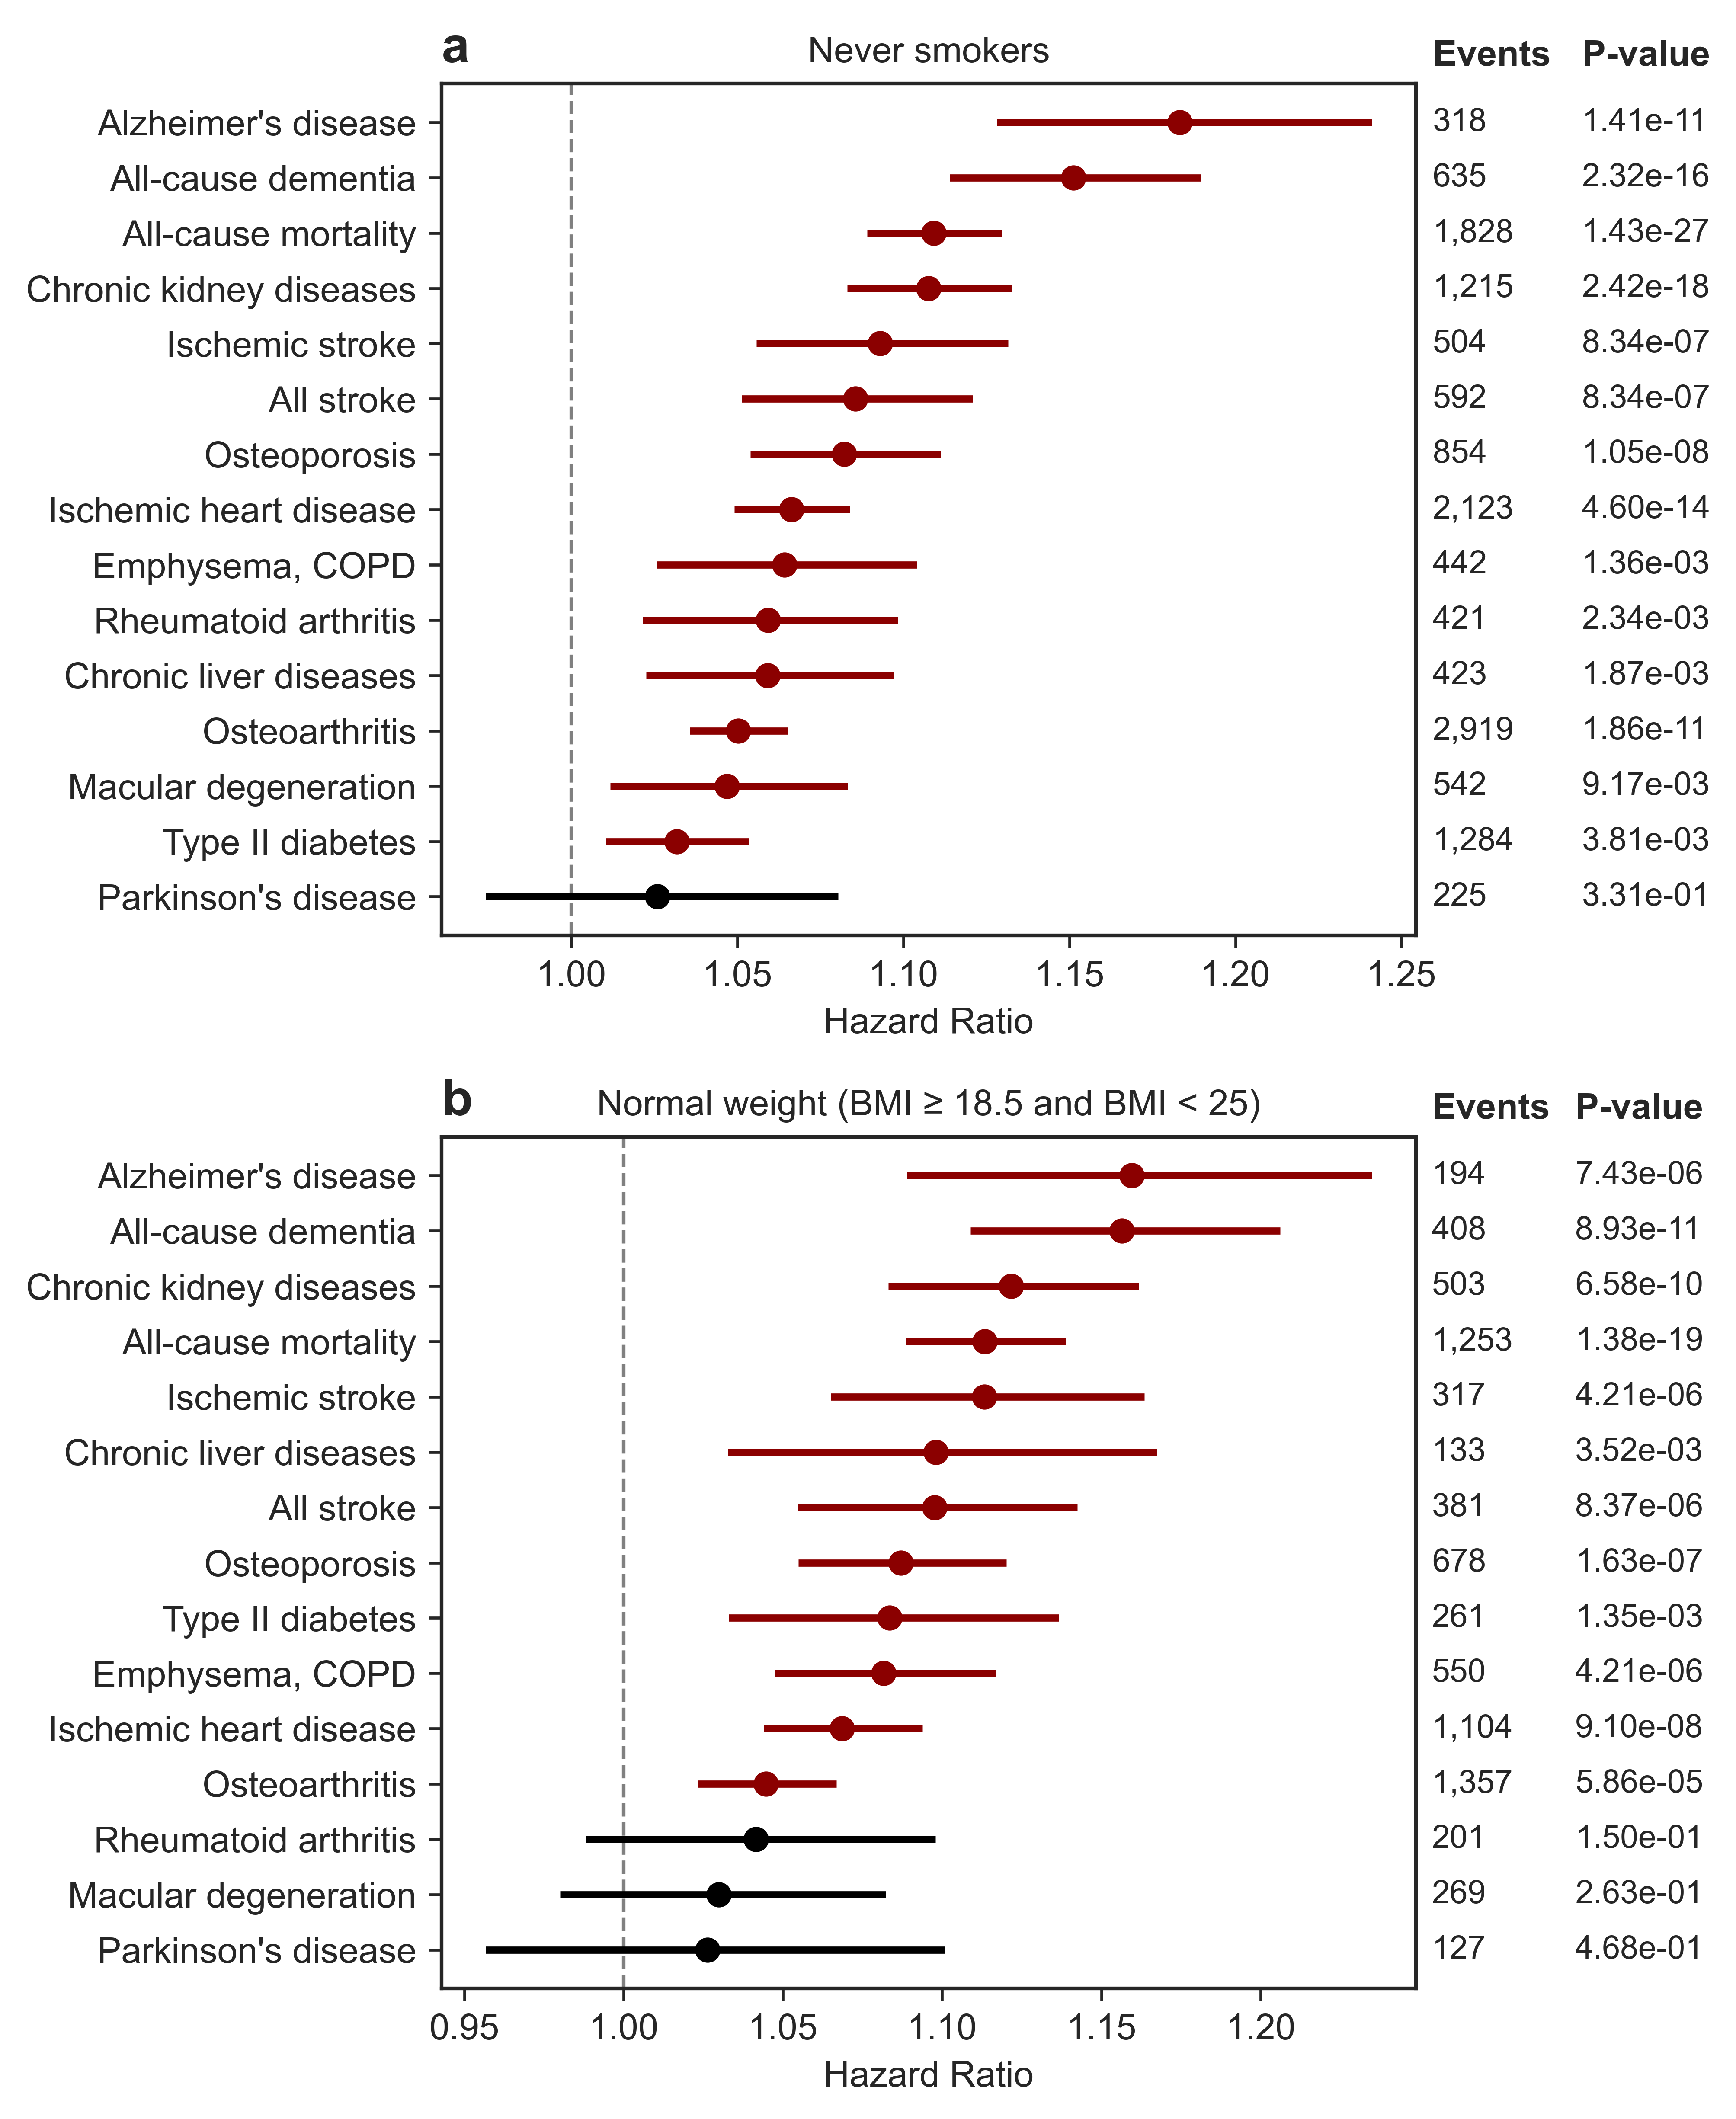

In [117]:
import matplotlib.pyplot as plt


# List to store hazard ratios and p-values
hazard_ratios = []
p_values = []
ci_low_values = []
ci_high_values = []
event_counts = []

hazard_ratios_no_smoke = []
p_values_no_smoke = []
ci_low_values_no_smoke = []
ci_high_values_no_smoke = []
event_counts_no_smoke = []

# Extract hazard ratios and p-values from each model
for model in cox_models_no_overweight:
    hr = model.summary['exp(coef)']['ProtAgeGap']
    pval = model.summary['p']['ProtAgeGap']
    clow = model.summary['exp(coef) lower 95%']['ProtAgeGap']
    chigh = model.summary['exp(coef) upper 95%']['ProtAgeGap']
    events = model.event_observed.sum()
    
    hazard_ratios.append(hr)
    p_values.append(pval)
    ci_low_values.append(clow)
    ci_high_values.append(chigh)
    event_counts.append(events)

for model in cox_models_no_smoke:
    hr = model.summary['exp(coef)']['ProtAgeGap']
    pval = model.summary['p']['ProtAgeGap']
    clow = model.summary['exp(coef) lower 95%']['ProtAgeGap']
    chigh = model.summary['exp(coef) upper 95%']['ProtAgeGap']
    events = model.event_observed.sum()
    
    hazard_ratios_no_smoke.append(hr)
    p_values_no_smoke.append(pval)
    ci_low_values_no_smoke.append(clow)
    ci_high_values_no_smoke.append(chigh)
    event_counts_no_smoke.append(events)

sorted_indices = np.argsort(hazard_ratios)
sorted_hr_values = np.array(hazard_ratios)[sorted_indices]
sorted_ci_low = np.array(ci_low_values)[sorted_indices]
sorted_ci_high = np.array(ci_high_values)[sorted_indices]
sorted_disease_list = np.array(disease_list)[sorted_indices]
sorted_pvals = np.array(p_values)[sorted_indices]
sorted_events = np.array(event_counts)[sorted_indices]

sorted_indices = np.argsort(hazard_ratios_no_smoke)
sorted_hr_values_no_smoke = np.array(hazard_ratios_no_smoke)[sorted_indices]
sorted_ci_low_no_smoke = np.array(ci_low_values_no_smoke)[sorted_indices]
sorted_ci_high_no_smoke = np.array(ci_high_values_no_smoke)[sorted_indices]
sorted_disease_list_no_smoke = np.array(disease_list)[sorted_indices]
sorted_pvals_no_smoke = np.array(p_values_no_smoke)[sorted_indices]
sorted_events_no_smoke = np.array(event_counts_no_smoke)[sorted_indices]

# calculate FDR
rejected, sorted_pvals = fdrcorrection(sorted_pvals)
rejected2, sorted_pvals_no_smoke = fdrcorrection(sorted_pvals_no_smoke)

# Create a new figure and specify the layout using gridspec
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(18*cm, 21*cm), dpi=600)
gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, width_ratios=[1], height_ratios=[1, 1])

####

# plot a: age and sex
ax = plt.subplot(gs[1, 0], aspect='auto')  # Span the entire left column
ax.set_title('b', fontweight='bold', loc='left', fontsize=14)
ax.set_title('Normal weight (BMI ≥ 18.5 and BMI < 25)', fontsize=10, loc='center')


# Define colors based on p-values
colors = np.where(sorted_pvals < 0.05, 'darkred', 'black')

# Create a horizontal line at y=0
plt.axvline(x=1, color='gray', linestyle='--', linewidth=1)

# Plot the hazard ratios and confidence intervals with colored dots
for i in range(len(sorted_hr_values)):
    plt.errorbar(
        sorted_hr_values[i], 
        i, 
        xerr=[[sorted_hr_values[i] - sorted_ci_low[i]], [sorted_ci_high[i] - sorted_hr_values[i]]],
        fmt='o', 
        markersize=6, 
        elinewidth=2,
        capsize=0, 
        color=colors[i]
    )

# Annotate the number of events to the right of the plot
limit = ax.get_xlim()[1]
plt.text(limit + 0.005, len(sorted_events) + 0.2, 'Events', ha='left', va='center', fontweight='bold')
for i, count in enumerate(sorted_events):
    formatted_count = "{:,}".format(count)
    plt.text(limit + 0.005, i, f'{formatted_count}', ha='left', va='center', fontsize=9)
    
# Annotate the p-values to the right of the plot
plt.text(limit + 0.05, len(sorted_pvals) + 0.2, 'P-value', ha='left', va='center', fontweight='bold')
for i, count in enumerate(sorted_pvals):
    plt.text(limit + 0.05, i, f'{count:.2e}', ha='left', va='center', fontsize=9)

plt.xlabel('Hazard Ratio')
plt.yticks(range(len(sorted_hr_values)), sorted_disease_list)
# plt.title(f'ProtAgeGap (Normal weight, Model 2)', fontweight='bold')

# Set plot box linewidth
linewidth = 1
for spine in ax.spines.values():
    spine.set_linewidth(linewidth)

# plot a: age and sex
ax = plt.subplot(gs[0, 0], aspect='auto')  # Span the entire left column
ax.set_title('a', fontweight='bold', loc='left', fontsize=14)
ax.set_title('Never smokers', fontsize=10, loc='center')

# Define colors based on p-values
colors = np.where(sorted_pvals_no_smoke < 0.05, 'darkred', 'black')

# Create a horizontal line at y=0
plt.axvline(x=1, color='gray', linestyle='--', linewidth=1)

# Plot the hazard ratios and confidence intervals with colored dots
for i in range(len(sorted_hr_values_no_smoke)):
    plt.errorbar(
        sorted_hr_values_no_smoke[i], 
        i, 
        xerr=[[sorted_hr_values_no_smoke[i] - sorted_ci_low_no_smoke[i]], [sorted_ci_high_no_smoke[i] - sorted_hr_values_no_smoke[i]]],
        fmt='o', 
        markersize=6, 
        elinewidth=2,
        capsize=0, 
        color=colors[i]
    )

# Annotate the number of events to the right of the plot
limit = ax.get_xlim()[1]
plt.text(limit + 0.005, len(sorted_events_no_smoke) + 0.2, 'Events', ha='left', va='center', fontweight='bold')
for i, count in enumerate(sorted_events_no_smoke):
    formatted_count = "{:,}".format(count)
    plt.text(limit + 0.005, i, f'{formatted_count}', ha='left', va='center', fontsize=9)
    
# Annotate the p-values to the right of the plot
plt.text(limit + 0.05, len(sorted_pvals_no_smoke) + 0.2, 'P-value', ha='left', va='center', fontweight='bold')
for i, count in enumerate(sorted_pvals_no_smoke):
    plt.text(limit + 0.05, i, f'{count:.2e}', ha='left', va='center', fontsize=9)

plt.xlabel('Hazard Ratio')
plt.yticks(range(len(sorted_hr_values_no_smoke)), sorted_disease_list_no_smoke)

# Set plot box linewidth
linewidth = 1
for spine in ax.spines.values():
    spine.set_linewidth(linewidth)

plt.tight_layout()

# Show the plot
# plt.show()

# save
# name = f'{filepath}output/hr_plot_adjusted_sensitivity_{now}.png'
name = '.../Figures/Ext_data_fig_4.jpg'

plt.savefig(
    name,
    # format='pdf',
    dpi=600,
    facecolor='white',
    transparent=False,
    bbox_inches="tight"
)
# plt.close()

In [204]:
survival_data['smoking_status'].value_counts()

smoking_status
Never       24528
Previous    15869
Current      4881
Name: count, dtype: int64

In [205]:
len(survival_data[(survival_data['BMI'] >= 18.5) & (survival_data['BMI'] < 25)].index)

14555

# Cancer models

## Run models

In [110]:
import statsmodels.api as sm
from scipy.stats import pearsonr
import numpy as np

# empty list for models
cox_models_cancer = []
new_events = cancers

for i, outcome in enumerate(new_events):
    
    event = f'incident_{outcome}'
    prev = f'prevalent_{outcome}'
    time = f'{outcome}_survival_time'

    # exclude prevalent cases
    plot_data = survival_data[survival_data[prev] == 0]

    # remove men for women only cancers
    if outcome in ['breast_cancer', 'ovarian_cancer']:
        plot_data = plot_data[plot_data['sex'] == 'Female']
        
    # remove women for men only cancers
    if outcome == 'prostate_cancer':
        plot_data = plot_data[plot_data['sex'] == 'Male']
        
    # drop NA in covariates
    plot_data = plot_data.dropna(subset=['recruitment_centre', 'townsend_deprivation_index', 'IPAQ_activity_group', 'smoking_status'])

    cph = CoxPHFitter()
    
    # Create a formula for the linear regression
    if outcome in ['breast_cancer', 'ovarian_cancer', 'prostate_cancer']:
        formula = 'ProtAgeGap + age_granular + townsend_deprivation_index + recruitment_centre + IPAQ_activity_group + smoking_status'
    else:
        formula = 'ProtAgeGap + age_granular + sex + townsend_deprivation_index + recruitment_centre + IPAQ_activity_group + smoking_status'

    cph.fit(
        plot_data, 
        duration_col=time, 
        event_col=event, 
        formula=formula,
        fit_options=dict({'step_size':0.5})
    )

    cox_models_cancer.append(cph)

    print(f'completed: {i+1}/{len(new_events)}', end='\r')

Column recruitment_centre[T.10003] have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['incident_eso_cancer'].astype(bool)
>>> print(df.loc[events, 'recruitment_centre[T.10003]'].var())
>>> print(df.loc[~events, 'recruitment_centre[T.10003]'].var())

A very low variance means that the column recruitment_centre[T.10003] completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.230. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?



Column recruitment_centre[T.10003] have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['incident_h_lymphoma'].astype(bool)
>>> print(df.loc[events, 'recruitment_centre[T.10003]'].var())
>>> print(df.loc[~events, 'recruitment_centre[T.10003]'].var())

A very low variance means that the column recruitment_centre[T.10003] completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.508. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?



## Run models age + sex

In [111]:
import statsmodels.api as sm
from scipy.stats import pearsonr
import numpy as np

# empty list for models
cox_models_cancer_as = []
new_events = cancers

for i, outcome in enumerate(new_events):
    
    event = f'incident_{outcome}'
    prev = f'prevalent_{outcome}'
    time = f'{outcome}_survival_time'

    # exclude prevalent cases
    plot_data = survival_data[survival_data[prev] == 0]

    # remove men for women only cancers
    if outcome in ['breast_cancer', 'ovarian_cancer']:
        plot_data = plot_data[plot_data['sex'] == 'Female']
        
    # remove women for men only cancers
    if outcome == 'prostate_cancer':
        plot_data = plot_data[plot_data['sex'] == 'Male']
        
    # drop NA in covariates
    plot_data = plot_data.dropna(subset=['recruitment_centre', 'townsend_deprivation_index', 'IPAQ_activity_group', 'smoking_status'])

    cph = CoxPHFitter()
    
    # Create a formula for the linear regression
    if outcome in ['breast_cancer', 'ovarian_cancer', 'prostate_cancer']:
        formula = 'ProtAgeGap + age_granular'
    else:
        formula = 'ProtAgeGap + age_granular + sex'

    cph.fit(
        plot_data, 
        duration_col=time, 
        event_col=event, 
        formula=formula,
        fit_options=dict({'step_size':0.5})
    )

    cox_models_cancer_as.append(cph)

    print(f'completed: {i+1}/{len(new_events)}', end='\r')

## Run models BMI

In [112]:
import statsmodels.api as sm
from scipy.stats import pearsonr
import numpy as np

# empty list for models
cox_models_cancer_bmi = []
new_events = cancers

for i, outcome in enumerate(new_events):
    
    event = f'incident_{outcome}'
    prev = f'prevalent_{outcome}'
    time = f'{outcome}_survival_time'

    # exclude prevalent cases
    plot_data = survival_data[survival_data[prev] == 0]

    # remove men for women only cancers
    if outcome in ['breast_cancer', 'ovarian_cancer']:
        plot_data = plot_data[plot_data['sex'] == 'Female']
        
    # remove women for men only cancers
    if outcome == 'prostate_cancer':
        plot_data = plot_data[plot_data['sex'] == 'Male']
        
    # drop NA in covariates
    plot_data = plot_data.dropna(subset=['recruitment_centre', 'townsend_deprivation_index', 'IPAQ_activity_group', 'smoking_status', 'BMI', 'prevalent_hypertension'])

    cph = CoxPHFitter()
    
    # Create a formula for the linear regression
    if outcome in ['breast_cancer', 'ovarian_cancer', 'prostate_cancer']:
        formula = 'ProtAgeGap + age_granular + townsend_deprivation_index + recruitment_centre + IPAQ_activity_group + smoking_status + BMI + prevalent_hypertension'
    else:
        formula = 'ProtAgeGap + age_granular + sex + townsend_deprivation_index + recruitment_centre + IPAQ_activity_group + smoking_status + BMI + prevalent_hypertension'

    cph.fit(
        plot_data, 
        duration_col=time, 
        event_col=event, 
        formula=formula,
        fit_options=dict({'step_size':0.5})
    )

    cox_models_cancer_bmi.append(cph)

    print(f'completed: {i+1}/{len(new_events)}', end='\r')

Column recruitment_centre[T.10003] have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['incident_eso_cancer'].astype(bool)
>>> print(df.loc[events, 'recruitment_centre[T.10003]'].var())
>>> print(df.loc[~events, 'recruitment_centre[T.10003]'].var())

A very low variance means that the column recruitment_centre[T.10003] completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.230. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?



Column recruitment_centre[T.10003] have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['incident_h_lymphoma'].astype(bool)
>>> print(df.loc[events, 'recruitment_centre[T.10003]'].var())
>>> print(df.loc[~events, 'recruitment_centre[T.10003]'].var())

A very low variance means that the column recruitment_centre[T.10003] completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.508. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?



In [82]:
# empty list for models
cox_models_cancer_bmi_t20 = []
new_events = cancers

for i, outcome in enumerate(new_events):
    
    event = f'incident_{outcome}'
    prev = f'prevalent_{outcome}'
    time = f'{outcome}_survival_time'

    # exclude prevalent cases
    plot_data = survival_data[survival_data[prev] == 0]

    # remove men for women only cancers
    if outcome in ['breast_cancer', 'ovarian_cancer']:
        plot_data = plot_data[plot_data['sex'] == 'Female']
        
    # remove women for men only cancers
    if outcome == 'prostate_cancer':
        plot_data = plot_data[plot_data['sex'] == 'Male']
        
    # drop NA in covariates
    plot_data = plot_data.dropna(subset=['recruitment_centre', 'townsend_deprivation_index', 'IPAQ_activity_group', 'smoking_status', 'BMI', 'prevalent_hypertension'])

    cph = CoxPHFitter()
    
    # Create a formula for the linear regression
    if outcome in ['breast_cancer', 'ovarian_cancer', 'prostate_cancer']:
        formula = 'ProtAgeGap + age_granular + townsend_deprivation_index + recruitment_centre + IPAQ_activity_group + smoking_status + BMI + prevalent_hypertension'
    else:
        formula = 'ProtAgeGap + age_granular + sex + townsend_deprivation_index + recruitment_centre + IPAQ_activity_group + smoking_status + BMI + prevalent_hypertension'

    cph.fit(
        plot_data, 
        duration_col=time, 
        event_col=event, 
        formula=formula,
        fit_options=dict({'step_size':0.5})
    )

    cox_models_cancer_bmi_t20.append(cph)

    print(f'completed: {i+1}/{len(new_events)}', end='\r')

Column recruitment_centre[T.10003] have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['incident_eso_cancer'].astype(bool)
>>> print(df.loc[events, 'recruitment_centre[T.10003]'].var())
>>> print(df.loc[~events, 'recruitment_centre[T.10003]'].var())

A very low variance means that the column recruitment_centre[T.10003] completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.230. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?



Column recruitment_centre[T.10003] have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['incident_h_lymphoma'].astype(bool)
>>> print(df.loc[events, 'recruitment_centre[T.10003]'].var())
>>> print(df.loc[~events, 'recruitment_centre[T.10003]'].var())

A very low variance means that the column recruitment_centre[T.10003] completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.508. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?



([<matplotlib.axis.YTick at 0x4df1ac610>,
 [Text(0, 0, 'Hodgkin lymphoma'),
  Text(0, 1, 'Ovarian cancer'),
  Text(0, 2, 'Breast cancer'),
  Text(0, 3, 'Colorectal cancer'),
  Text(0, 4, 'Leukemia'),
  Text(0, 5, 'Pancreatic cancer'),
  Text(0, 6, 'Liver cancer'),
  Text(0, 7, 'Prostate cancer'),
  Text(0, 8, 'Brain cancer'),
  Text(0, 9, 'Lung cancer'),
  Text(0, 10, 'Esophageal cancer'),
  Text(0, 11, 'Non-Hodgkin lymphoma')])

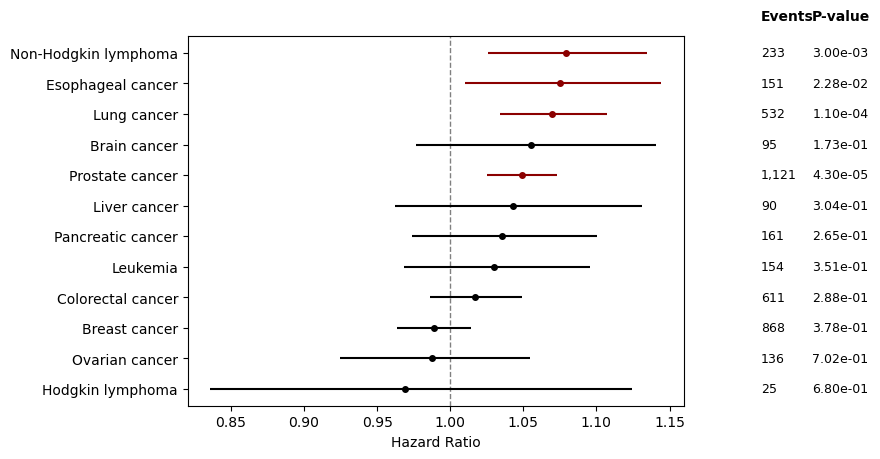

In [83]:
# List to store hazard ratios and p-values
hazard_ratios = []
p_values = []
ci_low_values = []
ci_high_values = []
event_counts = []

# Extract hazard ratios and p-values from each model
for model in cox_models_cancer_bmi_t20:
    hr = model.summary['exp(coef)']['ProtAgeGap']
    pval = model.summary['p']['ProtAgeGap']
    clow = model.summary['exp(coef) lower 95%']['ProtAgeGap']
    chigh = model.summary['exp(coef) upper 95%']['ProtAgeGap']

    events = model.event_observed.sum()
    
    hazard_ratios.append(hr)
    p_values.append(pval)
    ci_low_values.append(clow)
    ci_high_values.append(chigh)
    event_counts.append(events)
    
sorted_indices = np.argsort(hazard_ratios)
sorted_hr_values = np.array(hazard_ratios)[sorted_indices]
sorted_ci_low = np.array(ci_low_values)[sorted_indices]
sorted_ci_high = np.array(ci_high_values)[sorted_indices]
sorted_disease_list = np.array(cancer_list)[sorted_indices]
sorted_pvals = np.array(p_values)[sorted_indices]
sorted_events = np.array(event_counts)[sorted_indices]

# Define colors based on p-values
colors = np.where(sorted_pvals < 0.05, 'darkred', 'black')

# Create a horizontal line at y=0
plt.axvline(x=1, color='gray', linestyle='--', linewidth=1)

# Plot the hazard ratios and confidence intervals with colored dots
for i in range(len(sorted_hr_values)):
    plt.errorbar(
        sorted_hr_values[i], 
        i, 
        xerr=[[sorted_hr_values[i] - sorted_ci_low[i]], [sorted_ci_high[i] - sorted_hr_values[i]]],
        fmt='o', 
        markersize=4, 
        capsize=0, 
        color=colors[i]
    )
    

# Annotate the number of events to the right of the plot
limit = ax.get_xlim()[1]
plt.text(limit + 0.005, len(sorted_events) + 0.2, 'Events', ha='left', va='center', fontweight='bold')
for i, count in enumerate(sorted_events):
    formatted_count = "{:,}".format(count)
    plt.text(limit + 0.005, i, f'{formatted_count}', ha='left', va='center', fontsize=9)
    
# Annotate the p-values to the right of the plot
plt.text(limit + 0.04, len(sorted_pvals) + 0.2, 'P-value', ha='left', va='center', fontweight='bold')
for i, count in enumerate(sorted_pvals):
    plt.text(limit + 0.04, i, f'{count:.2e}', ha='left', va='center', fontsize=9)



plt.xlabel('Hazard Ratio')
plt.yticks(range(len(sorted_hr_values)), sorted_disease_list)
# plt.title(f'ProtAgeGap (BMI adjusted)', fontweight='bold')


## Forest plot all

In [113]:
# Create a new figure and specify the layout using gridspec
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(18*cm, 21*cm), dpi=600)
gs = gridspec.GridSpec(ncols=1, nrows=3, figure=fig, width_ratios=[1], height_ratios=[1, 1, 1])

####

# plot a: age and sex
ax = plt.subplot(gs[0, 0], aspect='auto')  # Span the entire left column
ax.set_title('a', fontweight='bold', loc='left', fontsize=14)
ax.set_title('Model 1', fontsize=10, loc='center')

# List to store hazard ratios and p-values
hazard_ratios = []
p_values = []
ci_low_values = []
ci_high_values = []
event_counts = []

# Extract hazard ratios and p-values from each model
for model in cox_models_cancer_as:
    hr = model.summary['exp(coef)']['ProtAgeGap']
    pval = model.summary['p']['ProtAgeGap']
    clow = model.summary['exp(coef) lower 95%']['ProtAgeGap']
    chigh = model.summary['exp(coef) upper 95%']['ProtAgeGap']
    events = model.event_observed.sum()
    
    hazard_ratios.append(hr)
    p_values.append(pval)
    ci_low_values.append(clow)
    ci_high_values.append(chigh)
    event_counts.append(events)

sorted_indices = np.argsort(hazard_ratios)
sorted_hr_values = np.array(hazard_ratios)[sorted_indices]
sorted_ci_low = np.array(ci_low_values)[sorted_indices]
sorted_ci_high = np.array(ci_high_values)[sorted_indices]
sorted_disease_list = np.array(cancer_list)[sorted_indices]
sorted_pvals = np.array(p_values)[sorted_indices]
sorted_events = np.array(event_counts)[sorted_indices]

# calculate FDR
rejected, sorted_pvals = fdrcorrection(sorted_pvals)

# Create a DataFrame
df = pd.DataFrame({
    'Outcome': sorted_disease_list,
    'Hazard Ratio': sorted_hr_values,
    'Low 95% CI': sorted_ci_low,
    'High 95% CI': sorted_ci_high,
    'FDR P-value': sorted_pvals
})

# save the DataFrame
name = f'{filepath}output/tables/cancer_regressions_model1_{now}.csv'
df.to_csv(name, index=False)

# Define colors based on p-values
colors = np.where(sorted_pvals < 0.05, 'darkred', 'black')

# Create a horizontal line at y=0
plt.axvline(x=1, color='gray', linestyle='--', linewidth=1)

# Plot the hazard ratios and confidence intervals with colored dots
for i in range(len(sorted_hr_values)):
    plt.errorbar(
        sorted_hr_values[i], 
        i, 
        xerr=[[sorted_hr_values[i] - sorted_ci_low[i]], [sorted_ci_high[i] - sorted_hr_values[i]]],
        fmt='o', 
        markersize=6,
        elinewidth=2, 
        capsize=0, 
        color=colors[i]
    )

# Annotate the number of events to the right of the plot
limit = ax.get_xlim()[1]
plt.text(limit + 0.005, len(sorted_events) + 0.2, 'Events', ha='left', va='center', fontweight='bold')
for i, count in enumerate(sorted_events):
    formatted_count = "{:,}".format(count)
    plt.text(limit + 0.005, i, f'{formatted_count}', ha='left', va='center', fontsize=9)
    
# Annotate the p-values to the right of the plot
plt.text(limit + 0.05, len(sorted_pvals) + 0.2, 'FDR', ha='left', va='center', fontweight='bold')
for i, count in enumerate(sorted_pvals):
    plt.text(limit + 0.05, i, f'{count:.2e}', ha='left', va='center', fontsize=9)

plt.xlabel('Hazard Ratio')
plt.yticks(range(len(sorted_hr_values)), sorted_disease_list)
# plt.title(f'ProtAgeGap (age, sex adjusted)', fontweight='bold')

# Set plot box linewidth
linewidth = 1
for spine in ax.spines.values():
    spine.set_linewidth(linewidth)

####

# plot b: lifestle factors
ax = plt.subplot(gs[1, 0], aspect='auto')  # Span the entire left column
ax.set_title('b', fontweight='bold', loc='left', fontsize=14)
ax.set_title('Model 2', fontsize=10, loc='center')

# List to store hazard ratios and p-values
hazard_ratios = []
p_values = []
ci_low_values = []
ci_high_values = []
event_counts = []

# Extract hazard ratios and p-values from each model
for model in cox_models_cancer:
    hr = model.summary['exp(coef)']['ProtAgeGap']
    pval = model.summary['p']['ProtAgeGap']
    clow = model.summary['exp(coef) lower 95%']['ProtAgeGap']
    chigh = model.summary['exp(coef) upper 95%']['ProtAgeGap']
    events = model.event_observed.sum()
    
    hazard_ratios.append(hr)
    p_values.append(pval)
    ci_low_values.append(clow)
    ci_high_values.append(chigh)
    event_counts.append(events)

sorted_indices = np.argsort(hazard_ratios)
sorted_hr_values = np.array(hazard_ratios)[sorted_indices]
sorted_ci_low = np.array(ci_low_values)[sorted_indices]
sorted_ci_high = np.array(ci_high_values)[sorted_indices]
sorted_disease_list = np.array(cancer_list)[sorted_indices]
sorted_pvals = np.array(p_values)[sorted_indices]
sorted_events = np.array(event_counts)[sorted_indices]

# calculate FDR
rejected, sorted_pvals = fdrcorrection(sorted_pvals)

# Create a DataFrame
df = pd.DataFrame({
    'Outcome': sorted_disease_list,
    'Hazard Ratio': sorted_hr_values,
    'Low 95% CI': sorted_ci_low,
    'High 95% CI': sorted_ci_high,
    'FDR P-value': sorted_pvals
})

# save the DataFrame
name = f'{filepath}output/tables/cancer_regressions_model2_{now}.csv'
df.to_csv(name, index=False)

# Define colors based on p-values
colors = np.where(sorted_pvals < 0.05, 'darkred', 'black')

# Create a horizontal line at y=0
plt.axvline(x=1, color='gray', linestyle='--', linewidth=1)

# Plot the hazard ratios and confidence intervals with colored dots
for i in range(len(sorted_hr_values)):
    plt.errorbar(
        sorted_hr_values[i], 
        i, 
        xerr=[[sorted_hr_values[i] - sorted_ci_low[i]], [sorted_ci_high[i] - sorted_hr_values[i]]],
        fmt='o', 
        markersize=6,
        elinewidth=2, 
        capsize=0, 
        color=colors[i]
    )

# Annotate the number of events to the right of the plot
limit = ax.get_xlim()[1]
plt.text(limit + 0.005, len(sorted_events) + 0.2, 'Events', ha='left', va='center', fontweight='bold')
for i, count in enumerate(sorted_events):
    formatted_count = "{:,}".format(count)
    plt.text(limit + 0.005, i, f'{formatted_count}', ha='left', va='center', fontsize=9)
    
# Annotate the p-values to the right of the plot
plt.text(limit + 0.05, len(sorted_pvals) + 0.2, 'FDR', ha='left', va='center', fontweight='bold')
for i, count in enumerate(sorted_pvals):
    plt.text(limit + 0.05, i, f'{count:.2e}', ha='left', va='center', fontsize=9)

plt.xlabel('Hazard Ratio')
plt.yticks(range(len(sorted_hr_values)), sorted_disease_list)
# plt.title(f'ProtAgeGap (fully adjusted)', fontweight='bold')

# Set plot box linewidth
linewidth = 1
for spine in ax.spines.values():
    spine.set_linewidth(linewidth)


####

# plot c: BMI
ax = plt.subplot(gs[2, 0], aspect='auto')  # Span the entire left column
ax.set_title('c', fontweight='bold', loc='left', fontsize=14)
ax.set_title('Model 3', fontsize=10, loc='center')

import matplotlib.pyplot as plt

# List to store hazard ratios and p-values
hazard_ratios = []
p_values = []
ci_low_values = []
ci_high_values = []
event_counts = []

# Extract hazard ratios and p-values from each model
for model in cox_models_cancer_bmi:
    hr = model.summary['exp(coef)']['ProtAgeGap']
    pval = model.summary['p']['ProtAgeGap']
    clow = model.summary['exp(coef) lower 95%']['ProtAgeGap']
    chigh = model.summary['exp(coef) upper 95%']['ProtAgeGap']

    events = model.event_observed.sum()
    
    hazard_ratios.append(hr)
    p_values.append(pval)
    ci_low_values.append(clow)
    ci_high_values.append(chigh)
    event_counts.append(events)
    
sorted_indices = np.argsort(hazard_ratios)
sorted_hr_values = np.array(hazard_ratios)[sorted_indices]
sorted_ci_low = np.array(ci_low_values)[sorted_indices]
sorted_ci_high = np.array(ci_high_values)[sorted_indices]
sorted_disease_list = np.array(cancer_list)[sorted_indices]
sorted_pvals = np.array(p_values)[sorted_indices]
sorted_events = np.array(event_counts)[sorted_indices]

# calculate FDR
rejected, sorted_pvals = fdrcorrection(sorted_pvals)

# Create a DataFrame
df = pd.DataFrame({
    'Outcome': sorted_disease_list,
    'Hazard Ratio': sorted_hr_values,
    'Low 95% CI': sorted_ci_low,
    'High 95% CI': sorted_ci_high,
    'FDR P-value': sorted_pvals
})

# save the DataFrame
name = f'{filepath}output/tables/cancer_regressions_model3_{now}.csv'
df.to_csv(name, index=False)

# Define colors based on p-values
colors = np.where(sorted_pvals < 0.05, 'darkred', 'black')

# Create a horizontal line at y=0
plt.axvline(x=1, color='gray', linestyle='--', linewidth=1)

# Plot the hazard ratios and confidence intervals with colored dots
for i in range(len(sorted_hr_values)):
    plt.errorbar(
        sorted_hr_values[i], 
        i, 
        xerr=[[sorted_hr_values[i] - sorted_ci_low[i]], [sorted_ci_high[i] - sorted_hr_values[i]]],
        fmt='o', 
        markersize=6,
        elinewidth=2, 
        capsize=0, 
        color=colors[i]
    )
    

# Annotate the number of events to the right of the plot
limit = ax.get_xlim()[1]
plt.text(limit + 0.005, len(sorted_events) + 0.2, 'Events', ha='left', va='center', fontweight='bold')
for i, count in enumerate(sorted_events):
    formatted_count = "{:,}".format(count)
    plt.text(limit + 0.005, i, f'{formatted_count}', ha='left', va='center', fontsize=9)
    
# Annotate the p-values to the right of the plot
plt.text(limit + 0.05, len(sorted_pvals) + 0.2, 'FDR', ha='left', va='center', fontweight='bold')
for i, count in enumerate(sorted_pvals):
    plt.text(limit + 0.05, i, f'{count:.2e}', ha='left', va='center', fontsize=9)


plt.xlabel('Hazard Ratio')
plt.yticks(range(len(sorted_hr_values)), sorted_disease_list)
# plt.title(f'ProtAgeGap (BMI adjusted)', fontweight='bold')

# Set plot box linewidth
linewidth = 1
for spine in ax.spines.values():
    spine.set_linewidth(linewidth)


# arrange nicely
plt.tight_layout()

# Show the plot
# plt.show()

# save
# name = f'{filepath}output/cancer_hr_plot_adjusted_{now}.png'
name = '.../Figures/Ext_data_fig_3.jpg'

plt.savefig(
    name,
    # format='pdf',
    dpi=600,
    facecolor='white',
    transparent=False,
    bbox_inches="tight"
)
plt.close()


# Protein importance models

## Run Cox models

In [9]:
import numpy as np
import lifelines

# List to store model results
coefficients_protImp = {}
zscore_proImp = {}
pval_protImp = {}
clow_protImp = {}
chigh_protImp = {}

# subset cancers to those associated with proteomic clock
cancer_sub = [
    'eso_cancer', 
    'prostate_cancer', 
    'lung_cancer', 
    'nh_lymphoma'
]

# make survival times
cancer_times = [f'{x}_survival_time' for x in cancer_sub]

# combine with non-cancer lists
all_events = events_list + cancer_sub
all_times = times_list + cancer_times

times_subset = [x for x in all_times if x != 'ACM_survival_time']
event_subset = [x for x in all_events if x != 'ACM_event_indicator']

all_prots = ' + '.join(top_20_features)

for i, (time,outcome) in enumerate(zip(times_subset, event_subset)):
    
    coefficients_list = {}
    zscore_list = {}
    pval_list = {}
    clow_list = {}
    chigh_list = {}
    
    if outcome in ['breast_cancer', 'ovarian_cancer']:
        plot_data = survival_data[survival_data['sex'] == 'Female']
        # Create a formula for the linear regression
        formula = f'{all_prots} + age_granular + townsend_deprivation_index + recruitment_centre + ethnicity + IPAQ_activity_group + smoking_status'
        
    elif outcome in ['prostate_cancer']:
        plot_data = survival_data[survival_data['sex'] == 'Male']
        # Create a formula for the linear regression
        formula = f'{all_prots} + age_granular + townsend_deprivation_index + recruitment_centre + ethnicity + IPAQ_activity_group + smoking_status'

    else:
        plot_data = survival_data
        # Create a formula for the linear regression
        formula = f'{all_prots} + age_granular + sex + townsend_deprivation_index + recruitment_centre + ethnicity + IPAQ_activity_group + smoking_status'

    
    if outcome != 'ACM_event_indicator':
        event = f'incident_{outcome}'
        prev = f'prevalent_{outcome}'

        plot_data = plot_data[plot_data[prev] == 0]
    else: 
        event = outcome
        
    plot_data = plot_data.dropna(subset=['recruitment_centre', 'townsend_deprivation_index', 'ethnicity', 'IPAQ_activity_group', 'smoking_status'])

    cph = CoxPHFitter()
    
    cph.fit(
        plot_data, 
        duration_col=time, 
        event_col=event, 
        formula=formula,
        fit_options=dict({'step_size':0.5})
    )

    # add results to list
    for prot in top_20_features:
        coefficient = cph.summary['exp(coef)'][prot]
        zscore = cph.summary['z'][prot]
        pval = cph.summary['p'][prot]
        clow = cph.summary['exp(coef) lower 95%'][prot]
        chigh = cph.summary['exp(coef) upper 95%'][prot]
        
        coefficients_list.update({prot: coefficient})
        zscore_list.update({prot: zscore})
        pval_list.update({prot: pval})
        clow_list.update({prot: clow})
        chigh_list.update({prot: chigh})
    
    
    coefficients_protImp.update({event: coefficients_list})
    zscore_proImp.update({event: zscore_list})
    pval_protImp.update({event: pval_list})
    clow_protImp.update({event: clow_list})
    chigh_protImp.update({event: chigh_list})

    del cph

    print(f'completed: {i+1}/{len(event_subset)}', end='\r')


Column recruitment_centre[T.10003] have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['incident_eso_cancer'].astype(bool)
>>> print(df.loc[events, 'recruitment_centre[T.10003]'].var())
>>> print(df.loc[~events, 'recruitment_centre[T.10003]'].var())

A very low variance means that the column recruitment_centre[T.10003] completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.278. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?



Column recruitment_centre[T.10003] have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['incident_nh_lymphoma'].astype(bool)
>>> print(df.loc[events, 'recruitment_centre[T.10003]'].var())
>>> print(df.loc[~events, 'recruitment_centre[T.10003]'].var())

A very low variance means that the column recruitment_centre[T.10003] completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

Newton-Raphson convergence completed successfully but norm(delta) is still high, 0.121. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?



## Post-process Cox

In [10]:
coefficients_scaled = {}
# for x in coefficients_protImp.keys():
for x in zscore_proImp.keys():
    
    # Step 1: Calculate the sum of all hazard ratios
    sum_of_ratios = sum(np.abs(pd.Series(zscore_proImp[x].values())))

    # Step 2: Scale each hazard ratio
    coefficients_scaled[x] = {protein: np.abs(ratio) / sum_of_ratios for protein, ratio in zscore_proImp[x].items()}
    
zscore_df = pd.DataFrame.from_dict(coefficients_scaled, orient='index').fillna(0)

In [11]:
# make df with scaled z-values only where p-value is significant
coefficients_scaled = {}
for x in zscore_proImp.keys():
    
    # values = [val for val in coefficients_protImp[x].values() if pval_protImp[x][val] < 0.05]
    values = {protein: val if pval_protImp[x][protein] < 0.05 else 0 for protein, val in zscore_proImp[x].items()}
    
    # Step 1: Calculate the sum of all hazard ratios
    sum_of_ratios = sum(np.abs(pd.Series(values.values())))

    # Step 2: Scale each hazard ratio
    coefficients_scaled[x] = {protein: np.abs(ratio) / sum_of_ratios for protein, ratio in values.items()}
    
zscore_zero_scaled_df = pd.DataFrame.from_dict(coefficients_scaled, orient='index').fillna(0)

In [12]:
# make df with z-values only where p-value is significant
coefficients = {}
for x in zscore_proImp.keys():
    
    # values = [val for val in coefficients_protImp[x].values() if pval_protImp[x][val] < 0.05]
    values = {protein: val if pval_protImp[x][protein] < 0.05 else 0 for protein, val in zscore_proImp[x].items()}
    
    # Step 2: Scale each hazard ratio
    coefficients[x] = {protein: ratio for protein, ratio in values.items()}
    
zscore_zero_df = pd.DataFrame.from_dict(coefficients, orient='index').fillna(0)

In [15]:
coefficients_scaled = {}
for x in coefficients_protImp.keys():
    
    # values = [val for val in coefficients_protImp[x].values() if pval_protImp[x][val] < 0.05]
    values = {protein: val if pval_protImp[x][protein] < 0.05 else 0 for protein, val in coefficients_protImp[x].items()}
    
    # Step 1: Calculate the sum of all hazard ratios
    sum_of_ratios = sum(values.values())

    # Step 2: Scale each hazard ratio
    coefficients_scaled[x] = {protein: ratio / sum_of_ratios for protein, ratio in values.items()}

In [16]:
# make df of results
df = pd.DataFrame.from_dict(coefficients_scaled, orient='index').fillna(0)
df

,CXCL17,EDA2R,ELN,ENG,CDCP1,COL6A3,IGDCC4,GFAP,GDF15,FSHB,AGRP,ACRV1,NEFL,LECT2,SCARF2,LTBP2,PTPRR,PODXL2,KLK3,KLK7
incident_t2diabetes,0.000000,0.051952,0.038345,0.000000,0.094364,0.205077,0.047328,0.000000,0.131212,0.000000,0.074488,0.000000,0.000000,0.078634,0.051232,0.037168,0.039372,0.033704,0.060894,0.056230
incident_IHD,0.090863,0.000000,0.089600,0.060805,0.089945,0.113226,0.060551,0.000000,0.106797,0.000000,0.000000,0.000000,0.000000,0.087918,0.068512,0.097155,0.000000,0.062290,0.000000,0.072338
incident_all_stroke,0.000000,0.000000,0.000000,0.073466,0.000000,0.000000,0.000000,0.129415,0.173356,0.000000,0.000000,0.000000,0.155304,0.000000,0.000000,0.179602,0.097659,0.091650,0.000000,0.099548
incident_ischemic_stroke,0.000000,0.000000,0.000000,0.071794,0.000000,0.158158,0.000000,0.000000,0.190137,0.000000,0.000000,0.000000,0.175603,0.000000,0.000000,0.195290,0.102314,0.000000,0.000000,0.106703
incident_emphysema_COPD,0.120137,0.094149,0.094985,0.000000,0.098048,0.091797,0.048077,0.000000,0.127156,0.000000,0.056201,0.000000,0.000000,0.000000,0.054394,0.095658,0.000000,0.054521,0.000000,0.064879
incident_liver,0.000000,0.000000,0.060201,0.126870,0.123451,0.142594,0.038979,0.000000,0.130762,0.000000,0.085811,0.000000,0.000000,0.084737,0.000000,0.109975,0.058767,0.037854,0.000000,0.000000
incident_kidney,0.000000,0.110219,0.000000,0.036911,0.000000,0.201911,0.064123,0.000000,0.146651,0.000000,0.000000,0.000000,0.091701,0.087409,0.000000,0.101408,0.097567,0.062100,0.000000,0.000000
incident_all_dementia,0.070468,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.195362,0.150830,0.000000,0.000000,0.000000,0.189966,0.000000,0.074057,0.123637,0.054308,0.056175,0.085197,0.000000
incident_alzheimers,0.070058,0.000000,0.000000,0.000000,0.000000,0.067082,0.140316,0.260390,0.140992,0.000000,0.000000,0.000000,0.199617,0.000000,0.068761,0.000000,0.052784,0.000000,0.000000,0.000000
incident_parkinsons,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.231508,0.000000,0.000000,0.000000,0.000000,0.275249,0.141029,0.000000,0.000000,0.116354,0.112310,0.000000,0.123550


## Plot together

In [18]:
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

ccm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(22*ccm, 18*ccm), dpi=600)
# gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, width_ratios=[1], height_ratios=[1, 1])
cancer_list_sub = [
    'Esophageal cancer',
    'Prostate cancer',
    'Lung cancer',
    'Non-Hodgkin lymphoma'
]

all_dseases = disease_list + cancer_list_sub
disease_sub = [x for x in all_dseases if x != 'All-cause mortality']

####

# plot a: heatmap
hmap_df = zscore_zero_df.copy()
hmap_df.index = disease_sub

# set bounds for uneven colorbar mapping
# norm = Normalize(vmin=-10, vmax=20)
norm = TwoSlopeNorm(vmin=-10, vcenter=0, vmax=20)

# Create a clustered heatmap after filtering
cluster_grid = sns.clustermap(
    hmap_df.transpose(), 
    cmap='RdBu_r', 
    vmin=-10,
    vmax=10,
    norm=norm,
    center=0, 
    figsize=(18, 10), 
    method='ward',
    tree_kws={'linewidths': 1.5},
    dendrogram_ratio=(0.1,0.1),
    cbar_pos=None
    )

# Set the title in the middle of the plot
# cluster_grid.ax_heatmap.set_title('ProtAge protein z-scores per disease', pad=140, size=20,fontweight='bold')
cluster_grid.ax_heatmap.set_xticklabels(cluster_grid.ax_heatmap.get_xticklabels(), rotation=45, fontsize=12, ha='right')
cluster_grid.ax_heatmap.set_yticklabels(cluster_grid.ax_heatmap.get_yticklabels(), rotation=0, fontsize=10)
cluster_grid.ax_heatmap.set_title('a', fontweight='bold', loc='left', fontsize=18, pad=40)

# Create a custom colorbar
cbar_pos = [1.1, 0.25, 0.02, 0.5]  # Adjust colorbar position as needed
cbar_ax = cluster_grid.fig.add_axes(cbar_pos)
# norm = TwoSlopeNorm(vmin=hmap_df.stack().min(), vcenter=0, vmax=hmap_df.stack().max())
cb = ColorbarBase(cbar_ax, cmap='RdBu_r', norm=norm, orientation='vertical', label='')
# Set the label position on top of the colorbar
cb.ax.set_title('z-score', fontsize=12, pad=20)

# plot b: bar chart
cluster_grid.fig.set_size_inches(16*ccm, 12*ccm)
# cluster_grid.fig.subplots_adjust(bottom=0.2)
ax = cluster_grid.fig.add_axes([0.1, -0.72, 0.86, 0.55])
# ax = cluster_grid.fig.add_axes([0.1, -0.42, 0.86, 0.55])
ax.set_title('b', fontweight='bold', loc='left', fontsize=18, pad=20)

# Extract keys and values
elements = cluster_grid.ax_heatmap.get_xticklabels()
elements = [x.get_text() for x in elements]
order_indices = [disease_sub.index(x) for x in elements]
reordered_events = [f'incident_{event_subset[i]}' for i in order_indices]
# elements = list(coefficients_scaled.keys())
proteins = cluster_grid.ax_heatmap.get_yticklabels()
proteins = [x.get_text() for x in proteins]
# proteins = top_20_features
values = np.array([[coefficients_scaled[element][protein] for protein in proteins] for element in reordered_events])

# Plotting
bar_width = 0.9
bar_positions = np.arange(len(elements))

bottom = np.zeros(len(elements))

# Using viridis colormap to get 20 unique colors
cmap = get_cmap('tab20')

handles = []

for i, protein in enumerate(proteins):
    bar = ax.bar(bar_positions, values[:, i], bar_width, label=protein, bottom=bottom, color=cmap(i / len(proteins)))
    bottom += values[:, i]
    handles.append(bar[0])
    # ax.bar_label(p, label_type='center')
    
ax.set_xticks(bar_positions)
ax.set_ylabel('Relative importance (scaled z-score)', fontsize=12)
ax.set_xticklabels(elements, rotation=45, ha='right', fontsize=12)  # Rotate labels to 45 degrees
# Adjust x-axis limits to remove empty areas before the first and after the last bar
ax.set_xlim(-0.5, len(bar_positions) - 0.5)
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.legend(
    reversed(handles), 
    reversed(proteins), 
    frameon=False,
    loc='upper left', 
    bbox_to_anchor=(1, 1.05), 
    labelspacing=0.16,
    fontsize=9
)

# Remove x-axis ticks and tick labels
# cluster_grid.ax_heatmap.set_xticks([])
# cluster_grid.ax_heatmap.set_xticklabels([])

# invert y axis to match bar plot
cluster_grid.ax_heatmap.invert_yaxis()
cluster_grid.ax_row_dendrogram.invert_yaxis()

# plt.show()
# plt.tight_layout()

# save
# name = f'{filepath}output/disease_weights_per_protein_{now}.png'
name = '.../Figures/Ext_data_fig_5.jpg'
plt.savefig(
    name,
    dpi=600,
    # format='pdf',
    facecolor='white',
    transparent=False,
    bbox_inches="tight"
)
plt.close()



The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


<Figure size 5196.85x4251.97 with 0 Axes>

# Pathway analysis

## Import network from STRING

In [124]:
name = '/Users/aargenti/Documents/proteomic_age/data/protein_ID_coding143.tsv'
prot_coding = pd.read_table(name)
prot_coding['meaning']
# Split the current value of 'meaning' using semicolon as a delimiter
prot_coding['Protein_name'] = prot_coding['meaning'].str.split(';').str[1].str.strip()
prot_coding['Gene_name'] = prot_coding['meaning'].str.split(';').str[0].str.strip()

# import list of Olink proteins on Explore panel
name = '/Users/aargenti/Documents/proteomic_age/data/Olink_uniprot_IDs.csv'
olink_uniprot = pd.read_csv(name)

# add protein that is missing
olink_uniprots = olink_uniprot.copy()
df2 = pd.DataFrame({
    'UniProt ID': ['O43247'], 
    'Gene': ['CIMIP4'], 
    'Protein Name': ['Testis-expressed protein 33'], 
    'Panel': ['Olink Explore HT']
})

olink_uniprots = pd.concat([olink_uniprots, df2], ignore_index = True)
olink_uniprots['HT_gene_names'] = olink_uniprots['Gene'].copy()

In [125]:
non = [x for x in olink_names if x not in list(olink_uniprot['Gene'])]
non

['DDX58',
 'DEFB4A_DEFB4B',
 'DEFA1_DEFA1B',
 'DEFB103A_DEFB103B',
 'DEFB104A_DEFB104B',
 'CTAG1A_CTAG1B',
 'DUSP13',
 'CGB3_CGB5_CGB8',
 'CERT',
 'CKMT1A_CKMT1B',
 'HLA_DRA',
 'HLA_E',
 'GPR15L',
 'GBA',
 'TEX33',
 'SPACA5_SPACA5B',
 'WARS',
 'BTNL10',
 'BOLA2_BOLA2B',
 'SKIV2L',
 'SLC9A3R2',
 'SLC9A3R1',
 'ARNTL',
 'ANP32C',
 'MYLPF',
 'NTproBNP',
 'LGALS7_LGALS7B']

In [126]:
# Rename proteins from our dataset based on protein and UniProt ID list provided by Olink

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'RIGI'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'DDX58'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'DEFB4A, DEFB4B'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'DEFB4A_DEFB4B'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'DEFA1, DEFA1B'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'DEFA1_DEFA1B'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'DEFB103A, DEFB103B'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'DEFB103A_DEFB103B'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'DEFB104A, DEFB104B'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'DEFB104A_DEFB104B'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'CTAG1A, CTAG1B'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'CTAG1A_CTAG1B'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'CTAG1A, CTAG1B'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'CTAG1A_CTAG1B'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'DUSP13A'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'DUSP13'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'CGB3, CGB5, CGB8'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'CGB3_CGB5_CGB8'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'CERT1'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'CERT'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'CKMT1A, CKMT1B'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'CKMT1A_CKMT1B'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'HLA-DRA'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'HLA_DRA'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'HLA-E'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'HLA_E'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'GPR15LG'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'GPR15L'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'GBA1'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'GBA'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'CIMIP4'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'TEX33'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'SPACA5, SPACA5B'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'SPACA5_SPACA5B'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'WARS1'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'WARS'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'BTNL10P'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'BTNL10'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'BOLA2, BOLA2B'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'BOLA2_BOLA2B'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'SKIC2'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'SKIV2L'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'NHERF2'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'SLC9A3R2'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'NHERF1'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'SLC9A3R1'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'BMAL1'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'ARNTL'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'ANP32CP'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'ANP32C'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'NPPB'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'NTproBNP'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'MYL11'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'MYLPF'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'LGALS7, LGALS7B'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'LGALS7_LGALS7B'


In [127]:
import requests

# subset to those on the panel
boruta_uniprots = olink_uniprots.copy()
boruta_uniprots = boruta_uniprots[boruta_uniprots['HT_gene_names'].isin(comb_proteins)]
len(boruta_uniprots.index)
boruta_uniprots = boruta_uniprots['UniProt ID']

string_api_url = "https://string-db.org/api"
output_format = "tsv"
method = "get_string_ids"

## Set parameters

params = {

    "identifiers" : "\r".join(boruta_uniprots), # your protein list
    "species" : 9606, # species NCBI identifier 
    "limit" : 1, # only one (best) identifier per input protein
    "echo_query" : 1, # see your input identifiers in the output
    "caller_identity" : "www.awesome_app.org" # your app name

}

## Construct URL
request_url = "/".join([string_api_url, output_format, method])

## Call STRING
results = requests.post(request_url, data=params)

lines = results.text.split('\n') # pull the text from the response object and split based on new lines
data = [l.split('\t') for l in lines] # split each line into its components based on tabs
# convert to dataframe using the first row as the column names; drop empty, final row
boruta_string_df = pd.DataFrame(data[1:-1], columns = data[0]) 

boruta_string_IDs = list(boruta_string_df['stringId'])


In [128]:
import requests

# protein_list = comb_proteins
# proteins = '%0d'.join(protein_list)
# url = 'https://string-db.org/api/tsv/network?identifiers=' + proteins + '&species=9606'
# r = requests.get(url)

# string_api_url = "https://version-11-5.string-db.org/api"
string_api_url = "https://string-db.org/api" # version 12.0
output_format = "tsv"
method = "network"

## Construct URL
request_url = "/".join([string_api_url, output_format, method])

## Set parameters
protein_list = comb_proteins.copy()
# replace names to genes in gene list
index1 = protein_list.index('NTproBNP')
protein_list[index1] = 'NPPB'

index2 = protein_list.index('LEG1')
protein_list[index2] = 'C6orf58'


params = {
    "identifiers" : "%0d".join(boruta_uniprots), # your protein
    "species" : 9606, # species NCBI identifier 
    "required_score" : 700 # high confidence
}

## Call STRING
r = requests.post(request_url, data=params)

lines = r.text.split('\n') # pull the text from the response object and split based on new lines
data = [l.split('\t') for l in lines] # split each line into its components based on tabs
# convert to dataframe using the first row as the column names; drop empty, final row
df = pd.DataFrame(data[1:-1], columns = data[0]) 
# dataframe with the preferred names of the two proteins and the coexpresssion score of the interaction
interactions = df[['preferredName_A', 'preferredName_B', 'ascore']] 


In [129]:
interactions

,preferredName_A,preferredName_B,ascore
0,DCN,THBS2,0.302
1,DCN,BGLAP,0
2,DCN,BCAN,0.046
3,DCN,DPT,0.386
4,DCN,FGF5,0.042
...,...,...,...
142,EFEMP1,FBLN2,0.108
143,CXCL12,CD8A,0.056
144,CXCL12,CXCL17,0
145,POMC,FSHB,0.192


## Plot network

In [130]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx

# make graph
G=nx.Graph(name='Protein Interaction Graph')

# make array from interaction matrix
interactions = np.array(interactions)
# add edge weights 
for i in range(len(interactions)):
    interaction = interactions[i]
    a = interaction[0] # protein a node
    b = interaction[1] # protein b node
    w = float(interaction[2]) # score as weighted edge where high scores = low weight
    G.add_weighted_edges_from([(a,b,w)]) # add weighted edge to graph

# Get indices of lists containing "GFAP"
indices_FAP = [i for i, lst in enumerate(interactions) if "GFAP" in lst]

# Get slice of the array containing lists with "GFAP"
slice_GFAP = interactions[min(indices_FAP):max(indices_FAP)+1]

# get proteins connected to GFAP (it has 3 connections)
GFAP_connections = [slice_GFAP[x,1] for x in range(len(slice_GFAP))]

# Create a new graph to store the subset
subgraph = nx.Graph(name='Subset Protein Interaction Graph')
degrees = dict(G.degree())
subgraph = nx.subgraph(G,[x for x in G.nodes() if degrees[x]>=2 or x in GFAP_connections])

# Calculate the degrees of each node in the original graph
# Iterate over the nodes and add only the nodes with degrees >= 2 to the subset graph
# for node, degree in degrees.items():
#     if degree >= 2:
#         subgraph.add_node(node)
#         neighbors = G.neighbors(node)
#         for neighbor in neighbors:
#             if neighbor in subgraph.nodes:
#                 subgraph.add_edge(node, neighbor)


# pos = nx.spring_layout(subgraph) # position the nodes using the spring layout
# plt.figure(figsize=(11,11),facecolor=[0.7,0.7,0.7,0.4])
# nx.draw_networkx(subgraph)
# plt.axis('off')
# plt.show()


# pos = nx.kamada_kawai_layout(subgraph)  # Position the nodes using the spring layout
# pos = nx.nx_agraph.graphviz_layout(G)  # Position the nodes using the spring layout
pos = nx.nx_agraph.graphviz_layout(subgraph)  # Position the nodes using the spring layout

ccm = 1/2.54  # centimeters in inches
plt.figure(figsize=(19*ccm, 18*ccm), dpi=600)

# Calculate the node sizes based on the degree of each node
# min_node_size = 400
# node_sizes = [max(100 * G.degree(node), min_node_size) for node in G.nodes]
# node_colors = [G.degree(node) for node in G.nodes]

min_node_size = 400
node_sizes = [max(60 * subgraph.degree(node), min_node_size) for node in subgraph.nodes]
# Calculate the node colors based on the degree of each node
node_colors = [subgraph.degree(node) for node in subgraph.nodes]

# Create a truncated colormap that includes only the top half of values
cmap = cm.viridis(np.linspace(0, 1, 256))
truncated_cmap = cm.colors.ListedColormap(cmap[int(0.4 * 256):])

# Draw the network graph with customized node sizes and colors
import random
import numpy as np
np.random.seed(110381229)
random.seed(110381229)

# nx.draw_networkx(
#     G,
#     pos=pos,
#     node_size=node_sizes,
#     node_color=node_colors,
#     cmap=truncated_cmap,
#     edge_color='black',
#     alpha=1,
#     linewidths=0.5,
#     font_size=7,
#     font_weight='bold'
# )

nx.draw_networkx(
    subgraph,
    pos=pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=truncated_cmap,
    edge_color='black',
    alpha=1,
    linewidths=0.5,
    font_size=7,
    font_weight='bold'
)

plt.margins(0.0)

plt.axis('off')
# plt.show()

# save
# name = f'{filepath}output/STRING_network_figure_{now}.png'
name = '.../Figures/Ext_data_fig_7.jpg'
plt.savefig(
    name,
    # format='pdf',
    dpi=600,
    facecolor='white',
    transparent=False,
    bbox_inches="tight"
)
plt.close()

In [62]:
# get number of proteins in PPI
len(subgraph.nodes())

66

## Import pathways from STRING

### MAP STRING identifiers

In [118]:
name = '/Users/aargenti/Documents/proteomic_age/data/protein_ID_coding143.tsv'
prot_coding = pd.read_table(name)
prot_coding['meaning']
# Split the current value of 'meaning' using semicolon as a delimiter
prot_coding['Protein_name'] = prot_coding['meaning'].str.split(';').str[1].str.strip()
prot_coding['Gene_name'] = prot_coding['meaning'].str.split(';').str[0].str.strip()

# import list of Olink proteins on Explore panel
name = '/Users/aargenti/Documents/proteomic_age/data/Olink_uniprot_IDs.csv'
olink_uniprot = pd.read_csv(name)

# add protein that is missing
olink_uniprots = olink_uniprot.copy()
df2 = pd.DataFrame({
    'UniProt ID': ['O43247'], 
    'Gene': ['CIMIP4'], 
    'Protein Name': ['Testis-expressed protein 33'], 
    'Panel': ['Olink Explore HT']
})

olink_uniprots = pd.concat([olink_uniprots, df2], ignore_index = True)
olink_uniprots['HT_gene_names'] = olink_uniprots['Gene'].copy()

In [119]:
non = [x for x in olink_names if x not in list(olink_uniprot['Gene'])]
non

['DDX58',
 'DEFB4A_DEFB4B',
 'DEFA1_DEFA1B',
 'DEFB103A_DEFB103B',
 'DEFB104A_DEFB104B',
 'CTAG1A_CTAG1B',
 'DUSP13',
 'CGB3_CGB5_CGB8',
 'CERT',
 'CKMT1A_CKMT1B',
 'HLA_DRA',
 'HLA_E',
 'GPR15L',
 'GBA',
 'TEX33',
 'SPACA5_SPACA5B',
 'WARS',
 'BTNL10',
 'BOLA2_BOLA2B',
 'SKIV2L',
 'SLC9A3R2',
 'SLC9A3R1',
 'ARNTL',
 'ANP32C',
 'MYLPF',
 'NTproBNP',
 'LGALS7_LGALS7B']

In [120]:
# Rename proteins from our dataset based on protein and UniProt ID list provided by Olink

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'RIGI'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'DDX58'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'DEFB4A, DEFB4B'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'DEFB4A_DEFB4B'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'DEFA1, DEFA1B'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'DEFA1_DEFA1B'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'DEFB103A, DEFB103B'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'DEFB103A_DEFB103B'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'DEFB104A, DEFB104B'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'DEFB104A_DEFB104B'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'CTAG1A, CTAG1B'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'CTAG1A_CTAG1B'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'CTAG1A, CTAG1B'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'CTAG1A_CTAG1B'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'DUSP13A'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'DUSP13'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'CGB3, CGB5, CGB8'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'CGB3_CGB5_CGB8'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'CERT1'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'CERT'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'CKMT1A, CKMT1B'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'CKMT1A_CKMT1B'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'HLA-DRA'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'HLA_DRA'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'HLA-E'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'HLA_E'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'GPR15LG'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'GPR15L'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'GBA1'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'GBA'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'CIMIP4'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'TEX33'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'SPACA5, SPACA5B'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'SPACA5_SPACA5B'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'WARS1'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'WARS'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'BTNL10P'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'BTNL10'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'BOLA2, BOLA2B'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'BOLA2_BOLA2B'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'SKIC2'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'SKIV2L'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'NHERF2'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'SLC9A3R2'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'NHERF1'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'SLC9A3R1'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'BMAL1'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'ARNTL'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'ANP32CP'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'ANP32C'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'NPPB'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'NTproBNP'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'MYL11'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'MYLPF'

index = olink_uniprots.loc[olink_uniprots['Gene'] == 'LGALS7, LGALS7B'].index
olink_uniprots.loc[index,'HT_gene_names'] = 'LGALS7_LGALS7B'


In [123]:

# subset to those on the panel
HT_uniprots = olink_uniprots.copy()
HT_uniprots = HT_uniprots[HT_uniprots['HT_gene_names'].isin(olink_names)]
len(HT_uniprots.index)


2897

In [124]:
import requests

HT_uniprots = HT_uniprots['UniProt ID']


string_api_url = "https://string-db.org/api"
output_format = "tsv"
method = "get_string_ids"

##
## Set parameters
##

params = {

    "identifiers" : "\r".join(HT_uniprots), # your protein list
    "species" : 9606, # species NCBI identifier 
    "limit" : 1, # only one (best) identifier per input protein
    "echo_query" : 1, # see your input identifiers in the output
    "caller_identity" : "www.awesome_app.org" # your app name

}

##
## Construct URL
##

request_url = "/".join([string_api_url, output_format, method])

##
## Call STRING
##

results = requests.post(request_url, data=params)

In [125]:
results

lines = results.text.split('\n') # pull the text from the response object and split based on new lines
data = [l.split('\t') for l in lines] # split each line into its components based on tabs
# convert to dataframe using the first row as the column names; drop empty, final row
explore_string_df = pd.DataFrame(data[1:-1], columns = data[0]) 

explore_string_IDs = list(explore_string_df['stringId'])
explore_names = explore_string_df['preferredName']

In [20]:
# find uniprot IDs not in the STRING db
[x for x in list(HT_uniprots) if x not in list(explore_string_df['queryItem'])]

['P15692',
 'Q14213_Q8NEV9',
 'P0DOY2',
 'Q29980_Q29983',
 'P29459_P29460',
 'P21217_Q11128',
 'P40925',
 'Q8NHP1',
 'P54317',
 'E2RYF7',
 'Q8N6C8',
 'O43423',
 'A8MVZ5',
 'O75882-2',
 'Q13114-2',
 'Q8WXW3-4',
 'P43632',
 'P43627',
 'P0DUB6_P0DTE7_P0DTE8']

### Protein coding genes

In [ ]:
from pyensembl import EnsemblRelease
from unipressed import IdMappingClient
import time


# Specify the Ensembl release version
release = EnsemblRelease(110)  # You can change the release version as needed
species = 'homo_sapiens'

# Get all gene IDs
gene_ids = release.gene_ids()

# Filter for protein-coding genes
protein_coding_genes = [gene for gene in gene_ids if release.gene_by_id(gene).biotype == "protein_coding"]

# Get the names of the protein-coding genes
protein_coding_gene_names = [release.gene_name_of_gene_id(gene) for gene in protein_coding_genes]

In [150]:
import requests

string_api_url = "https://string-db.org/api"
output_format = "tsv"
method = "get_string_ids"

##
## Set parameters
##

params = {

    "identifiers" : "\r".join(protein_coding_gene_names), # your protein list
    "species" : 9606, # species NCBI identifier 
    "limit" : 1, # only one (best) identifier per input protein
    "echo_query" : 1, # see your input identifiers in the output
    "caller_identity" : "www.awesome_app.org" # your app name

}

##
## Construct URL
##

request_url = "/".join([string_api_url, output_format, method])

##
## Call STRING
##

prot_coding_results = requests.post(request_url, data=params)

In [ ]:
lines = prot_coding_results.text.split('\n') # pull the text from the response object and split based on new lines
data = [l.split('\t') for l in lines] # split each line into its components based on tabs
# convert to dataframe using the first row as the column names; drop empty, final row
prot_coding_string_df = pd.DataFrame(data[1:-1], columns = data[0]) 

prot_coding_string_df

# prot_coding_string_IDs = list(prot_coding_string_df['stringId'])
# prot_coding_names = prot_coding_string_df['preferredName']

### Perform enrichment analysis

In [126]:
import requests

string_api_url = "https://string-db.org/api" # version 12.0
# string_api_url = "https://version-11-5.string-db.org/api"
output_format = "tsv"
method = "enrichment"

# Construct URL
request_url = "/".join([string_api_url, output_format, method])

# protein_list = prev_proteins

params = {
    # "background_string_identifiers": "%0d".join(prot_coding_string_IDs),
    "background_string_identifiers": "%0d".join(explore_string_IDs),
    # "identifiers": "%0d".join(olink_names),  # Join the protein list with "%0d" separator
    "identifiers": "%0d".join(boruta_string_IDs),  # Join the protein list with "%0d" separator
    "species": 9606,  # Species NCBI identifier (e.g., 9606 for human)
}

# Call STRING enrichment API
r = requests.post(request_url, data=params)

lines = r.text.split('\n') # pull the text from the response object and split based on new lines
data = [l.split('\t') for l in lines] # split each line into its components based on tabs
# convert to dataframe using the first row as the column names; drop empty, final row
df = pd.DataFrame(data[1:-1], columns = data[0]) 

# Filter the DataFrame for KEGG pathways
KEGG = df[df["category"] == "KEGG"]
GO_bp = df[df["category"] == "Process"]
GO_mf = df[df["category"] == "Function"]
REACT = df[df["category"] == "RCTM"]


NameError: name 'boruta_string_IDs' is not defined

### Enrichment in all Olink proteins

In [137]:
import requests

string_api_url = "https://string-db.org/api" # version 12.0
# string_api_url = "https://version-11-5.string-db.org/api"
output_format = "tsv"
method = "enrichment"

# Construct URL
request_url = "/".join([string_api_url, output_format, method])

# protein_list = prev_proteins

params = {
    # "background_string_identifiers": "%0d".join(prot_coding_string_IDs),
    # "background_string_identifiers": "%0d".join(explore_string_IDs),
    # "identifiers": "%0d".join(olink_names),  # Join the protein list with "%0d" separator
    "identifiers": "%0d".join(explore_string_IDs),  # Join the protein list with "%0d" separator
    "species": 9606,  # Species NCBI identifier (e.g., 9606 for human)
}

# Call STRING enrichment API
r = requests.post(request_url, data=params)

lines = r.text.split('\n') # pull the text from the response object and split based on new lines
data = [l.split('\t') for l in lines] # split each line into its components based on tabs
# convert to dataframe using the first row as the column names; drop empty, final row
df = pd.DataFrame(data[1:-1], columns = data[0]) 

# Filter the DataFrame for KEGG pathways
KEGG_all = df[df["category"] == "KEGG"]
GO_bp_all = df[df["category"] == "Process"]
GO_mf_all = df[df["category"] == "Function"]
REACT_all = df[df["category"] == "RCTM"]


### Enrichment in top 20 proteins

In [144]:
import requests

# subset to those on the panel
top20_uniprots = olink_uniprots.copy()
top20_uniprots = top20_uniprots[top20_uniprots['HT_gene_names'].isin(top_20_features)]
len(top20_uniprots.index)
top20_uniprots = top20_uniprots['UniProt ID']

string_api_url = "https://string-db.org/api"
output_format = "tsv"
method = "get_string_ids"

## Set parameters

params = {

    "identifiers" : "\r".join(top20_uniprots), # your protein list
    "species" : 9606, # species NCBI identifier 
    "limit" : 1, # only one (best) identifier per input protein
    "echo_query" : 1, # see your input identifiers in the output
    "caller_identity" : "www.awesome_app.org" # your app name

}

## Construct URL
request_url = "/".join([string_api_url, output_format, method])

## Call STRING
results = requests.post(request_url, data=params)

lines = results.text.split('\n') # pull the text from the response object and split based on new lines
data = [l.split('\t') for l in lines] # split each line into its components based on tabs
# convert to dataframe using the first row as the column names; drop empty, final row
top20_string_df = pd.DataFrame(data[1:-1], columns = data[0]) 

top20_string_IDs = list(top20_string_df['stringId'])


In [147]:
import requests

string_api_url = "https://string-db.org/api" # version 12.0
# string_api_url = "https://version-11-5.string-db.org/api"
output_format = "tsv"
method = "enrichment"

# Construct URL
request_url = "/".join([string_api_url, output_format, method])

# protein_list = prev_proteins

params = {
    # "background_string_identifiers": "%0d".join(prot_coding_string_IDs),
    "background_string_identifiers": "%0d".join(explore_string_IDs),
    # "identifiers": "%0d".join(olink_names),  # Join the protein list with "%0d" separator
    "identifiers": "%0d".join(top20_string_IDs),  # Join the protein list with "%0d" separator
    "species": 9606,  # Species NCBI identifier (e.g., 9606 for human)
}

# Call STRING enrichment API
r = requests.post(request_url, data=params)

lines = r.text.split('\n') # pull the text from the response object and split based on new lines
data = [l.split('\t') for l in lines] # split each line into its components based on tabs
# convert to dataframe using the first row as the column names; drop empty, final row
df = pd.DataFrame(data[1:-1], columns = data[0]) 

# Filter the DataFrame for KEGG pathways
KEGG_top20 = df[df["category"] == "KEGG"]
GO_bp_top20 = df[df["category"] == "Process"]
GO_mf_top20 = df[df["category"] == "Function"]
REACT_top20 = df[df["category"] == "RCTM"]


## SHAP interaction network

In [131]:
import pickle

# load SHAP interactions
path = f'{filepath}output/shap/files/shap_interaction_values_post_Boruta_2023-12-17.p'
with open(path, 'rb') as f:
    shap_interactions = pickle.load(f)


In [132]:
# list of nodes
nodes = comb_proteins

# convert shap interaction values to df
data = []

# get average shap value interactions for each protein-protein pair
for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):
        feature1 = nodes[i]
        feature2 = nodes[j]
        # take absolute value of interactions
        value = abs(shap_interactions[i, j])
        average_value = np.mean(np.array(value))
        data.append({'feature1': feature1, 'feature2': feature2, 'value': average_value})
    
shap_df = pd.DataFrame(data)

In [133]:
import networkx as nx

# create graph object
shap_graph = nx.Graph()

interaction_array = np.array(shap_df)
for i in range(len(interaction_array)):
    interaction = interaction_array[i]
    a = interaction[0] # protein a node
    b = interaction[1] # protein b node
    w = float(interaction[2]) # score as weighted edge where high scores = low weight
    shap_graph.add_weighted_edges_from([(a,b,w)]) 

In [134]:
# Set the threshold for SHAP interaction values
# shap_threshold = 0.009  # Adjust this threshold as needed
shap_threshold = 0.0083 # Adjust this threshold as needed

# Filter the edges based on the threshold
filtered_shap_df = shap_df.loc[shap_df['value'] >= shap_threshold]

# Create an empty graph object
shap_graph = nx.Graph()

# Iterate through each row in the filtered_shap_df DataFrame
for _, row in filtered_shap_df.iterrows():
    a = row['feature1']  # protein a node
    b = row['feature2']  # protein b node
    w = float(row['value'])  # score as weighted edge where high scores = low weight
    shap_graph.add_weighted_edges_from([(a, b, w)])

# Calculate the degrees of each node in the original graph (shap_graph)
node_degrees = dict(shap_graph.degree())


In [136]:
# Calculate the degrees of each node in the original graph
degrees = shap_graph.degree()

# # Iterate over the nodes and add only the nodes with degrees >= 2 to the subset graph
# for node, degree in degrees:
#     if degree >= 2:
#         subgraph_shap.add_node(node)
#         neighbors = shap_graph.neighbors(node)
#         for neighbor in neighbors:
#             if neighbor in subgraph_shap.nodes:
#                 subgraph_shap.add_edge(node, neighbor)


# Calculate the node sizes based on the degree of each node
# min_node_size = 600
min_node_size = 600
node_sizes = [max(10 * shap_graph.degree(node), min_node_size) for node in shap_graph.nodes]

# Create a truncated colormap that includes only the top half of values
cmap = cm.viridis(np.linspace(0, 1, 256))
truncated_cmap = cm.colors.ListedColormap(cmap[int(0.4 * 256):])

# Calculate the node colors based on the degree of each node
node_degrees = dict(shap_graph.degree)
node_colors = [shap_graph.degree(node) for node in shap_graph.nodes]

node_color_values = [truncated_cmap(value) for value in node_colors]

from networkx.drawing.nx_agraph import graphviz_layout

ccm = 1/2.54  # centimeters in inches
plt.figure(figsize=(19*ccm, 18*ccm), dpi=600)

# visualize the network
pos = graphviz_layout(
    shap_graph, 
    prog='sfdp',
    args='-GK=1'
)
ax7 = nx.draw_networkx_nodes(
    shap_graph, 
    pos,
    node_color=node_colors, 
    node_size=node_sizes,
    cmap=truncated_cmap
)
ax7 = nx.draw_networkx_edges(
    shap_graph, 
    pos, 
    edgelist=shap_graph.edges, 
    width=1, 
    alpha=0.7
)
ax7 = nx.draw_networkx_labels(
    shap_graph, 
    pos, 
    font_weight='bold', 
    font_size=7, 
    font_family='sans-serif'
)

# Remove the axis
plt.axis('off')
plt.margins(0.0)

# save
# name = f'{filepath}output/SHAP_network_figure_{now}.png'
name = '.../Figures/Ext_data_fig_8.jpg'
plt.savefig(
    name,
    # format='pdf',
    dpi=600,
    facecolor='white',
    transparent=False,
    bbox_inches="tight"
)
plt.close()